In [65]:
# How to find query the tables from the clusters
# Find the no. of recipes per cluster; plot cuisine vs recipe in each individual cluster

In [66]:
import pandas as pd
import numpy as np
import sys
import os
import string
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.cluster import KMeans
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer
import string

In [67]:
path = os.path.join(os.path.dirname(os.getcwd()), 'raw_data')
file_name = 'bbc_final_df.csv'

file_path = os.path.join(path, file_name)
if os.path.exists(file_path):
    df = pd.read_csv(file_path)
else:
    print(f"File '{file_name}' does not exist at '{file_path}'")

File 'bbc_final_df.csv' does not exist at '/Users/jonaskorganas/code/mfaruki/replenish_frontend/raw_data/bbc_final_df.csv'


In [68]:
path = os.path.join(os.path.dirname(os.getcwd()),'replenish_frontend','raw_data')
sys.path.append(path)

In [69]:
path

'/Users/jonaskorganas/code/mfaruki/replenish_frontend/replenish_frontend/raw_data'

In [70]:
df = pd.read_csv(os.path.join(path,'bbc_final_df.csv'))

In [71]:
!pwd

/Users/jonaskorganas/code/mfaruki/replenish_frontend/replenish_frontend


In [72]:
df.reset_index(drop=True, inplace=True)
df

Unnamed: 0                                       recipe_title  \
0               0                               Easy creamed spinach   
1               1                               Easy creamed spinach   
2               2                         Simple coconut & bean soup   
3               9                           Free-form Florentine pie   
4              28                                   Fresh herb sauce   
...           ...                                                ...   
10878       18662                                       Easy noodles   
10879       18663  Rice noodle & turkey salad with lime-chilli dr...   
10880       18664                     Cevapcici with red pepper rice   
10881       18665                Pork & cabbage with bread dumplings   
10882       18666                          Pork & sauerkraut goulash   

           dietary stars prep_times cooking_times review_count  \
0       vegetarian   4.6          2             6          5.0   
1      gluten-free   4.6          2             6          5.0   
2       vegetarian   4.8         10            20         22.0   
3       vegetarian   3.8         10            35         14.0   
4       vegetarian   4.0          5             5          1.0   
...            ...   ...        ...           ...          ...   
10878            n   3.8         20             n         23.0   
10879            n   4.3         20            10         10.0   
10880            n     n         25            30            n   
10881            n     n         40  3 hrs and 30            n   
10882            n     n         10   1 hr and 25            n   

      difficulty_level      servings  \
0                 Easy      Serves 2   
1                 Easy      Serves 2   
2                 Easy      Serves 4   
3                 Easy      Serves 4   
4                 Easy      Serves 8   
...                ...           ...   
10878             Easy      Serves 4   
10879             Easy      Serves 4   
10880             Easy      Serves 4   
10881             Easy  Serves 4 - 6   
10882             Easy  Serves 4 - 6   

                                             description  \
0      Double cream, Parmesan cheese and a pinch of n...   
1      Double cream, Parmesan cheese and a pinch of n...   
2      This vegetarian meal in a bowl shows how somet...   
3      You're just six ingredients away from an impre...   
4      This fresh green purée is a light alternative ...   
...                                                  ...   
10878  This simple version of a Malaysian classic is ...   
10879  Lean turkey mince is low in fat - serve with n...   
10880  These flavourful spiced beef meatballs with to...   
10881  Try this simple dish of succulent slow-cooked ...   
10882  Szegedin goulash is a classic that will please...   

                                    specific_ingredients  \
0      1 tbsp ,butter, 200g ,spinach, 75ml ,double cr...   
1      1 tbsp ,butter, 200g ,spinach, 75ml ,double cr...   
2      1 tbsp ,sunflower oil, ½ bunch spring onions,,...   
3      2 tsp ,olive oil, 400g ,bag fresh spinach, 250...   
4      85g ,watercress, 50g ,parsley, 50g ,walnut, 15...   
...                                                  ...   
10878  500ml ,hot  chicken stock,  or vegetable stock...   
10879  100g ,dried thin rice noodle, 1 ,red chilli,, ...   
10880  500g ,beef mince, 2 ,onions,, finely chopped, ...   
10881  1¼kg ,pork collar, 1 tbsp ,cumin seeds,, fresh...   
10882  3 tbsp ,lard, 4 ,onions, finely chopped, 1 tbs...   

                                             ingredients  preference  \
0      butter, spinach, double cream, grated parmesan...     british   
1      butter, spinach, double cream, grated parmesan...     british   
2      sunflower oil, ½ bunch spring onions, red pepp...   caribbean   
3      olive oil, bag fresh spinach, tub ricotta, gra...     italian   
4        watercress, parsley, walnut, olive oil, sugar,      itali

In [73]:
def model_specific_preprocessing(tokenized_sentence):
    stop_words = set(stopwords.words('english'))
    no_stopwords = [w for w in tokenized_sentence if not w in stop_words]
    verb_lemmatized = [WordNetLemmatizer().lemmatize(tok, pos = "v") for tok in no_stopwords]
    noun_lemmatized = [WordNetLemmatizer().lemmatize(tok, pos = "n")for tok in verb_lemmatized]
    ingredient_string = ' '.join(noun_lemmatized)
    return ingredient_string

def ingredients_list(sample_txt):
    elements = []
    for punc in string.punctuation:
        sample_txt = sample_txt.replace(punc,'')
    for word in sample_txt.split():
        elements.append(str(word))
    return elements

In [74]:
def k_means(bbc_final_df, clusters=100, min_df=0.005, max_df=0.99):
    """Returns the df inputted with an additional column with their respective cluster.
    Ensure that the ingredients columns is a string of a list called 'final_ingredients'.
    I.E row 1, col ingredient is '[bread,cheese,pasta,onions]'"""

    # Step 1: Filter out recipes with no names & remove duplicates, keeping dietary info
    filtered_df = bbc_final_df[bbc_final_df['recipe_title']!='n']
    grouped_df = filtered_df.groupby('recipe_title').sum()[['dietary']].reset_index()
    grouped_df.rename(columns = {'dietary':'combined'}, inplace=True)
    merged_df = grouped_df.merge(filtered_df,how='left',on='recipe_title')
    dropped_df = merged_df.drop(columns = 'dietary')
    df = dropped_df.drop_duplicates('recipe_title')

    # Step 2: Convert the final ingredients into a "sentence" for vectorising
    df['ingredients_list'] = df['final_ingredients'].apply(ingredients_list)
    df['clean_text']=df['ingredients_list'].map(lambda x: model_specific_preprocessing(x))

    # Step 3: Convert ingredients sentence into a bag-of-words representation
    vectorizer = CountVectorizer(min_df=min_df, max_df = max_df)
    counted_words = pd.DataFrame(vectorizer.fit_transform(df['clean_text']).toarray(), columns = vectorizer.get_feature_names_out())

    # Step 4: Apply KMeans clustering
    kmeans = KMeans(n_clusters=clusters, random_state=0)
    df['cluster'] = kmeans.fit_predict(counted_words)

    return df

In [ ]:
df1 = k_means(df)

In [76]:
df1.head()

recipe_title    combined  Unnamed: 0 stars  \
0                     'Panforte' pies           n       17320   4.7   
1            10-minute couscous salad  vegetarian        2522   4.7   
2                  10-minute pad Thai           n       18572   3.9   
3  10-minute steak & blue cheese wrap           n       15570   3.0   
4     10-minute steak & noodle supper           n       16166   3.0   

  prep_times cooking_times review_count difficulty_level  servings  \
0         15            30          3.0             Easy  Makes 12   
1         10             n        208.0             Easy  Serves 2   
2          5             5         31.0             Easy  Serves 2   
3         10             n          1.0             Easy  Serves 1   
4         10             n          3.0             Easy  Serves 2   

                                         description  \
0  The traditional Italian dessert is turned into...   
1  This makes a great lunchbox filler for a day o...   
2  A delicious one-pan dinner - who needs takeaways?   
3         A satisfying, meaty snack for a quick bite   
4  A super-speedy beef and egg noodle dish – and ...   

                                specific_ingredients  \
0  140g ,mixed shelled and blanched nut, such as ...   
1  100g ,couscous, 200ml ,hot low salt vegetable ...   
2  200g ,raw prawns, small pack coriander,, stalk...   
3  1 tbsp ,olive oil, 1 x 140g/5oz ,sirloin steak...   
4  200g ,rump steak, 200g ,pak choi, 1 ,red peppe...   

                                         ingredients     preference  \
0  plain flour, butter, dark brown muscovado suga...        italian   
1  couscous, spring onions, red pepper, feta chee...  mediterranean   
2  raw prawns, beansprouts, egg, juice 1 lime, fi...           thai   
3  olive oil, sirloin steak,  small red onion, re...       american   
4              pak choi, red pepper, sunflower oil,         chinese   

                                   final_ingredients  \
0  ['flour', 'butter', 'muscovado', 'sugar', 'map...   
1  ['couscous', 'spring', 'onions', 'pepper', 'fe...   
2  ['prawns', 'beansprouts', 'egg', 'lime', 'fish...   
3  ['olive', 'oil', 'steak', 'onion', 'pepper', '...   
4      ['pak', 'choi', 'pepper', 'sunflower', 'oil']   

                                    ingredients_list  \
0  [flour, butter, muscovado, sugar, maple, syrup...   
1  [couscous, spring, onions, pepper, feta, chees...   
2  [prawns, beansprouts, egg, lime, fish, sauce, ...   
3  [olive, oil, steak, onion, pepper, stilton, ro...   
4                [pak, choi, pepper, sunflower, oil]   

                                          clean_text  cluster  
0  flour butter muscovado sugar maple syrup choco...       61  
1     couscous spring onion pepper feta cheese pesto       13  
2        prawn beansprouts egg lime fish sauce sugar       54  
3        olive oil steak onion pepper stilton rocket       96  
4                      pak choi pepper sunflower oil       25

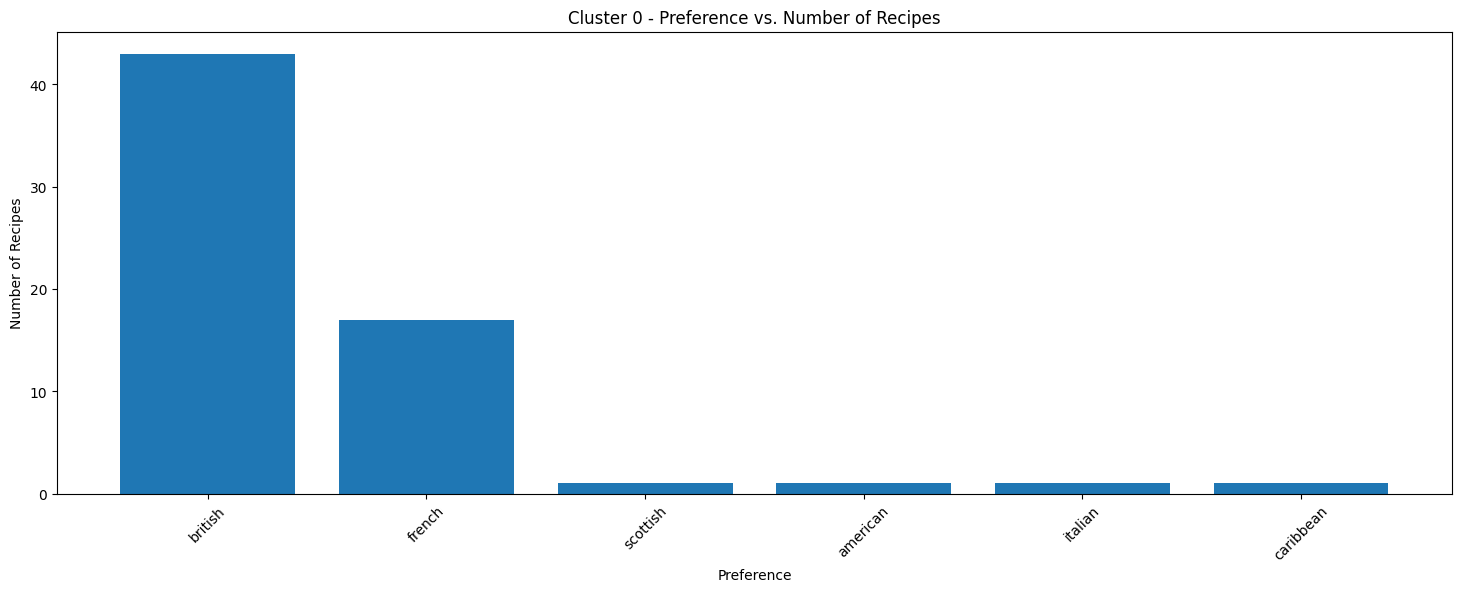

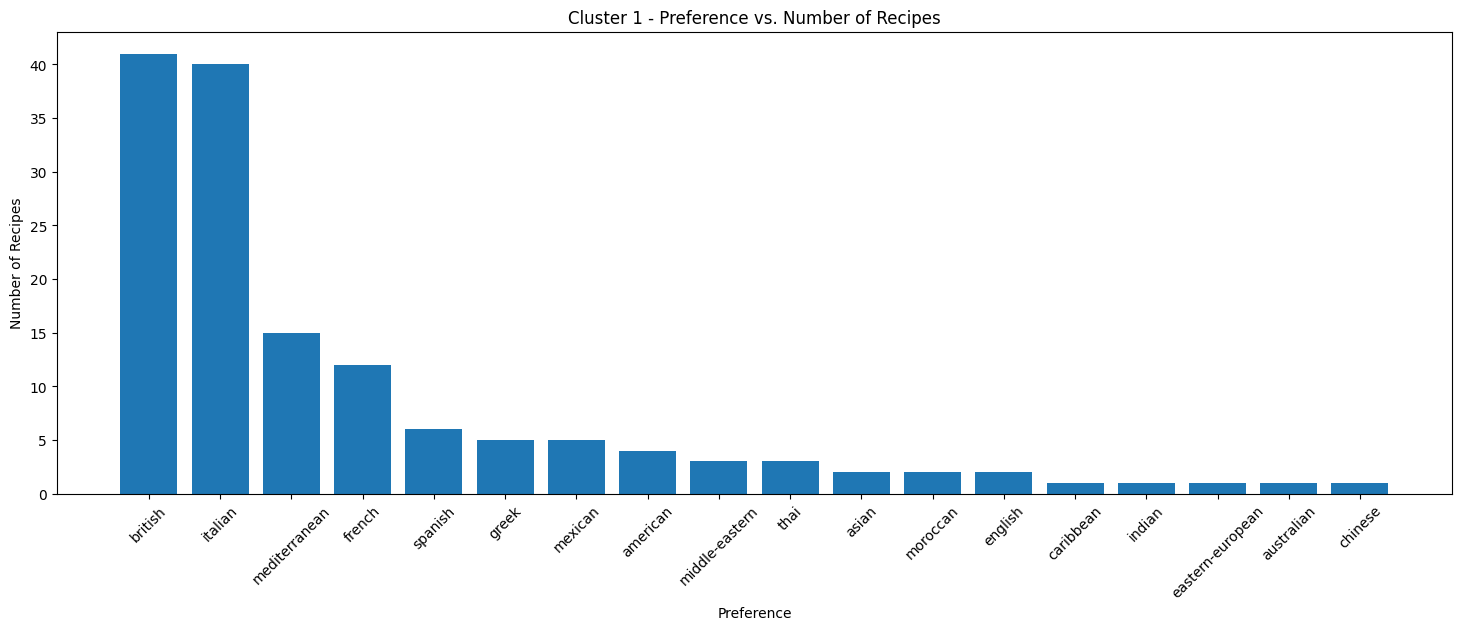

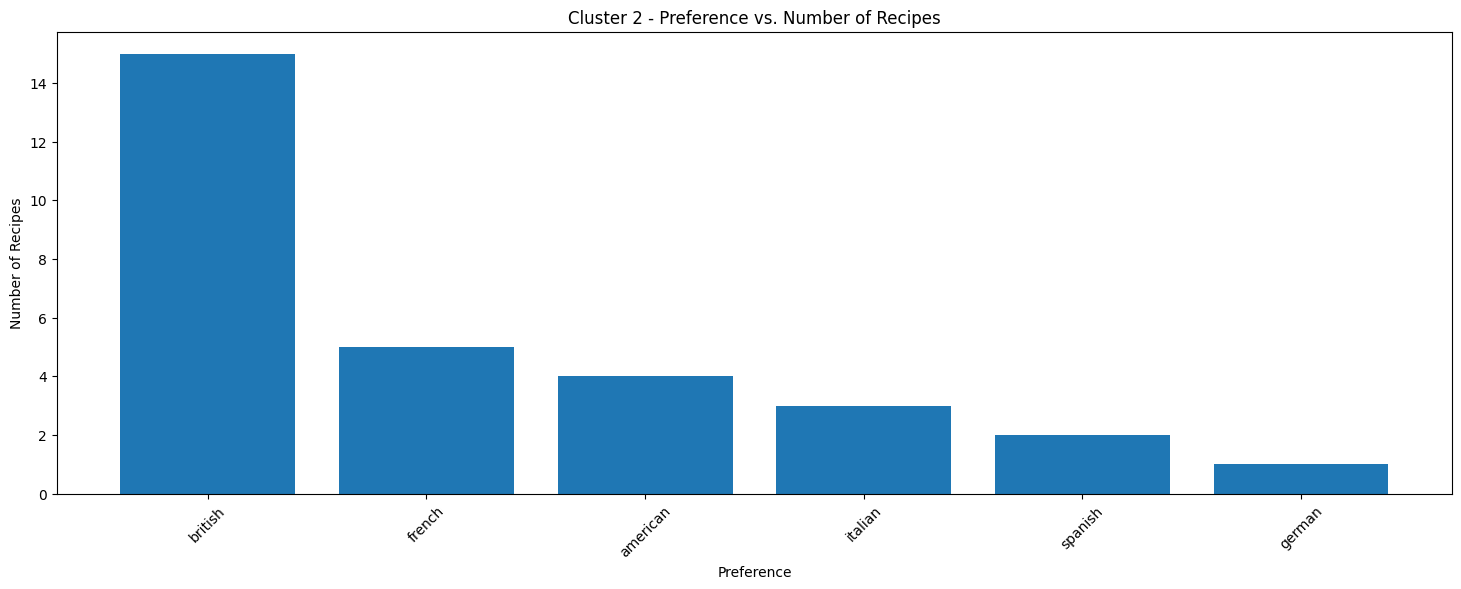

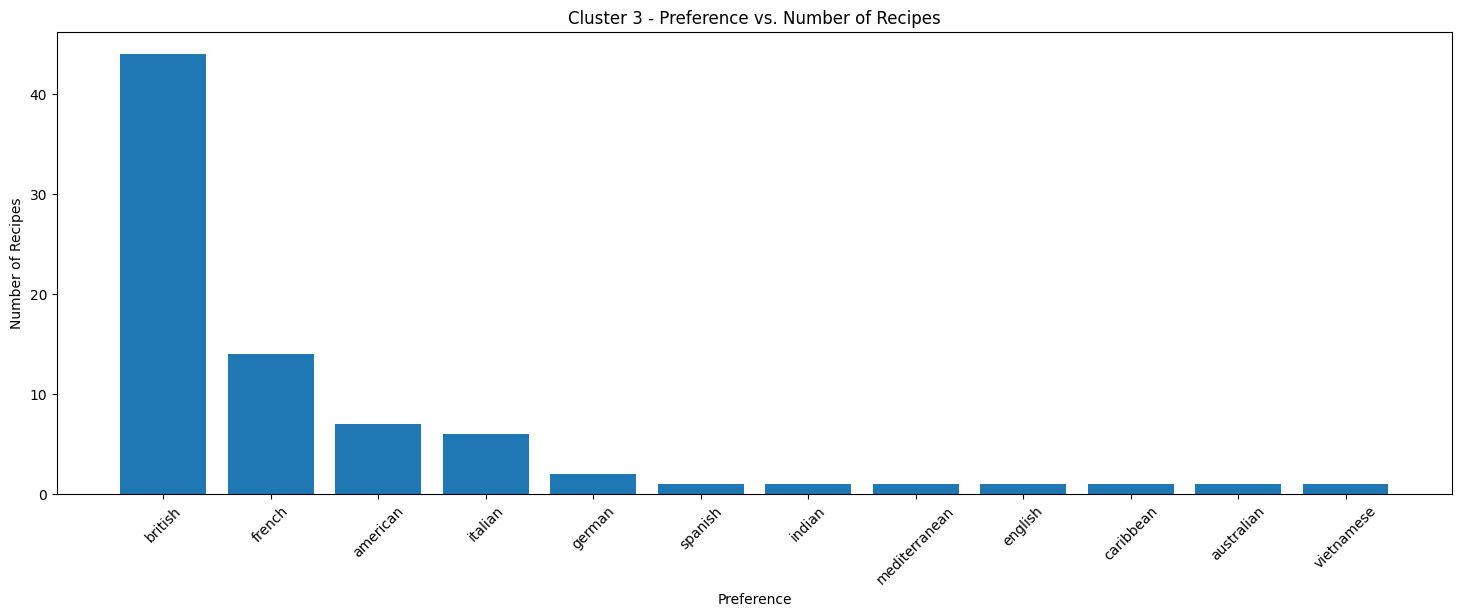

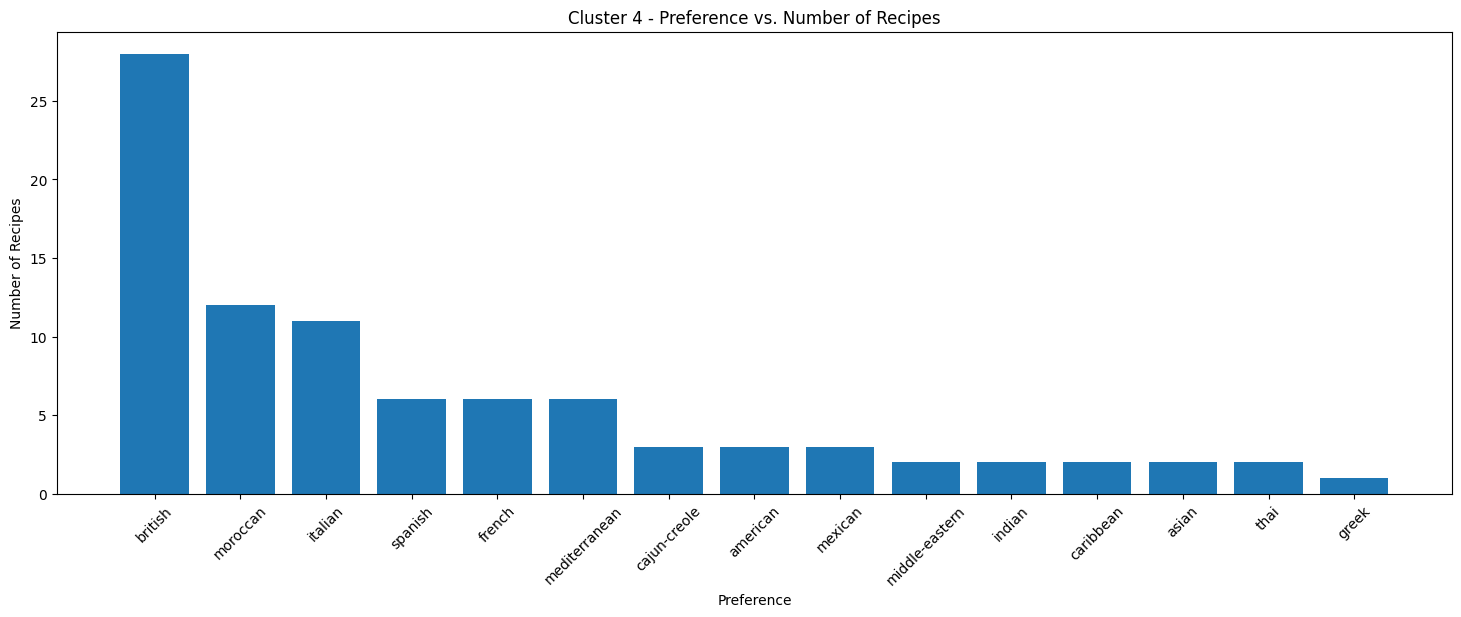

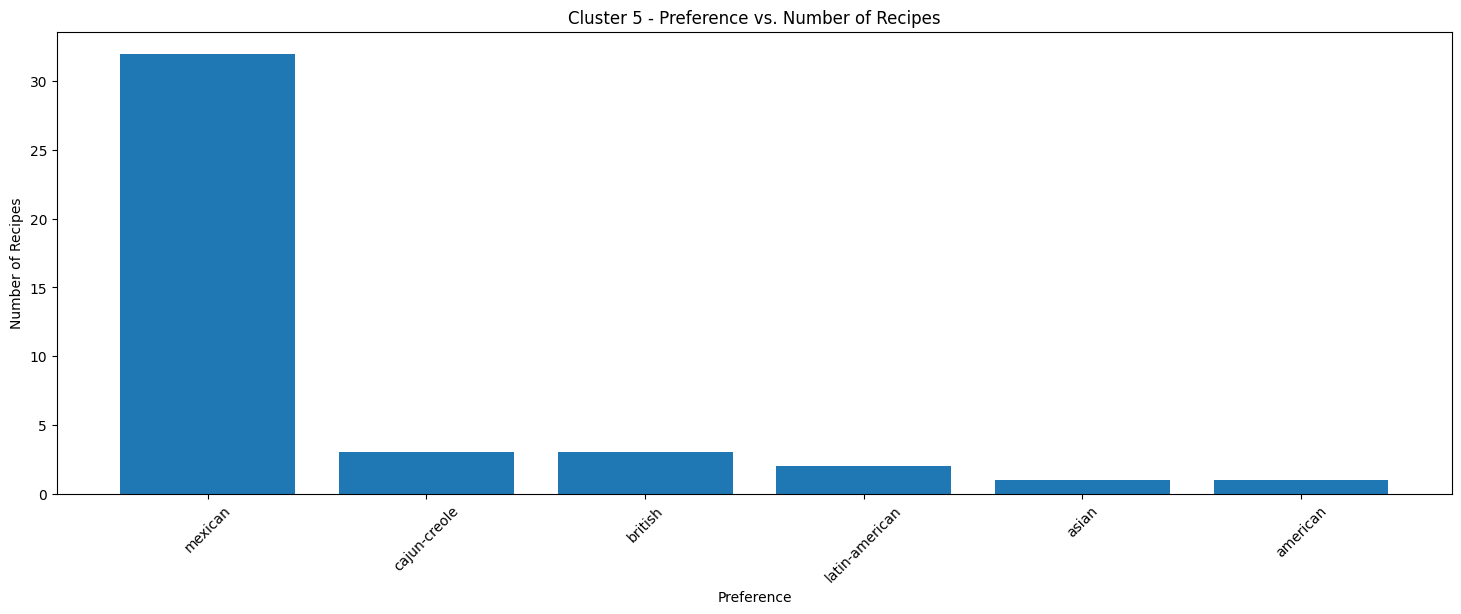

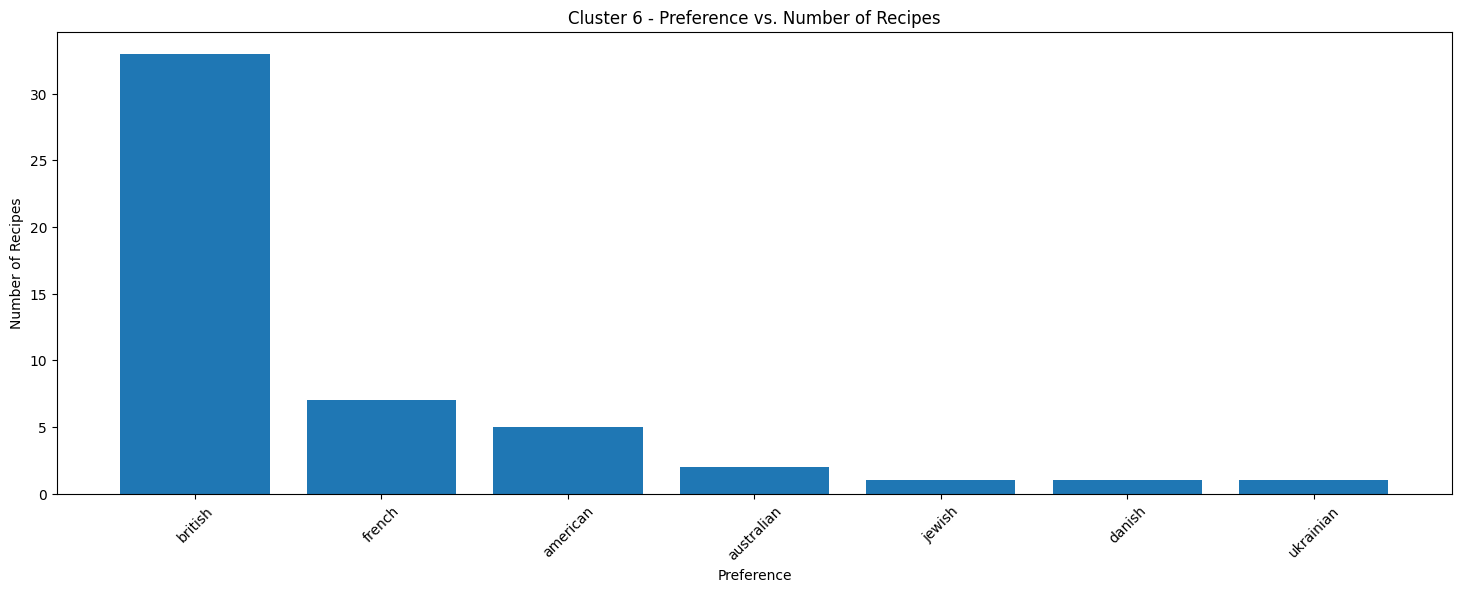

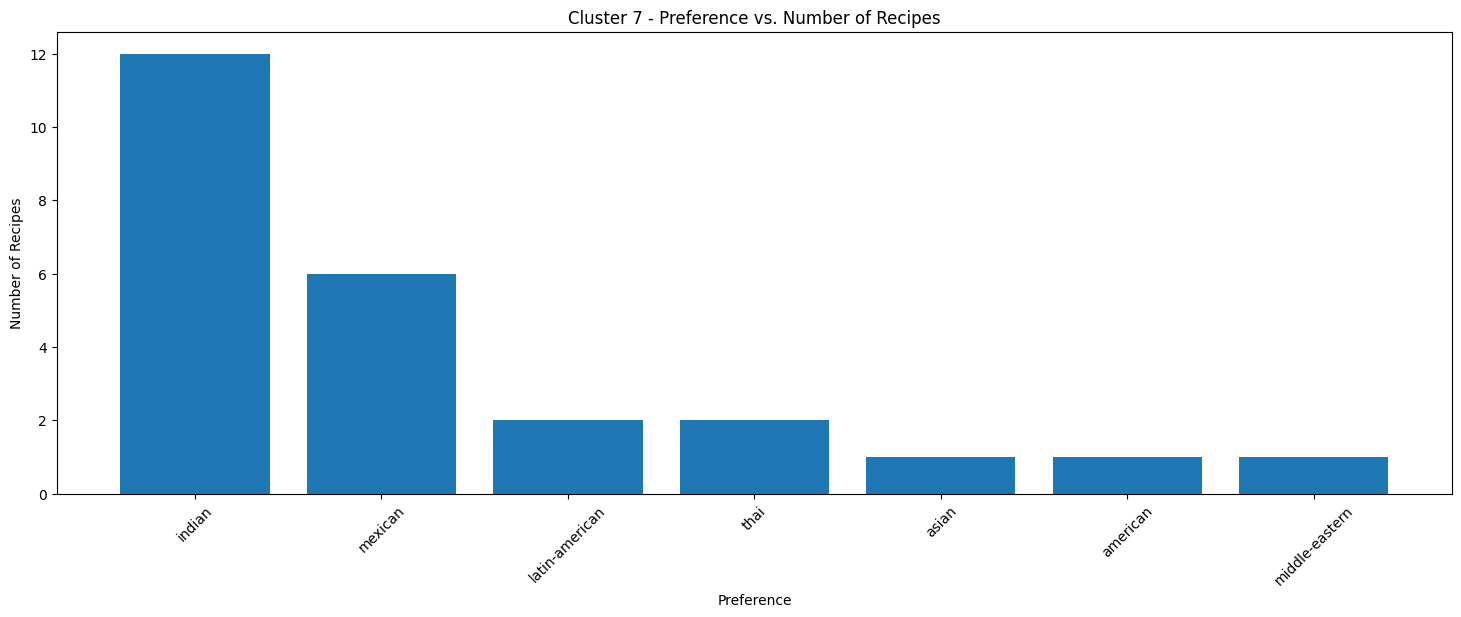

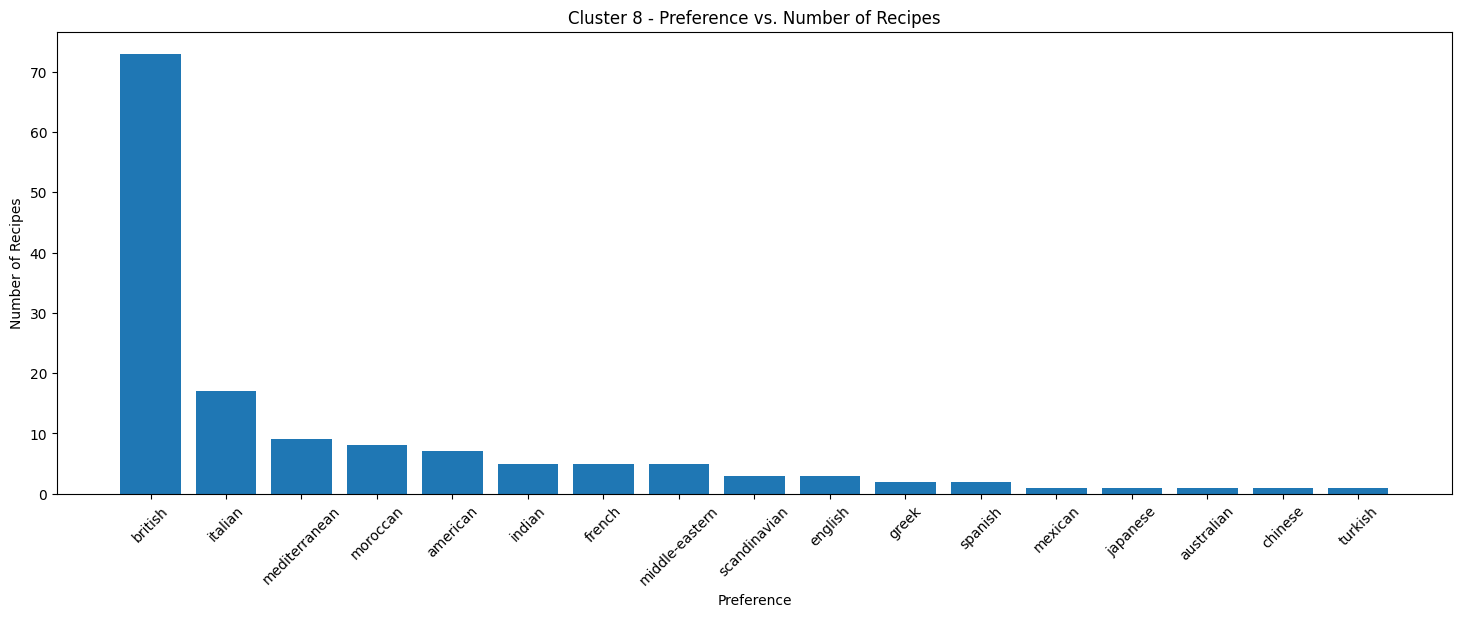

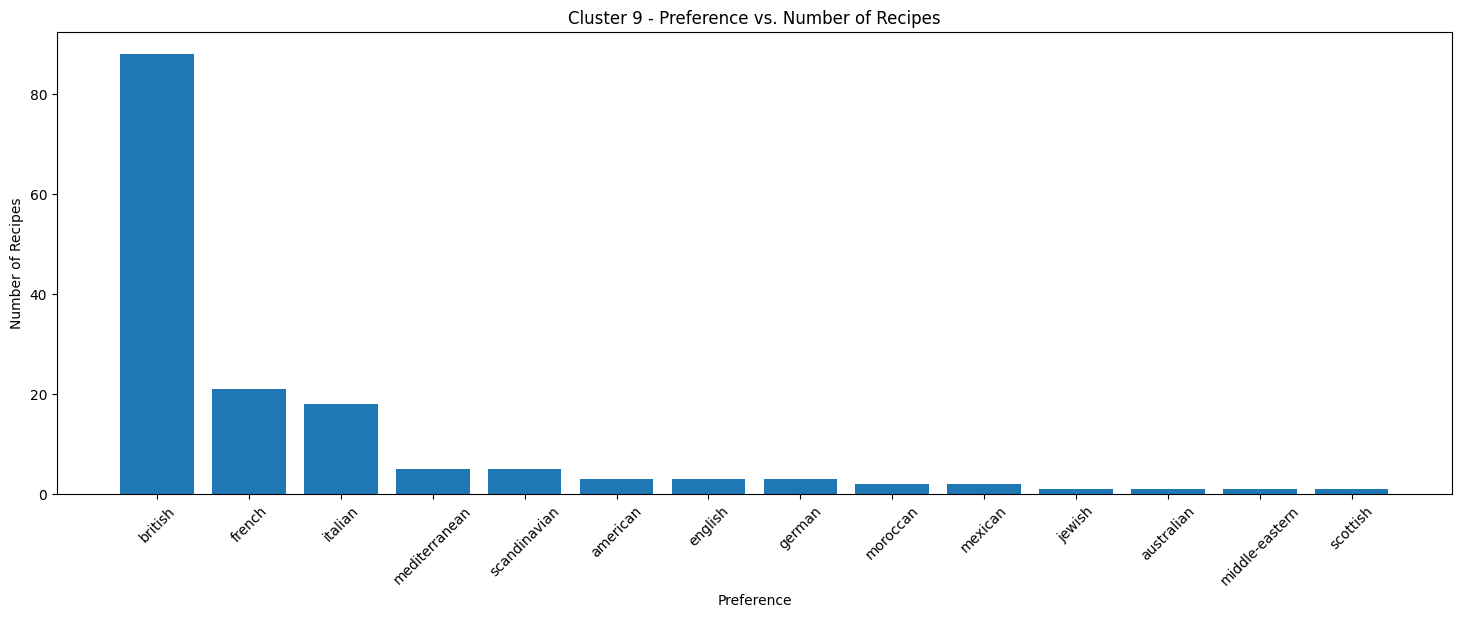

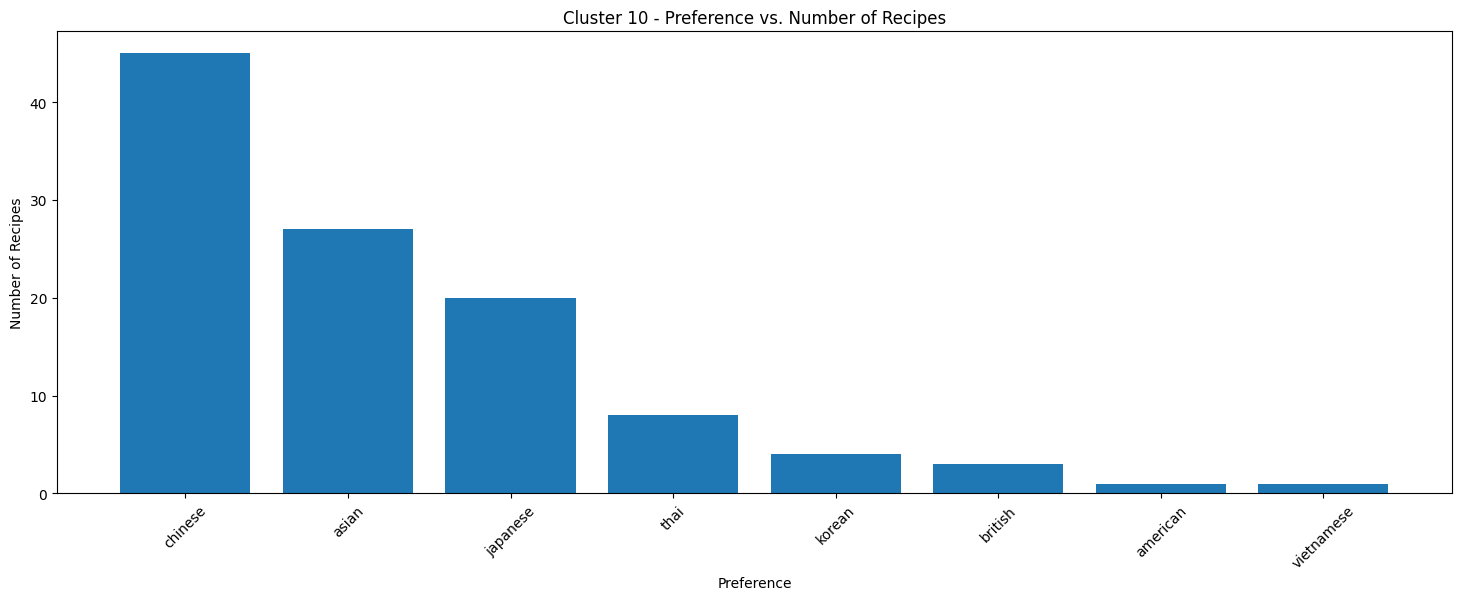

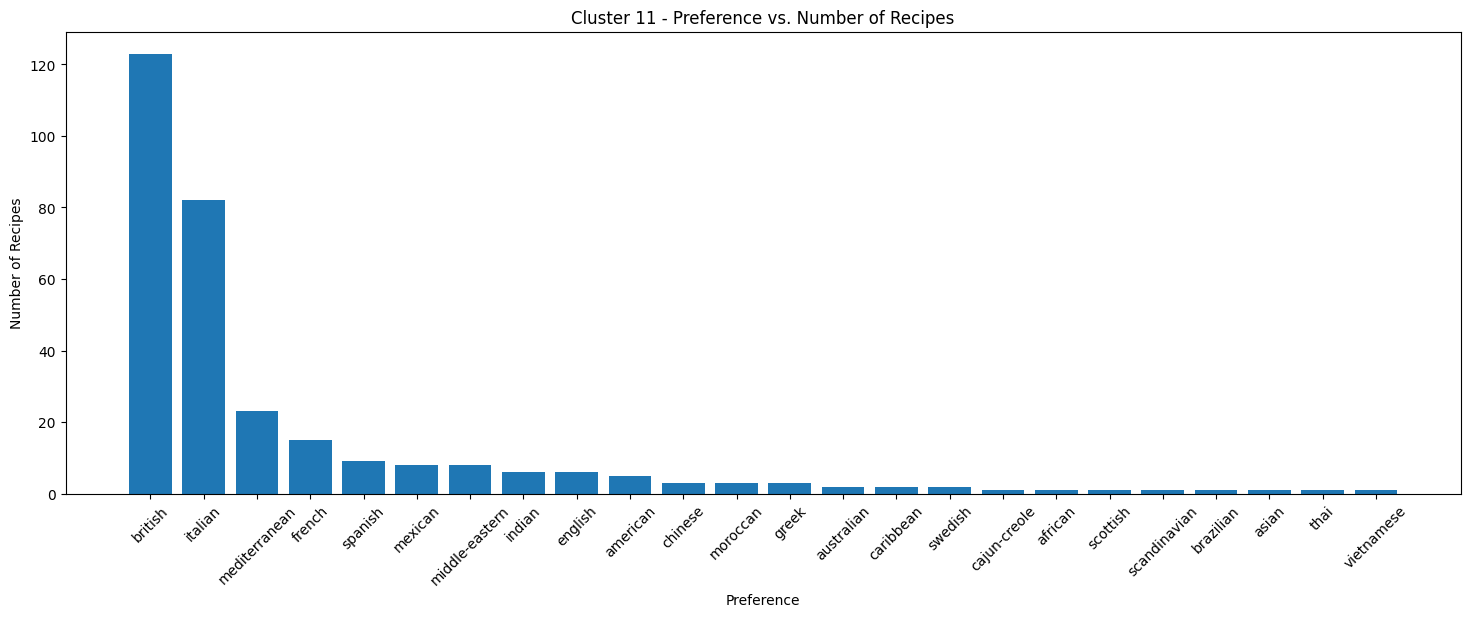

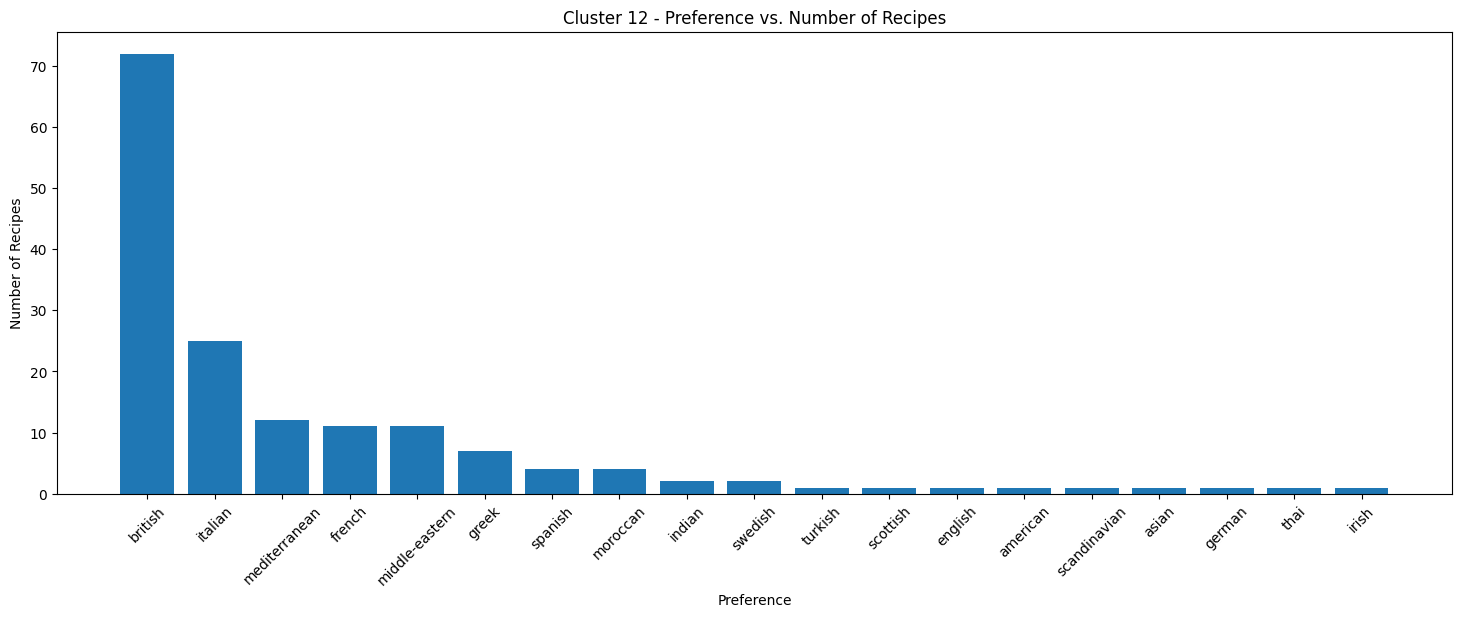

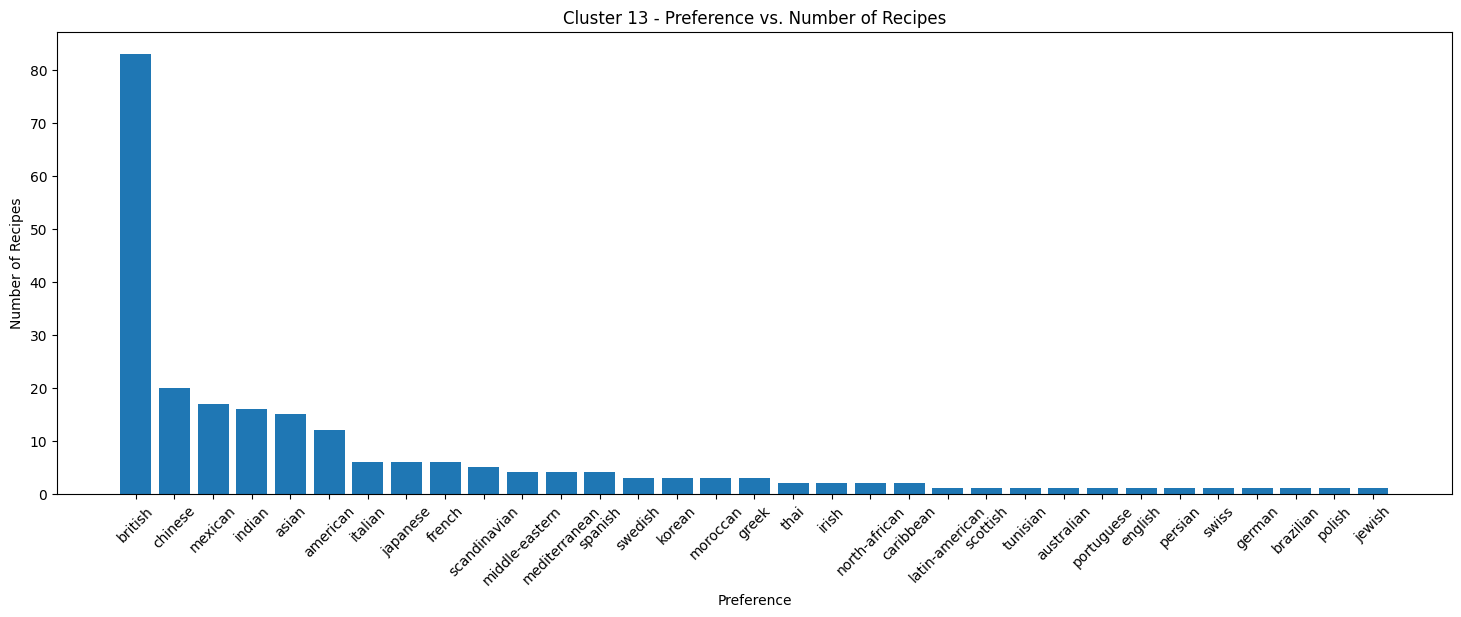

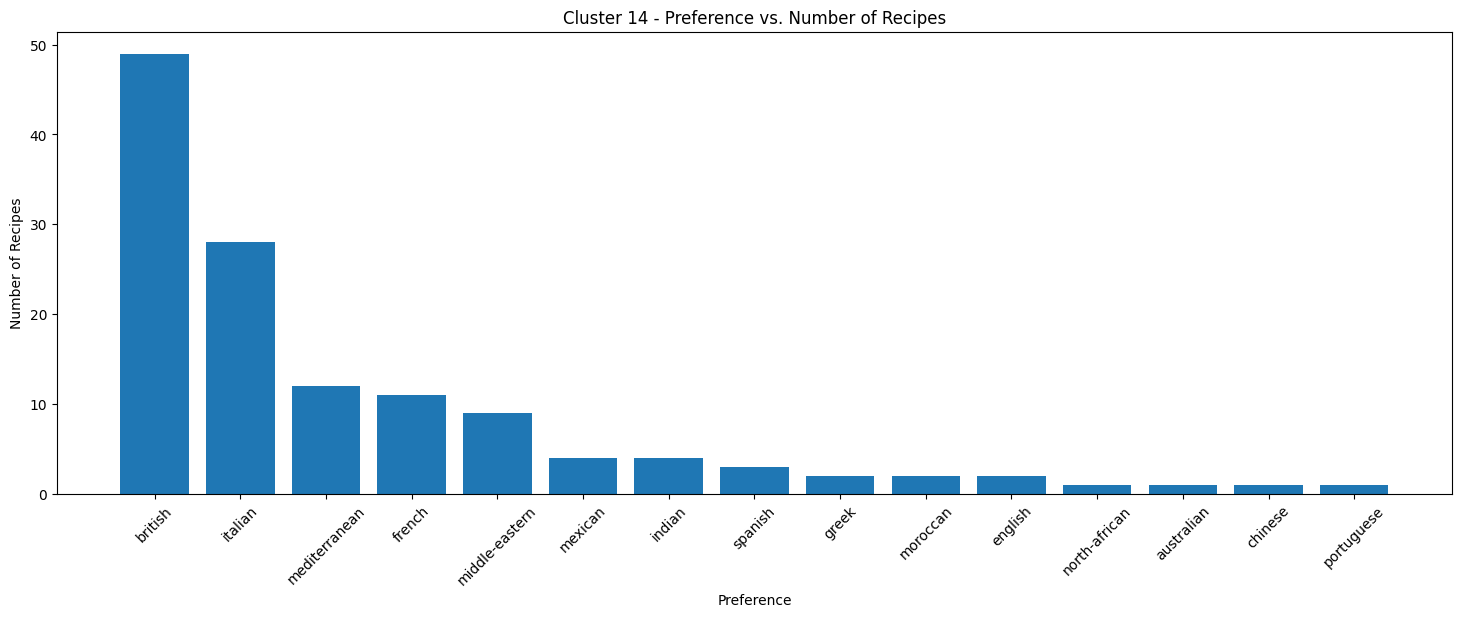

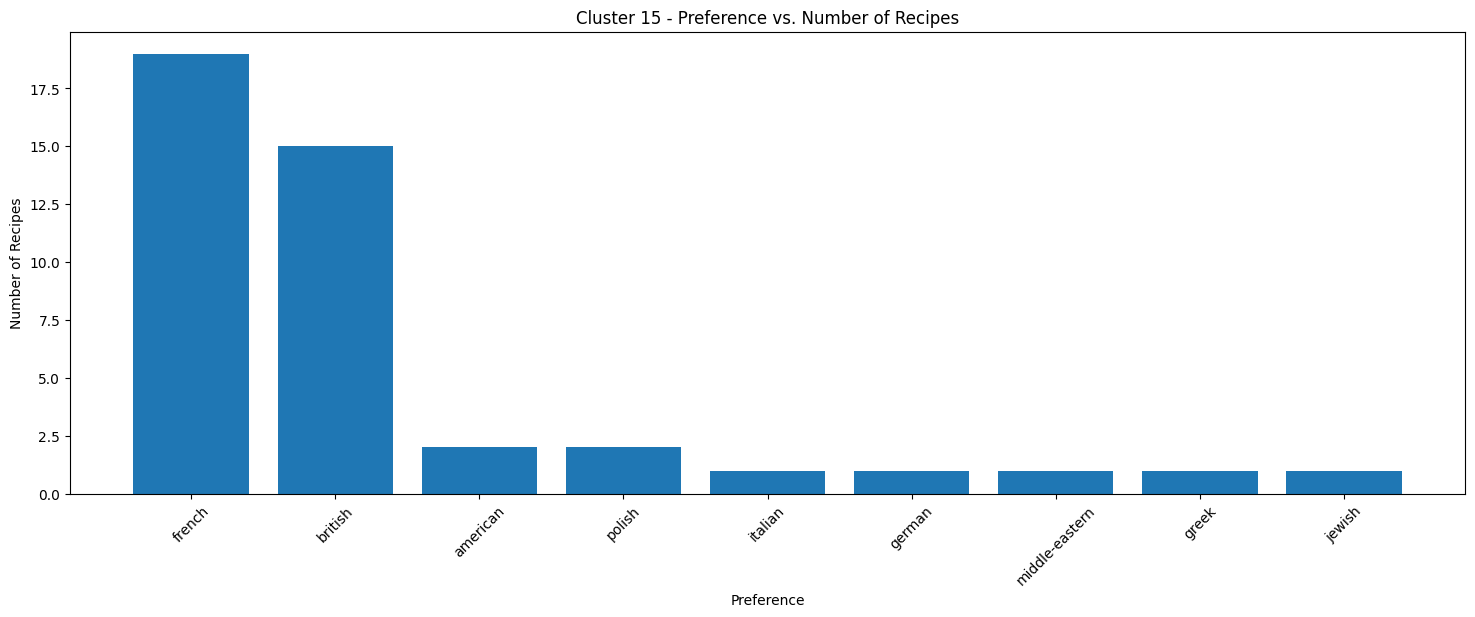

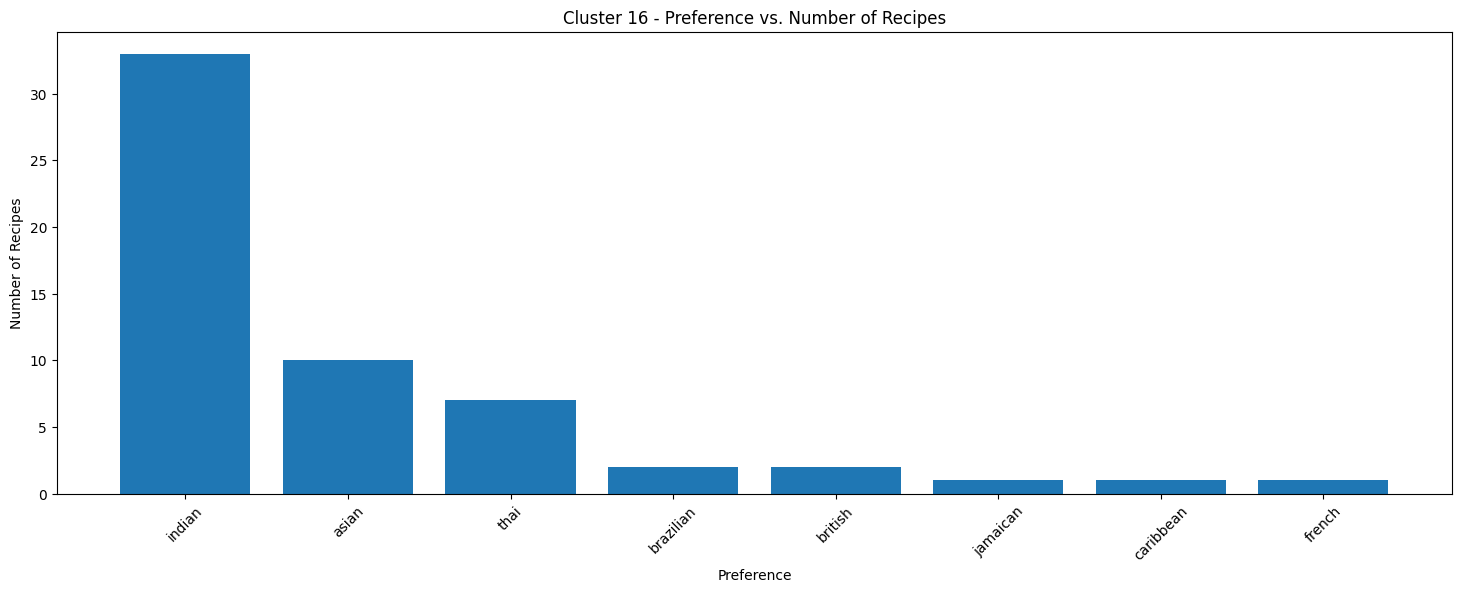

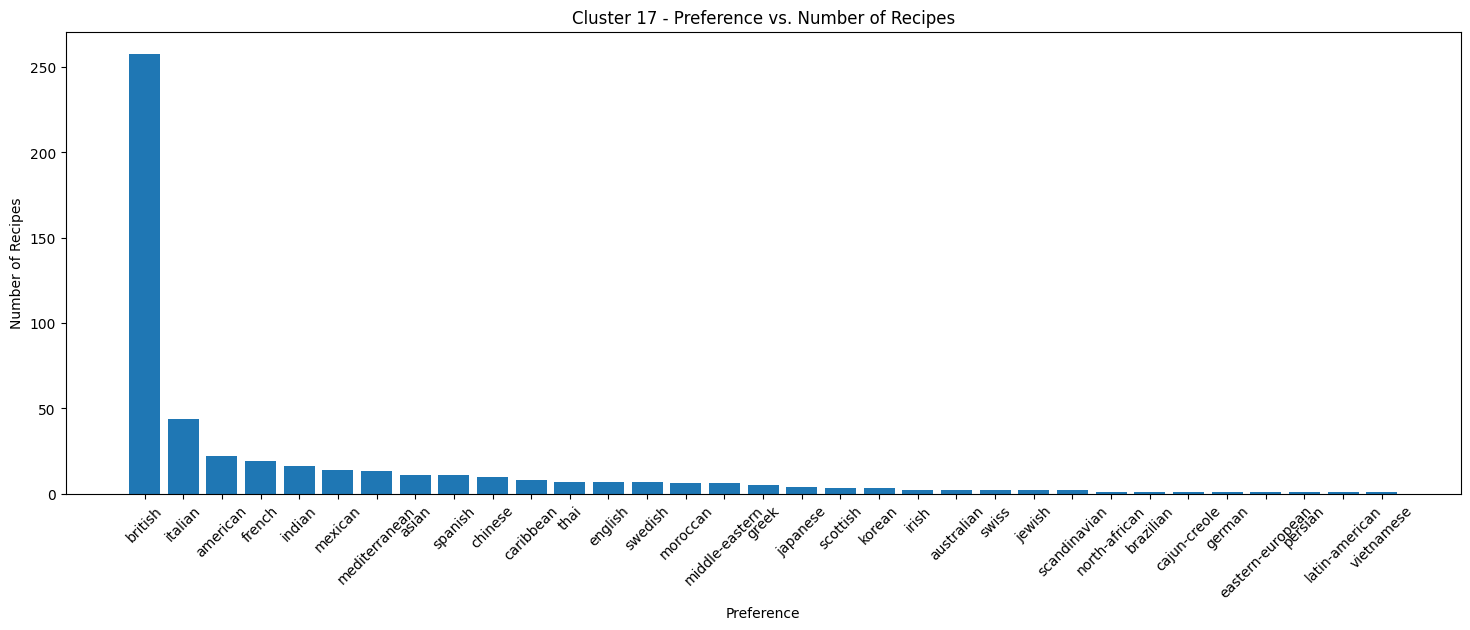

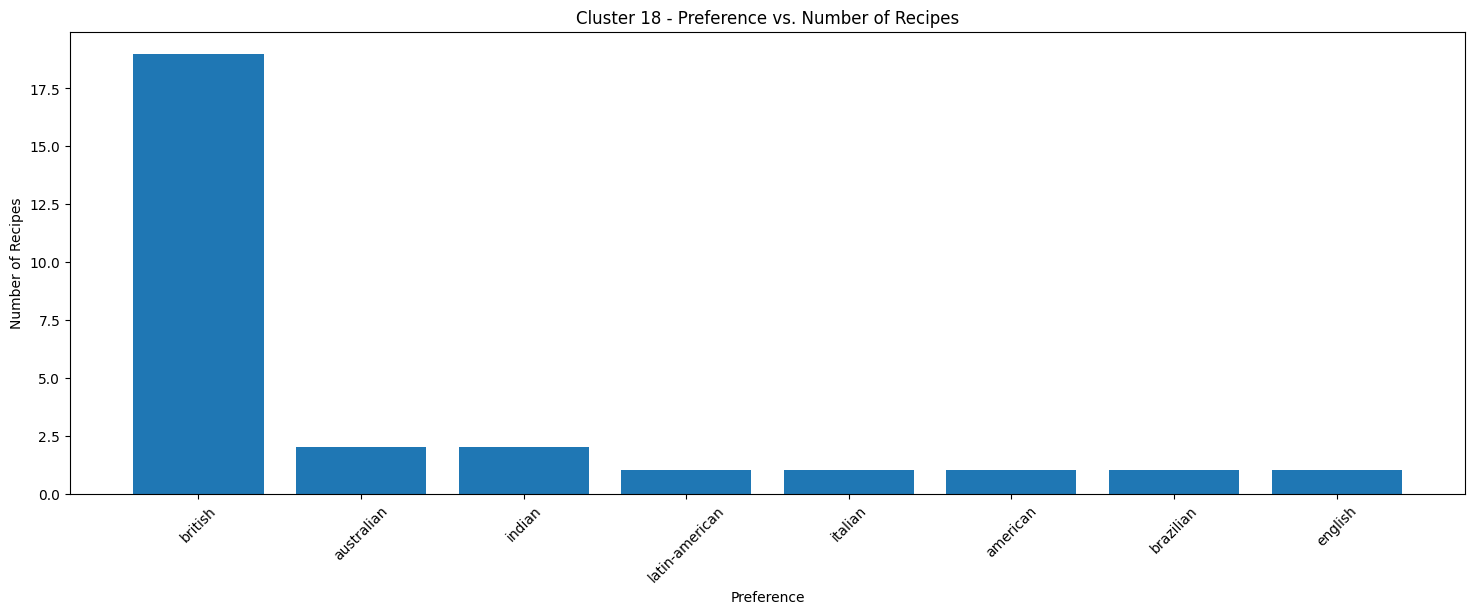

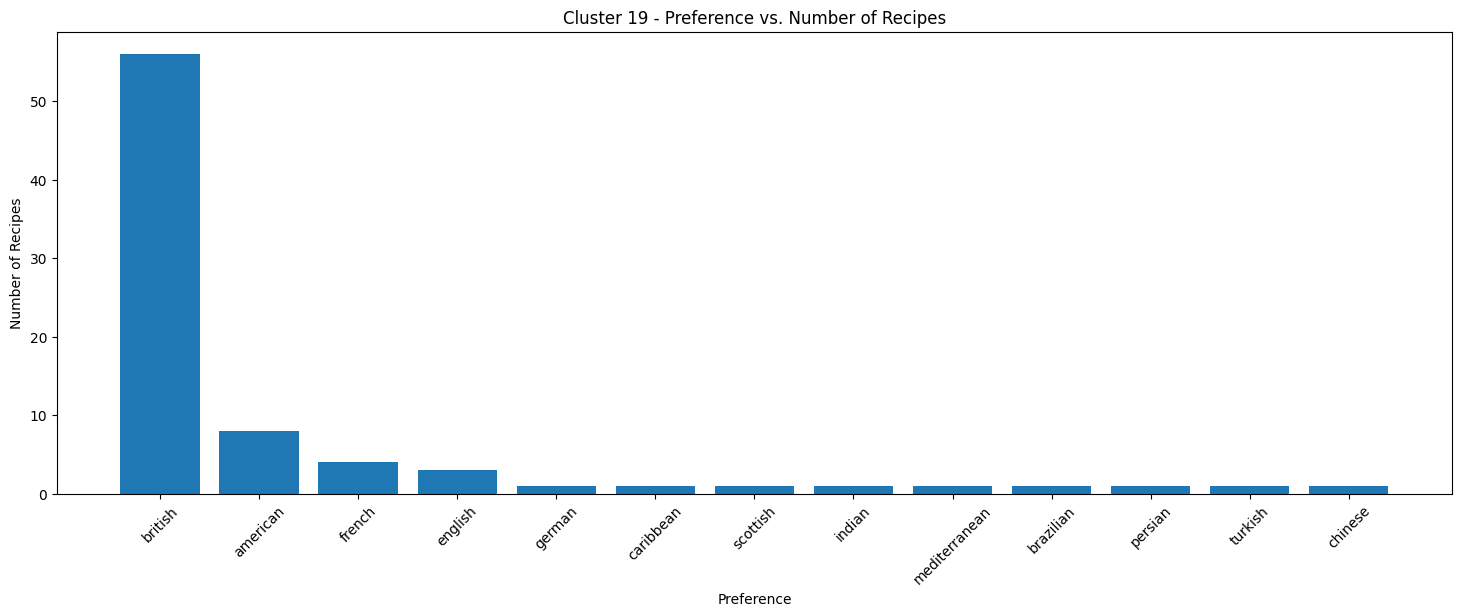

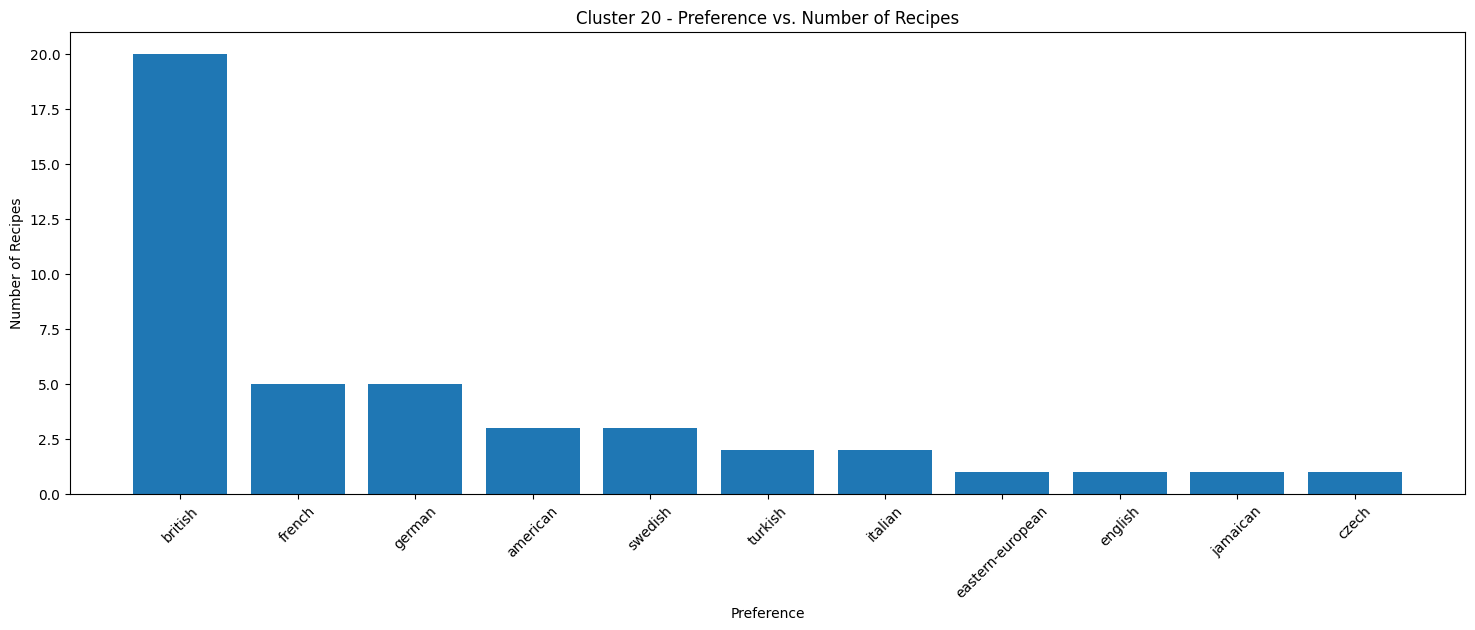

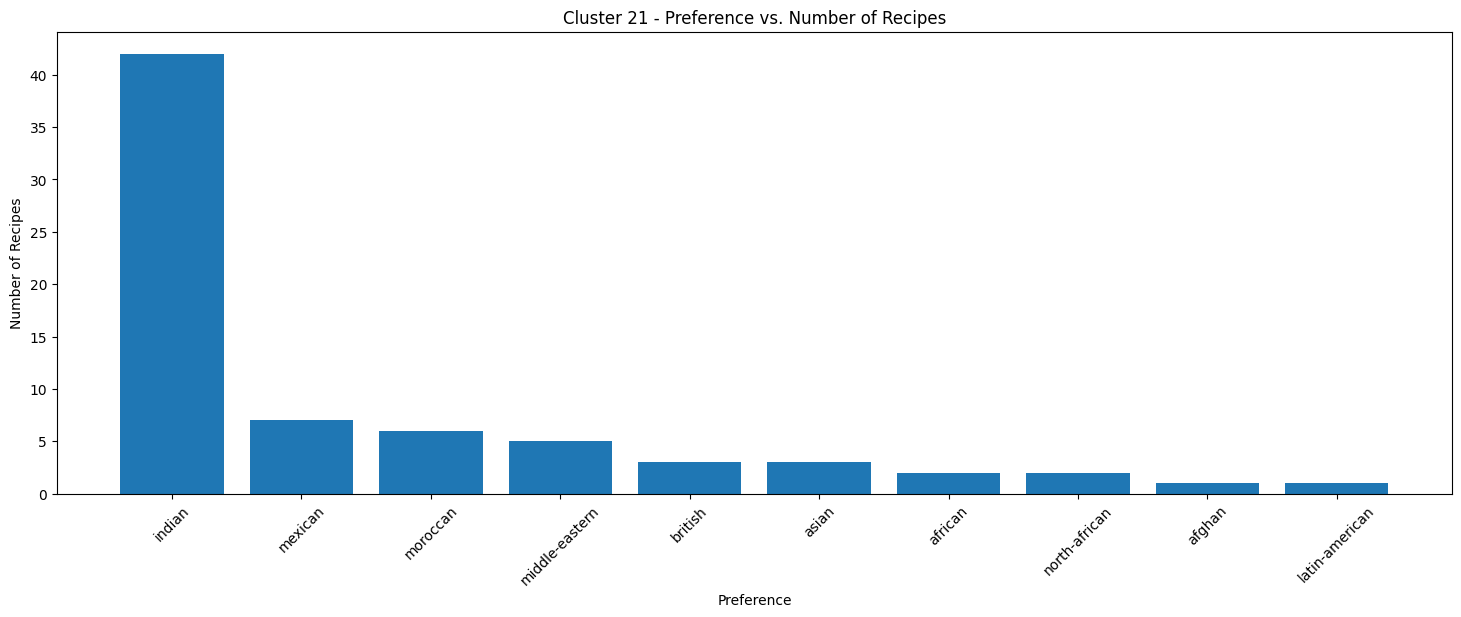

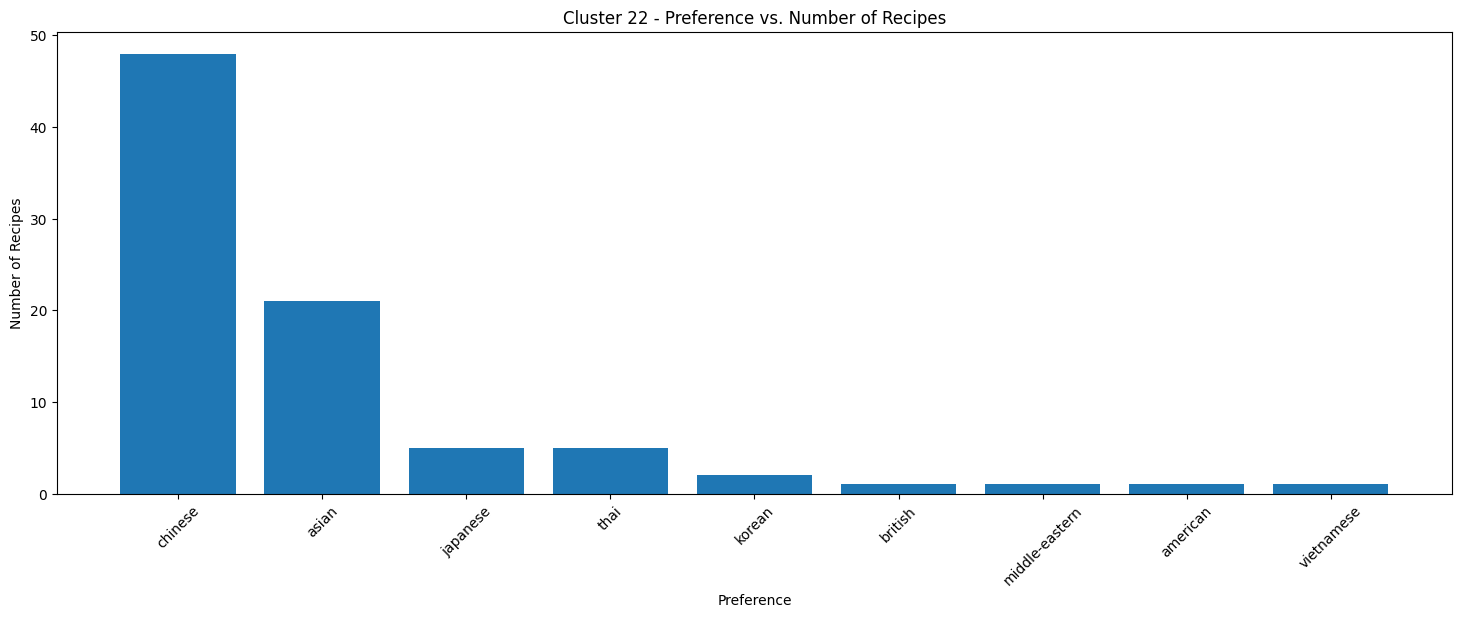

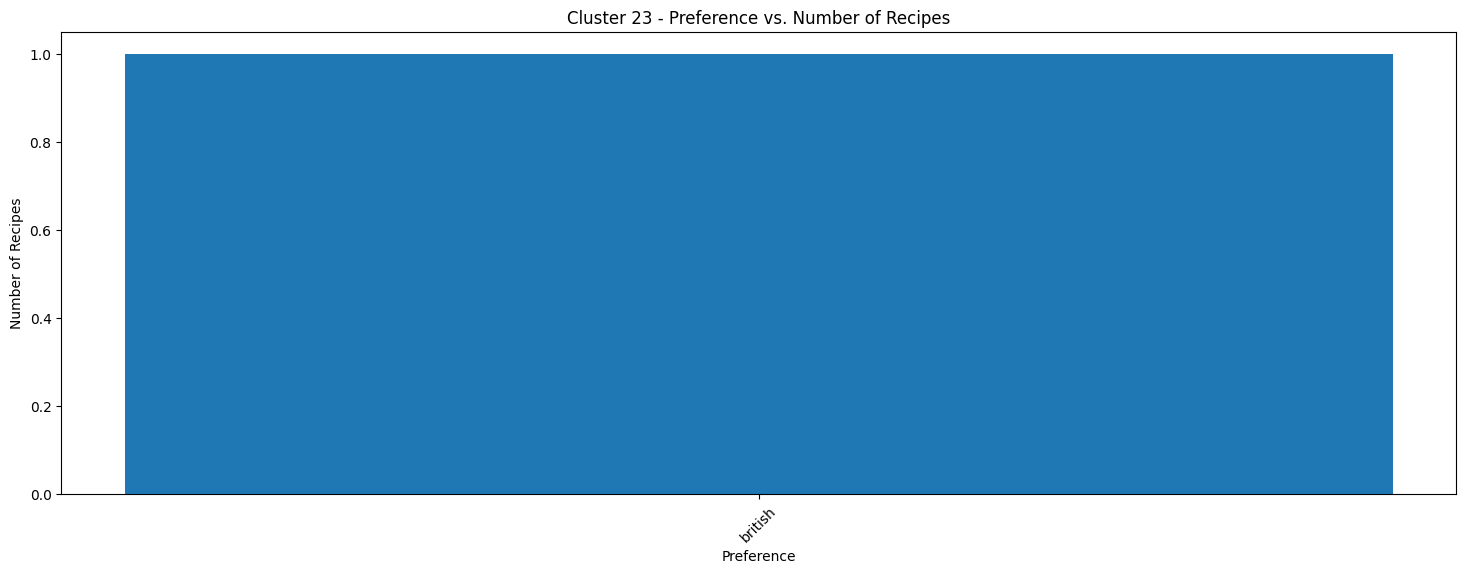

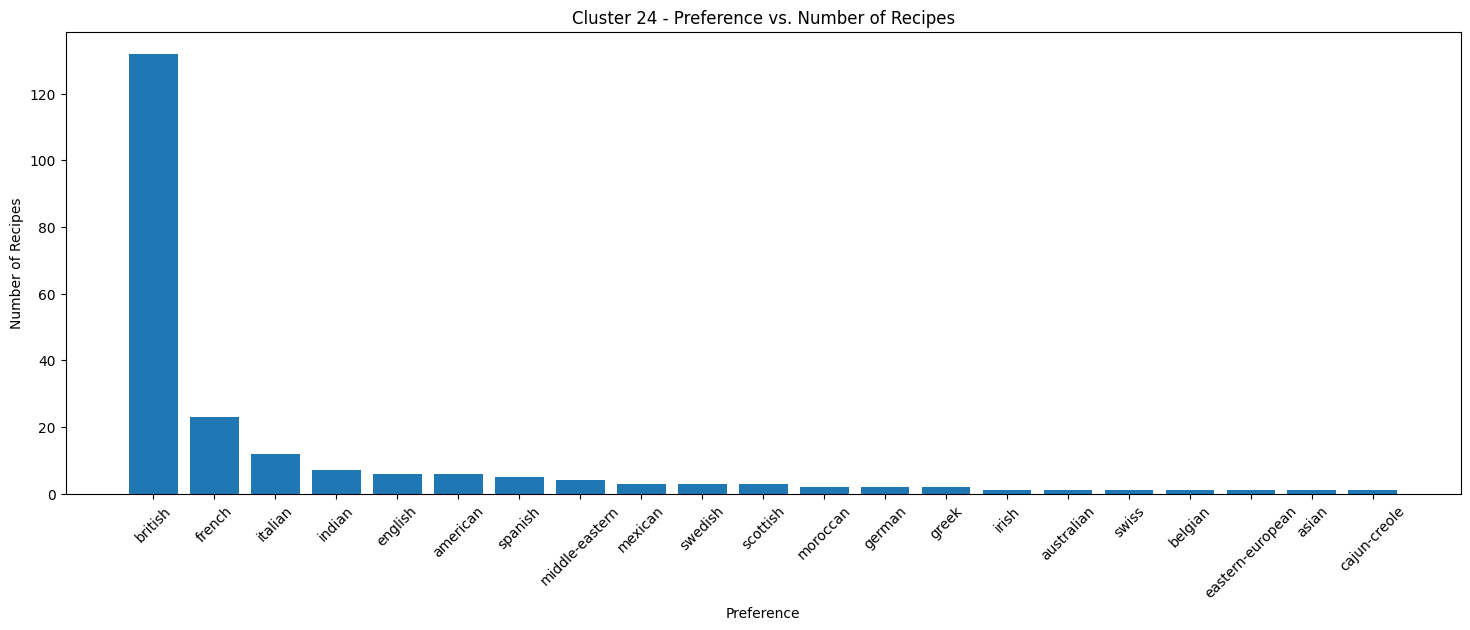

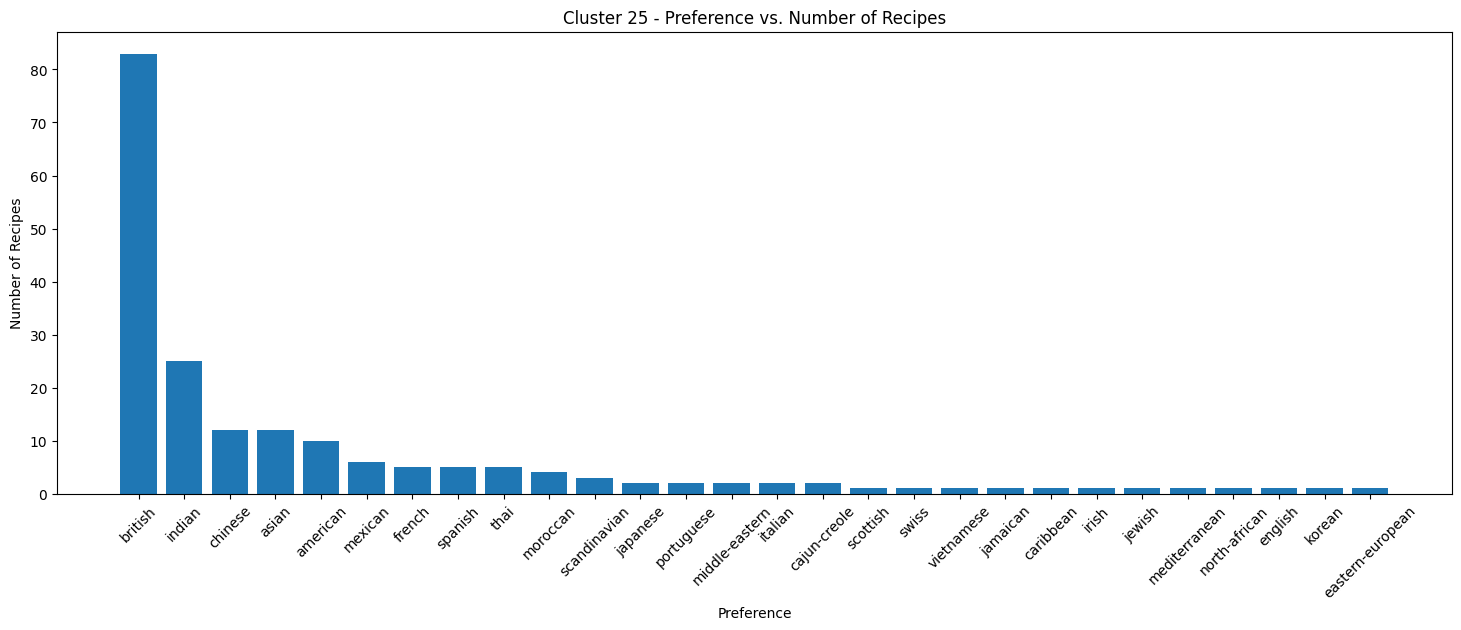

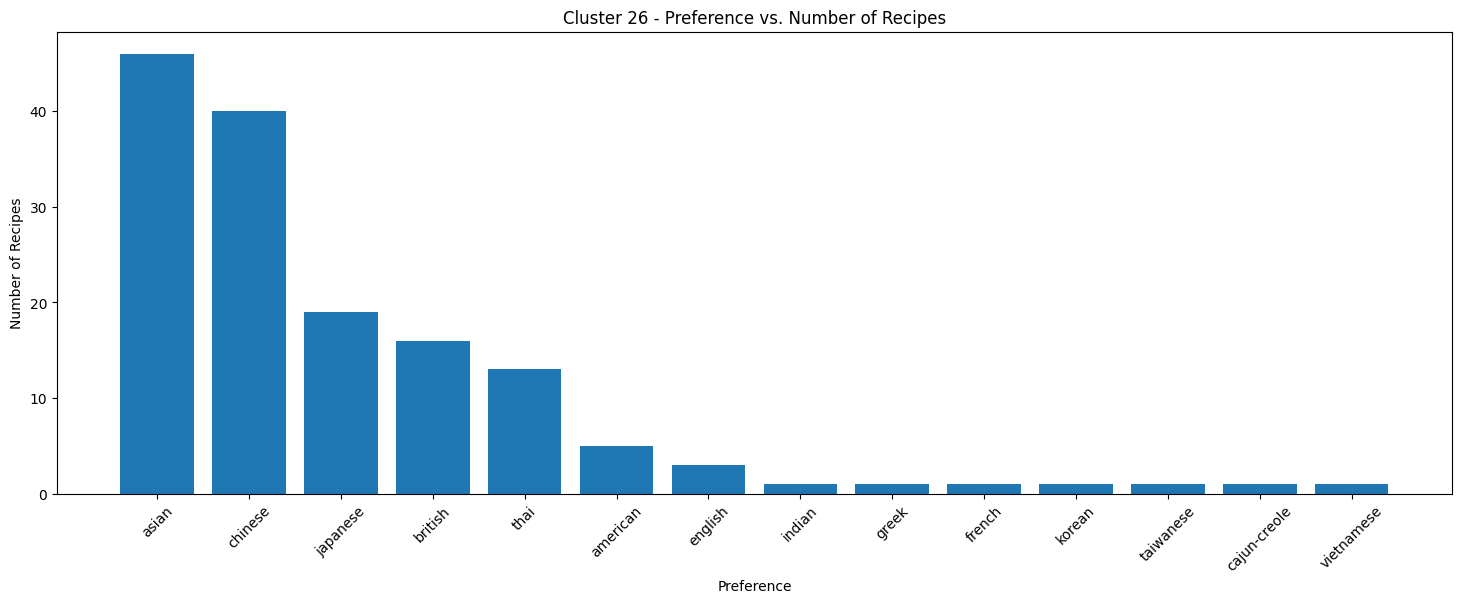

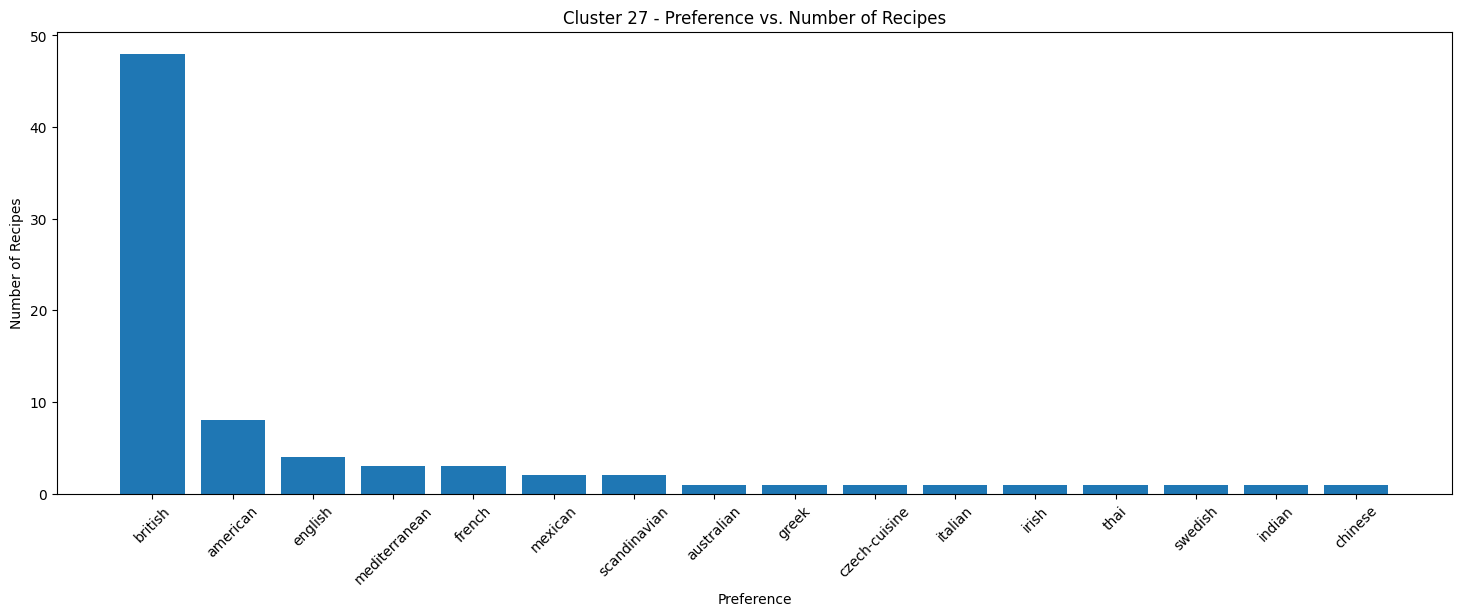

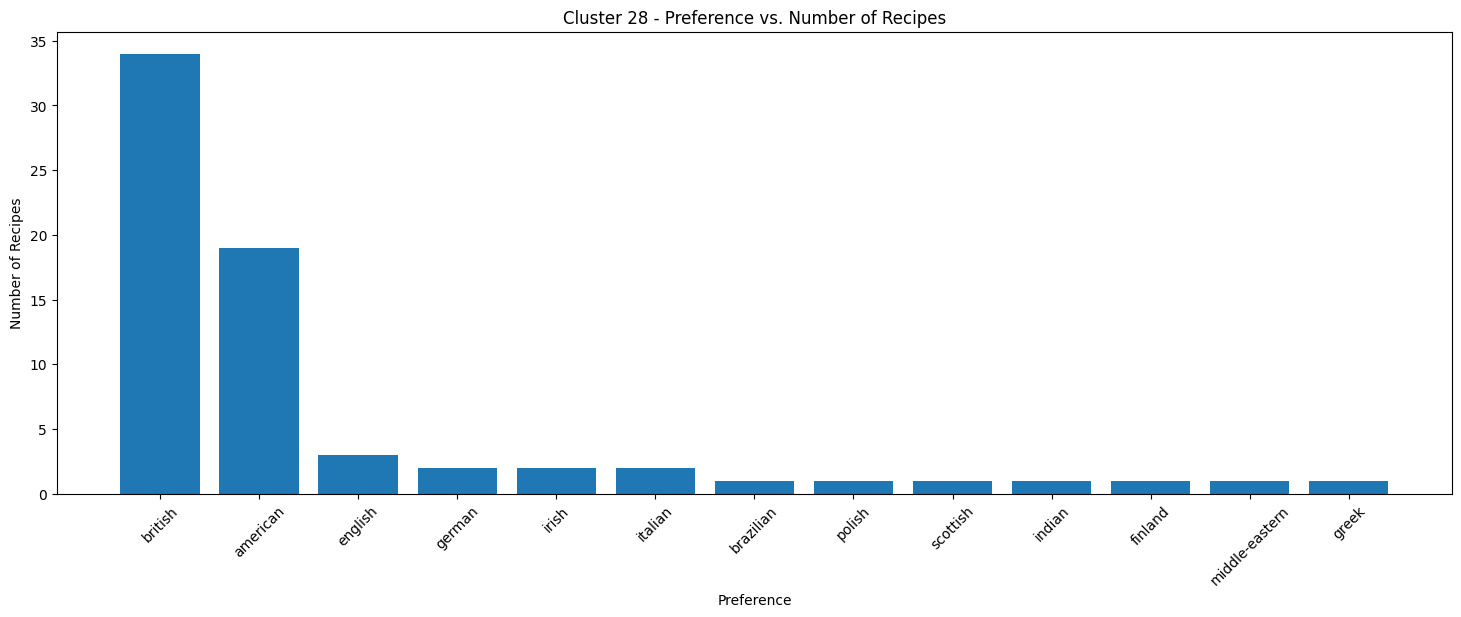

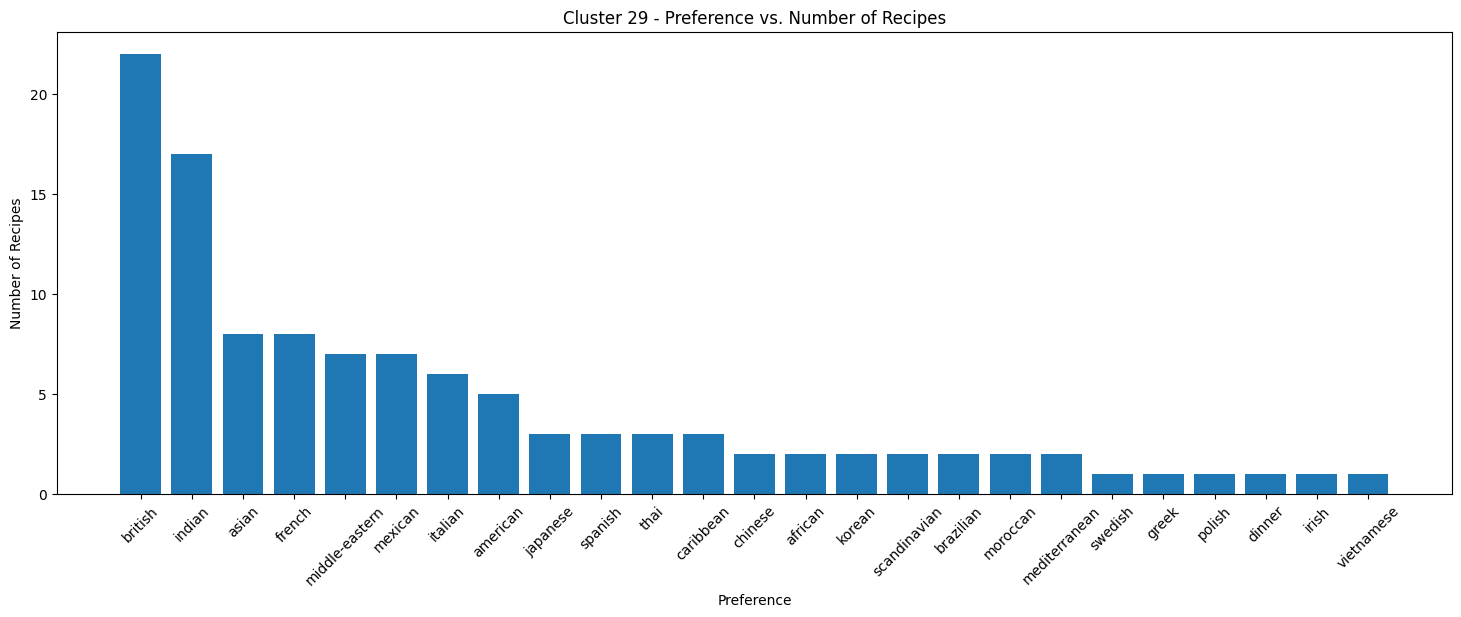

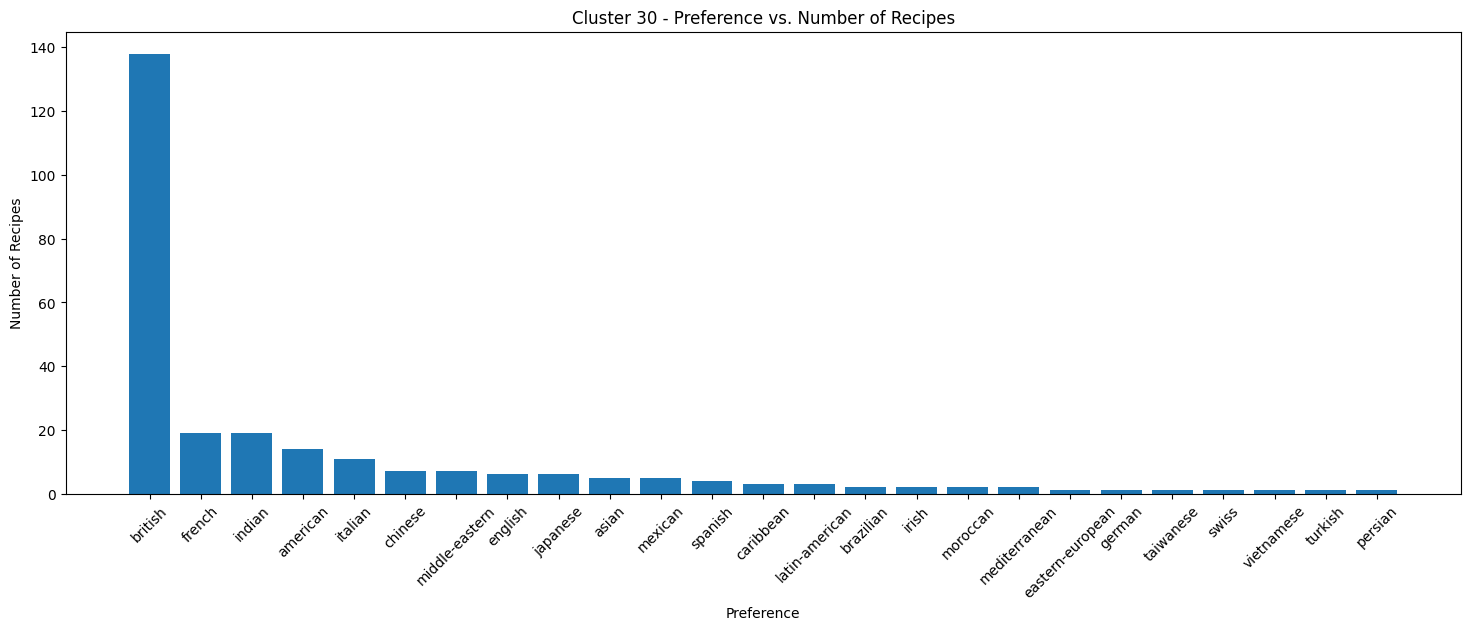

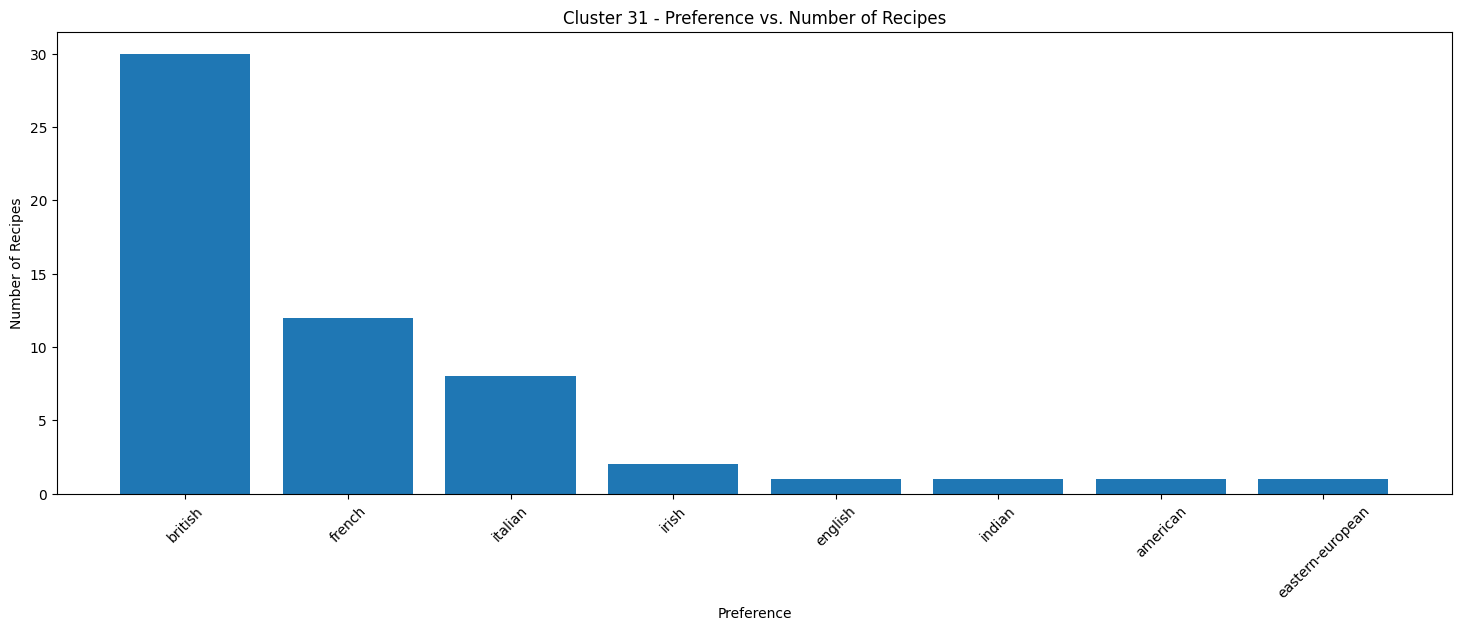

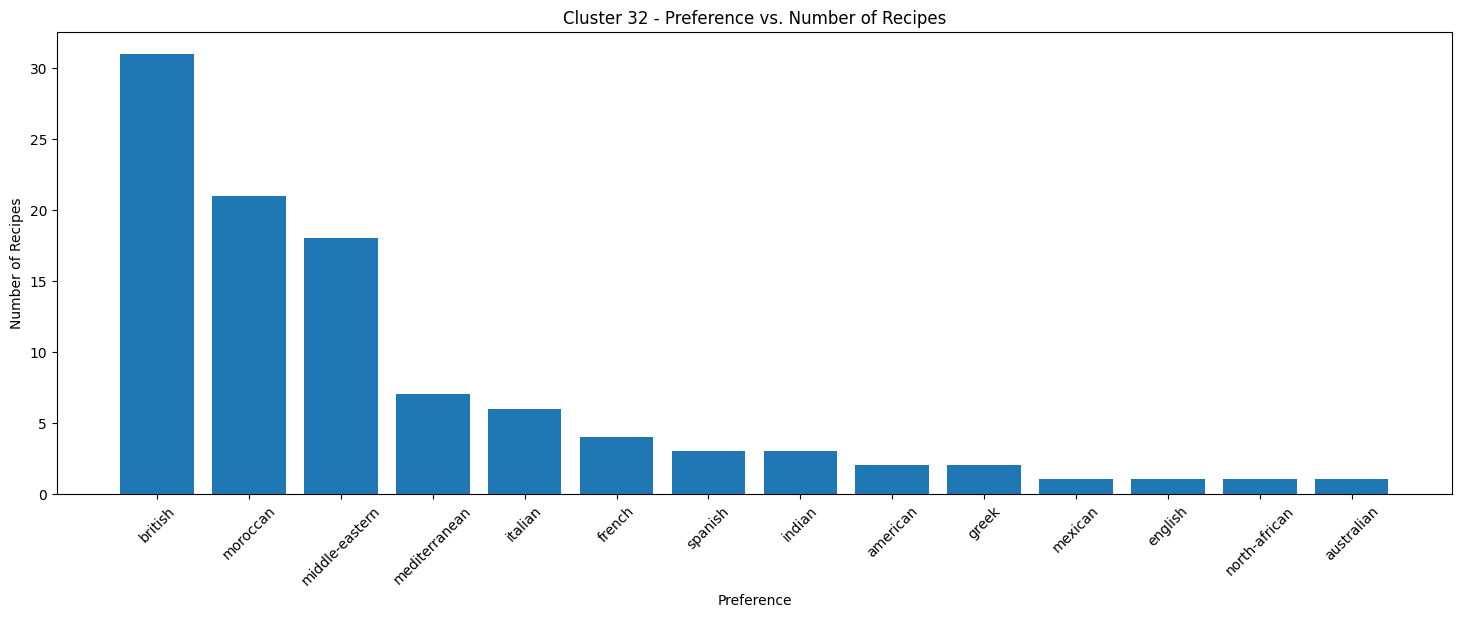

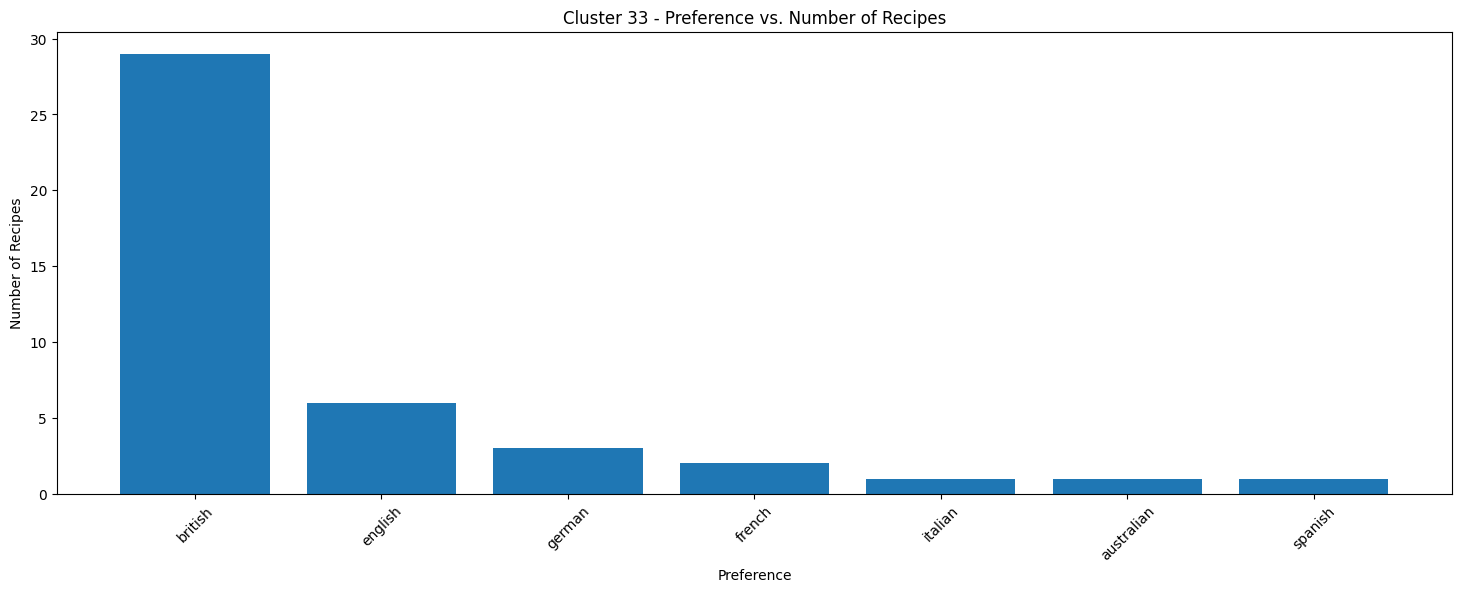

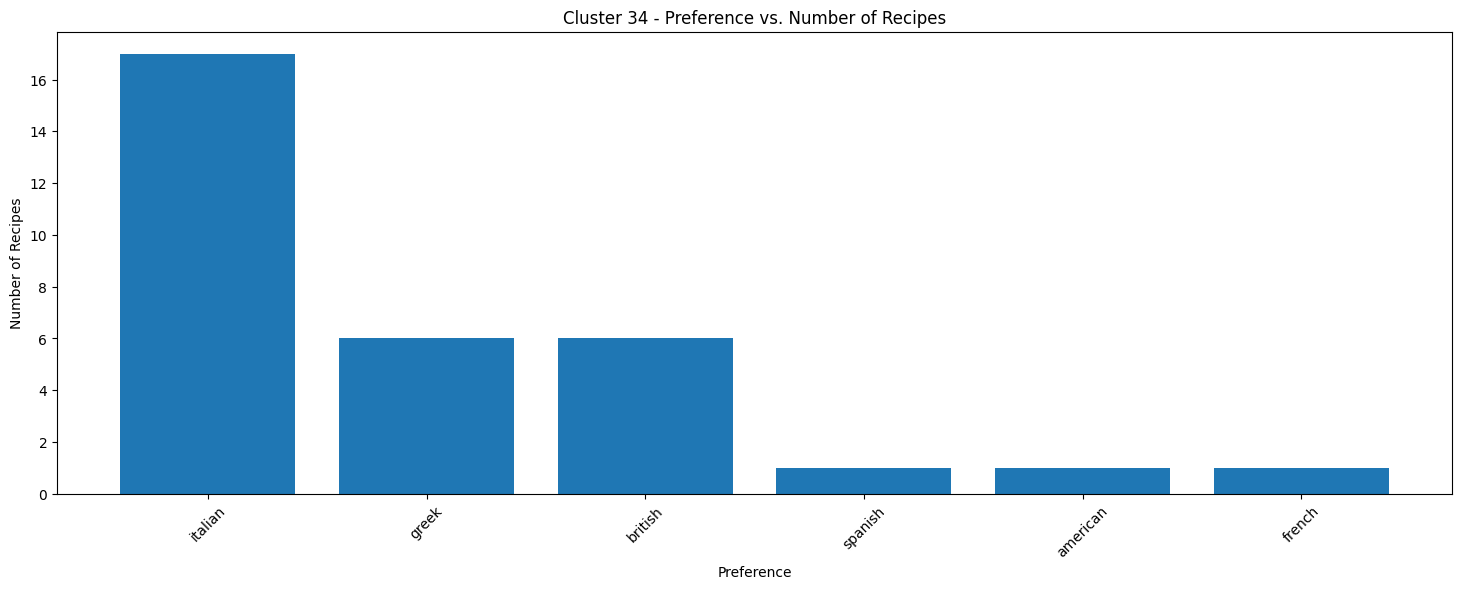

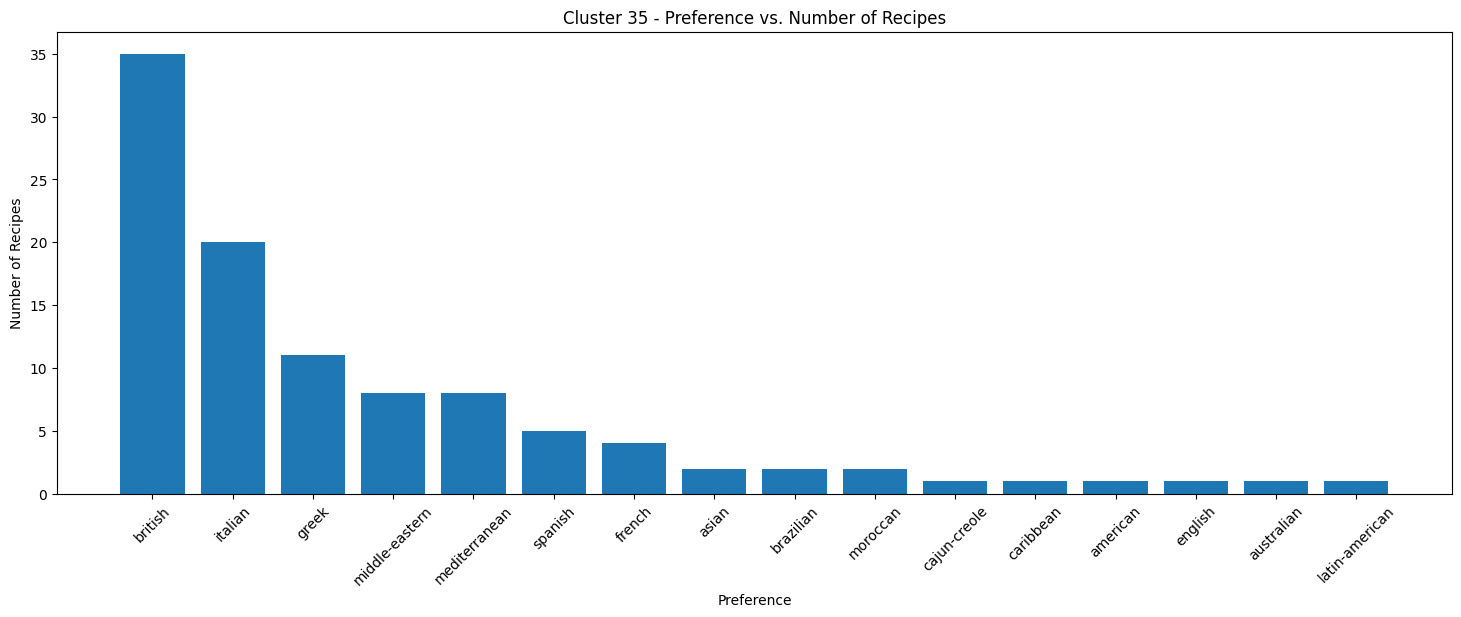

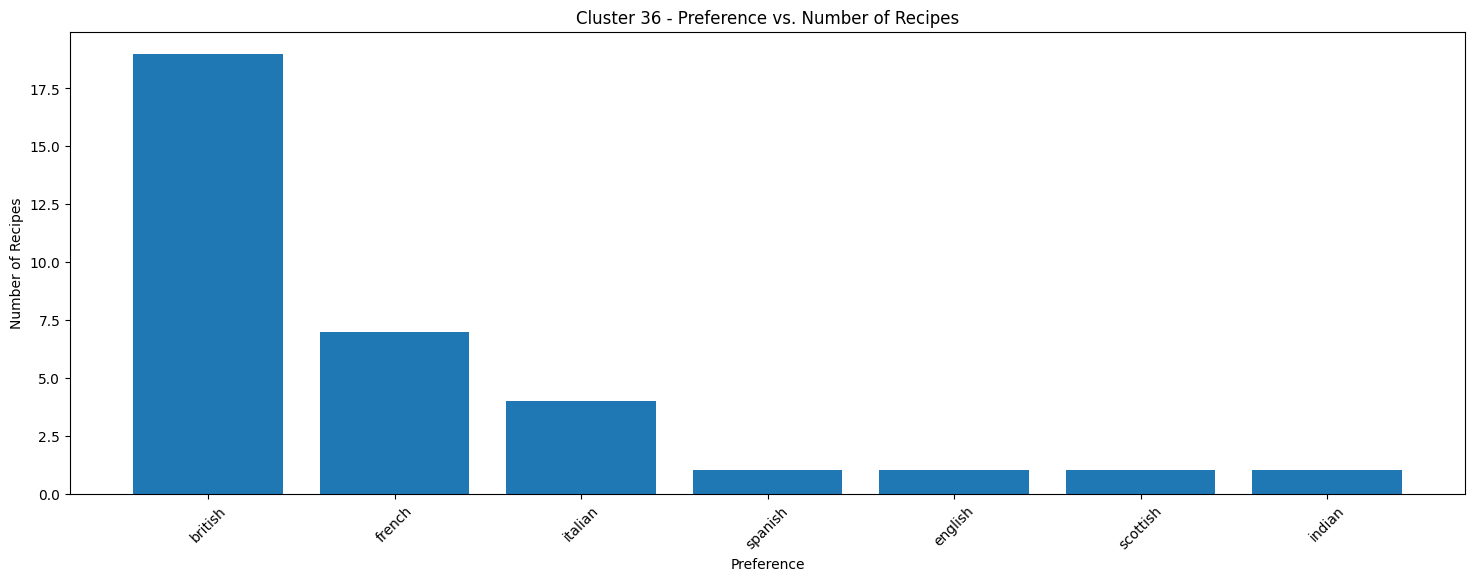

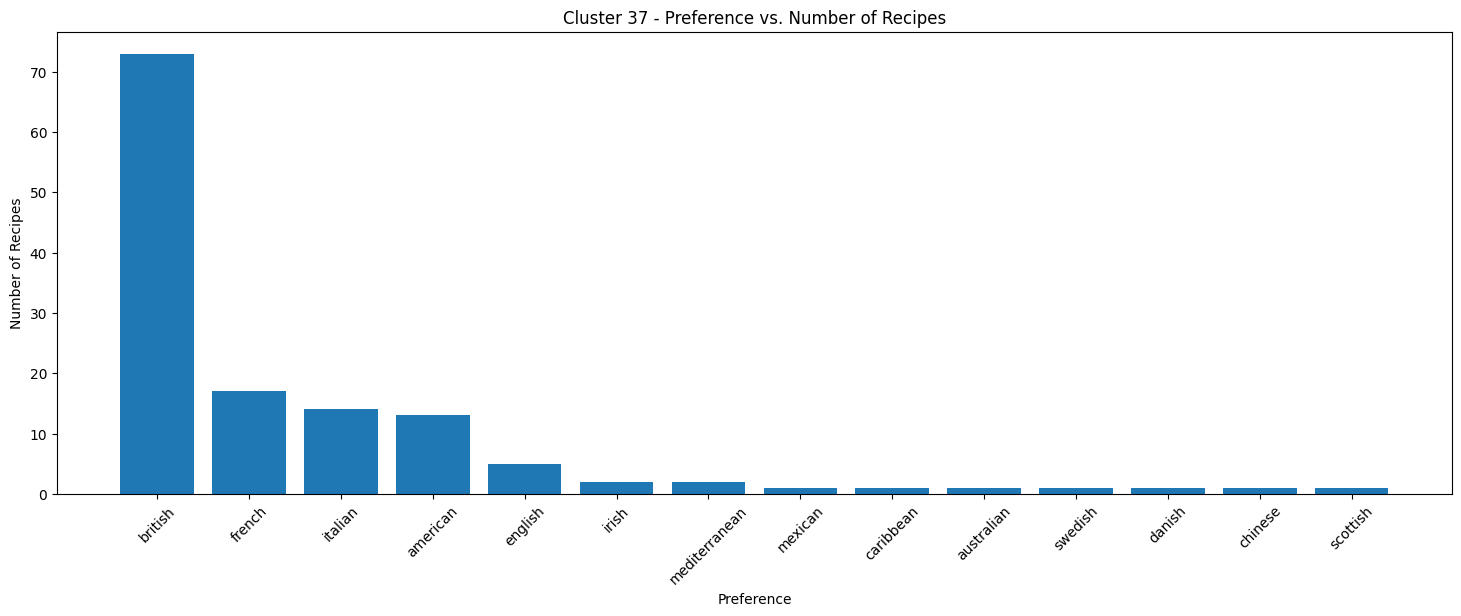

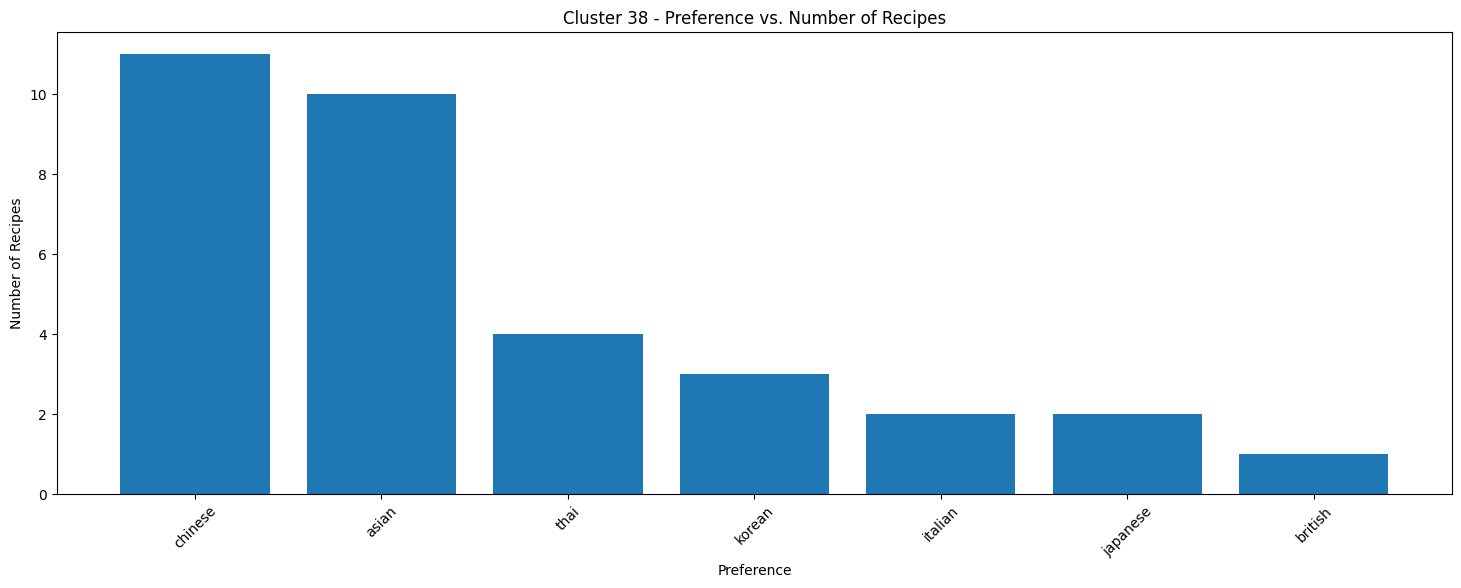

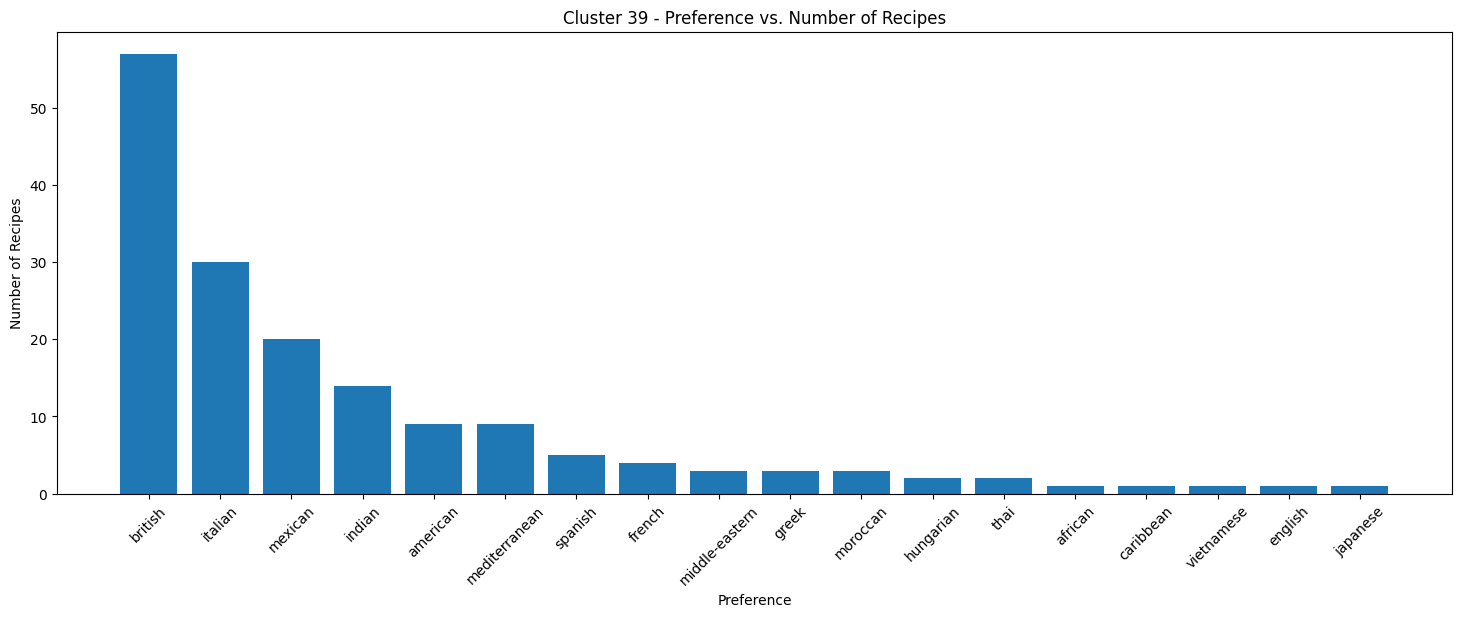

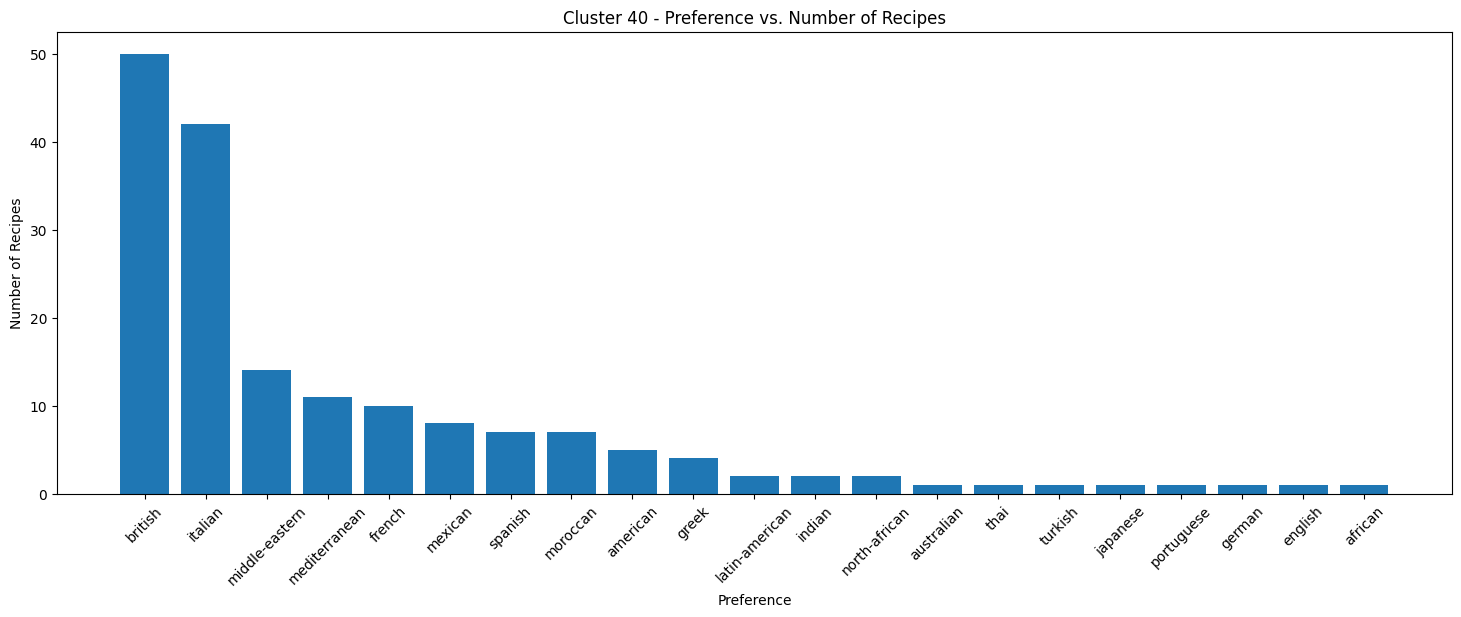

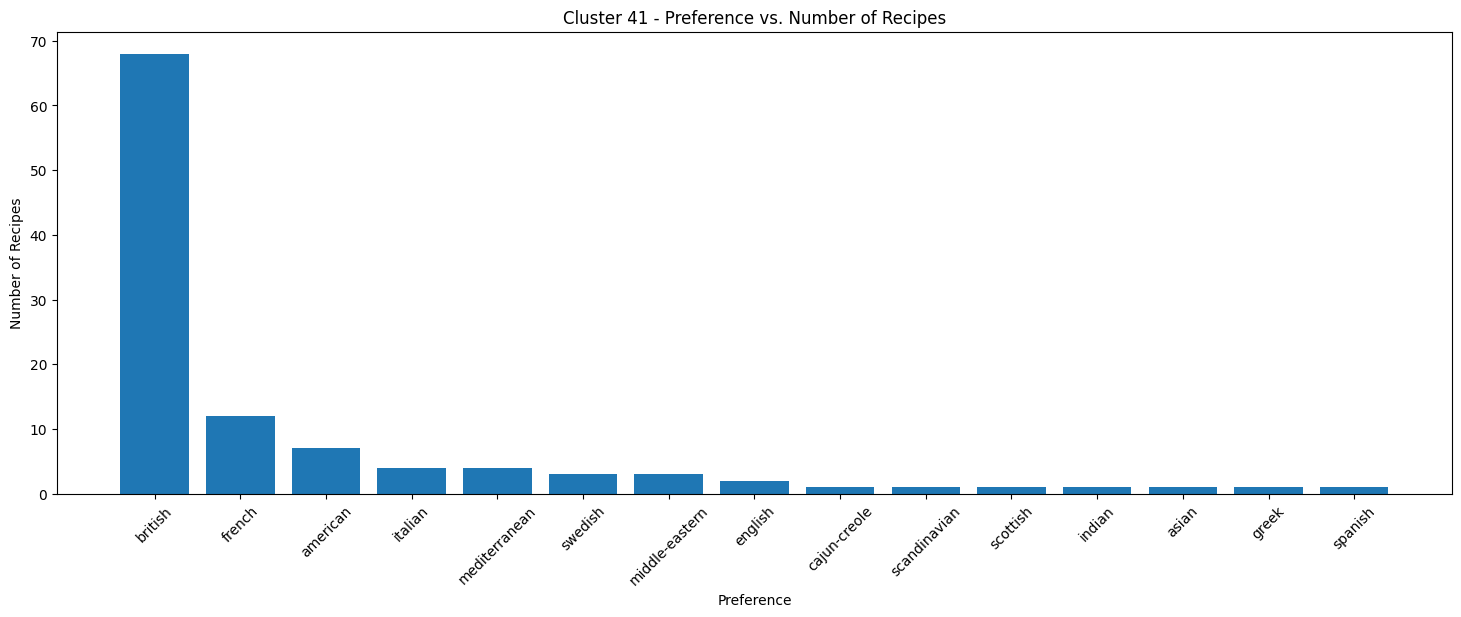

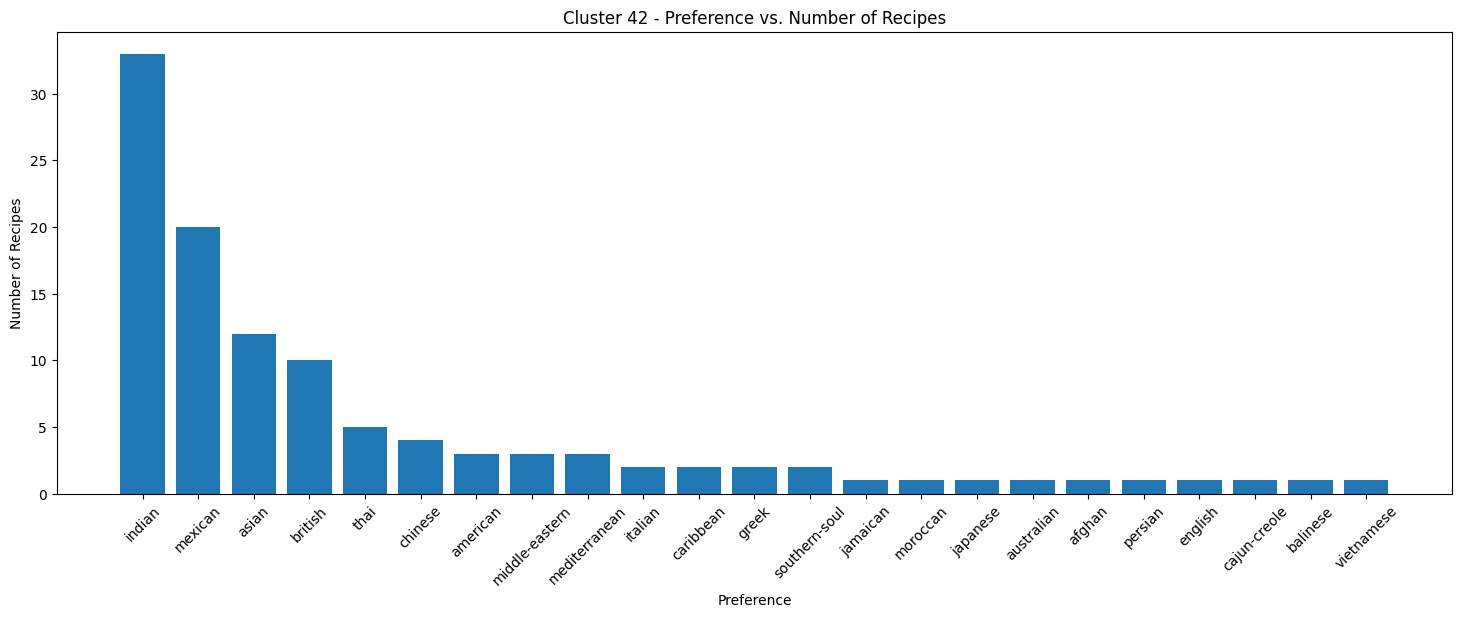

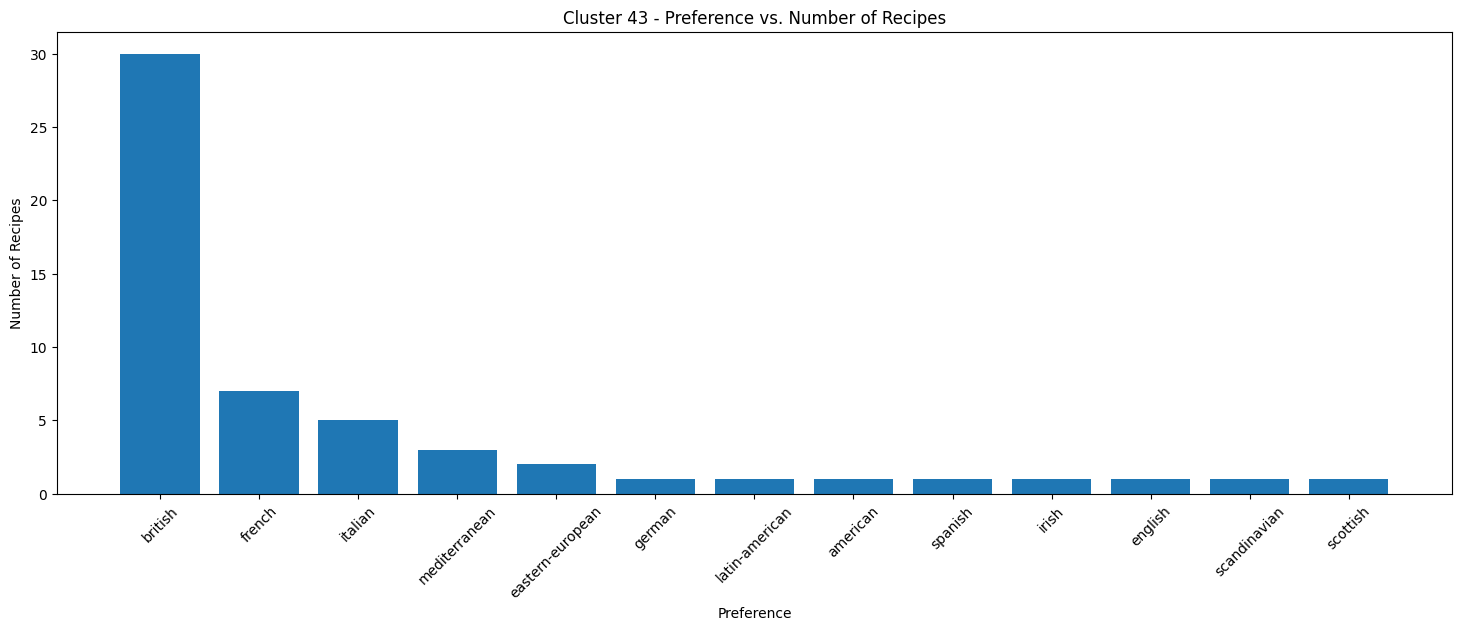

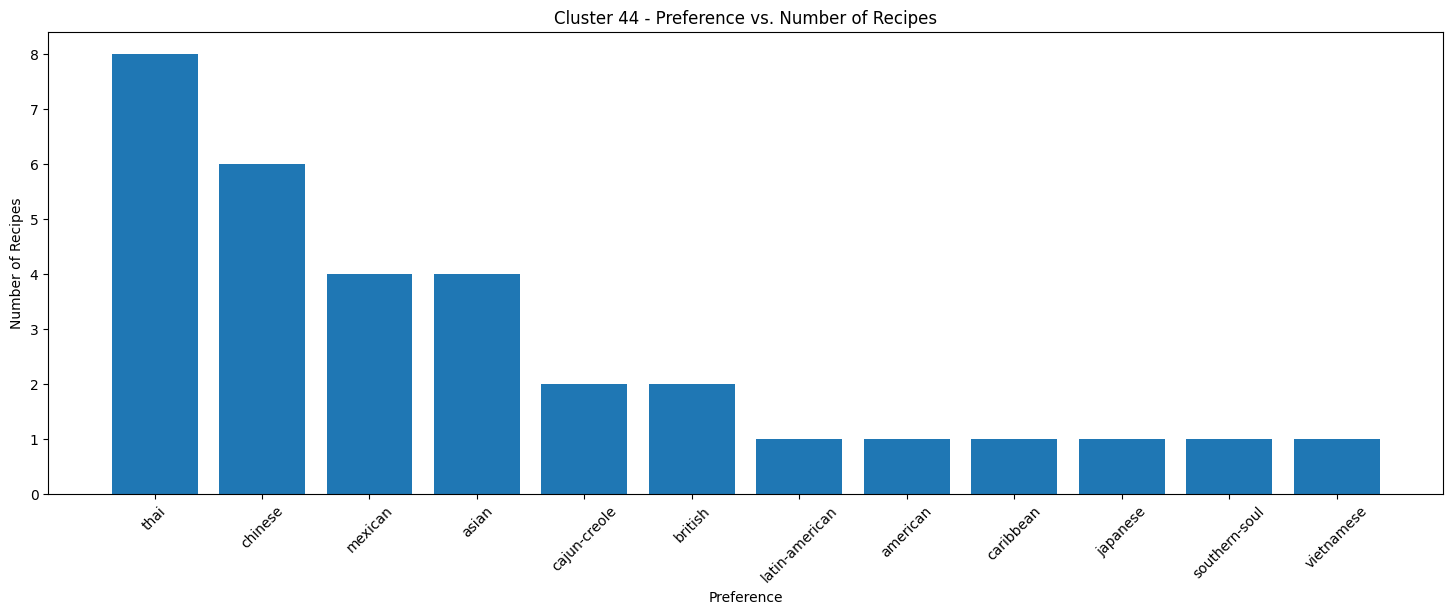

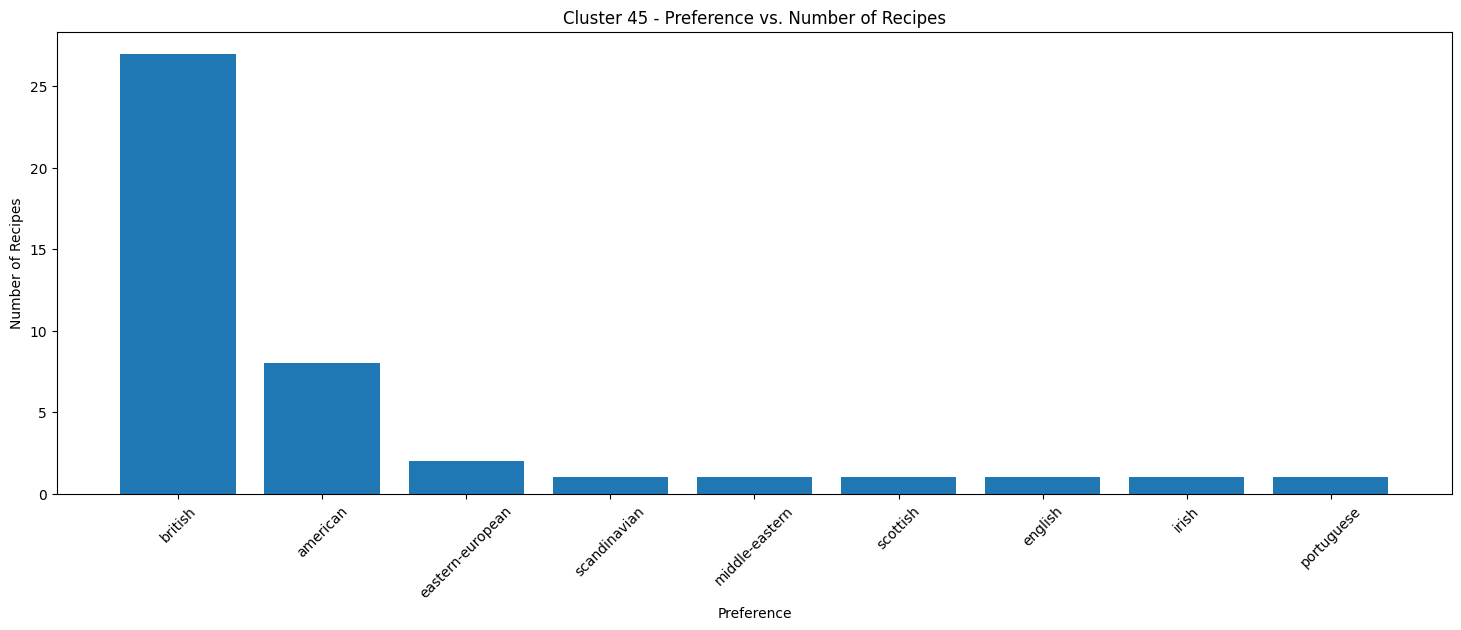

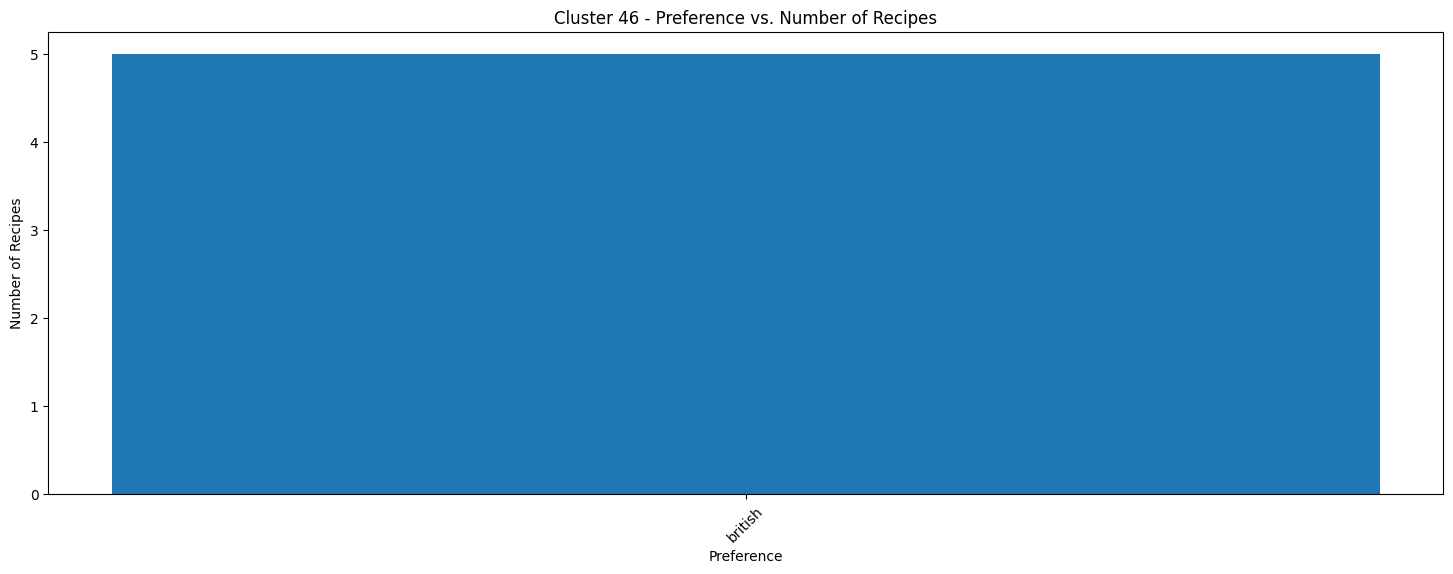

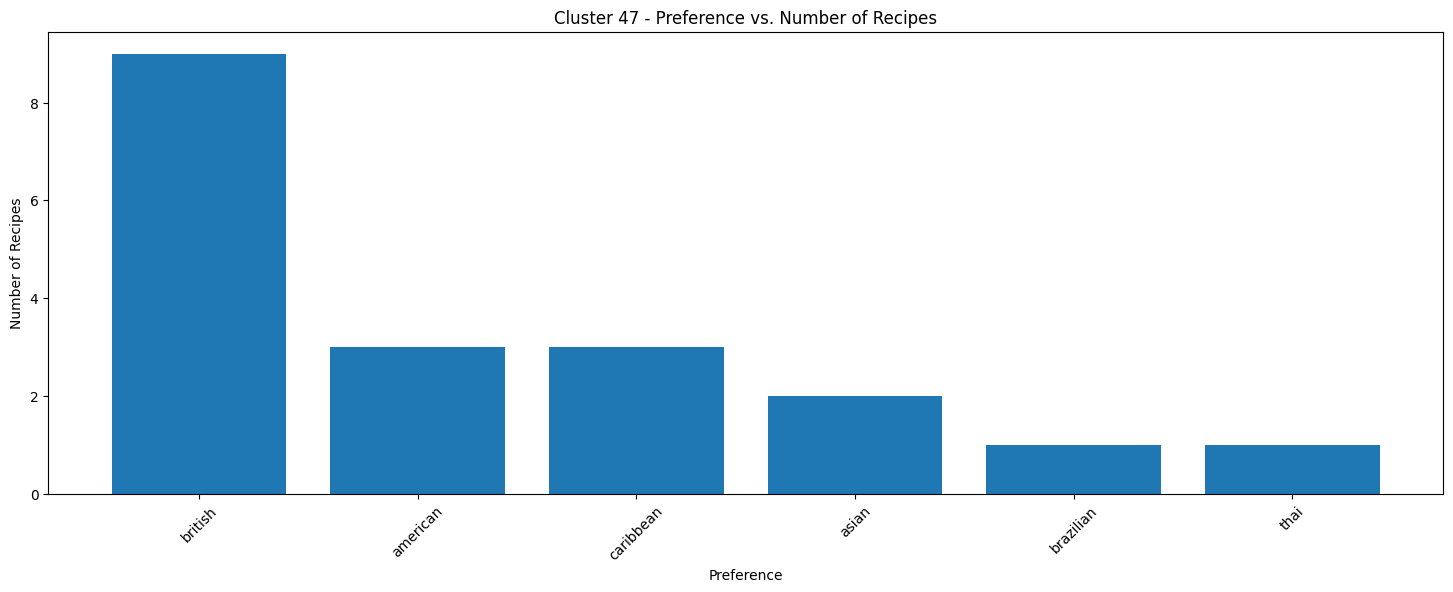

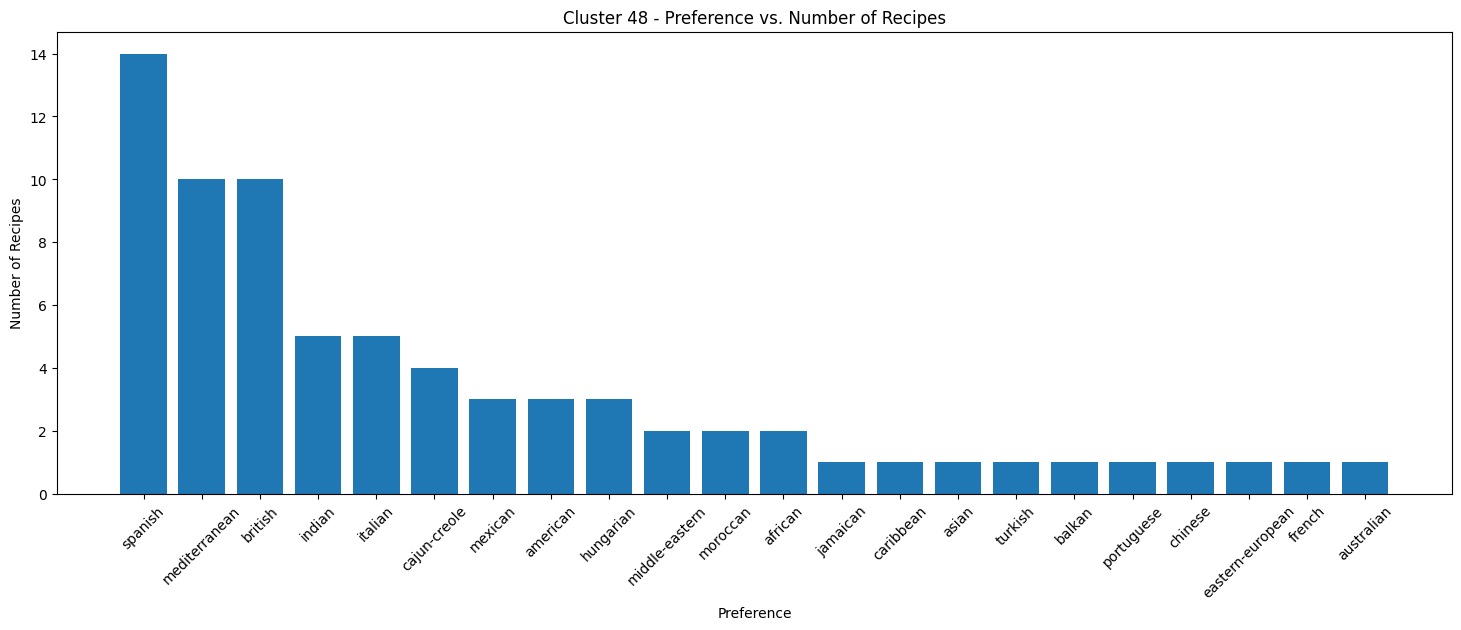

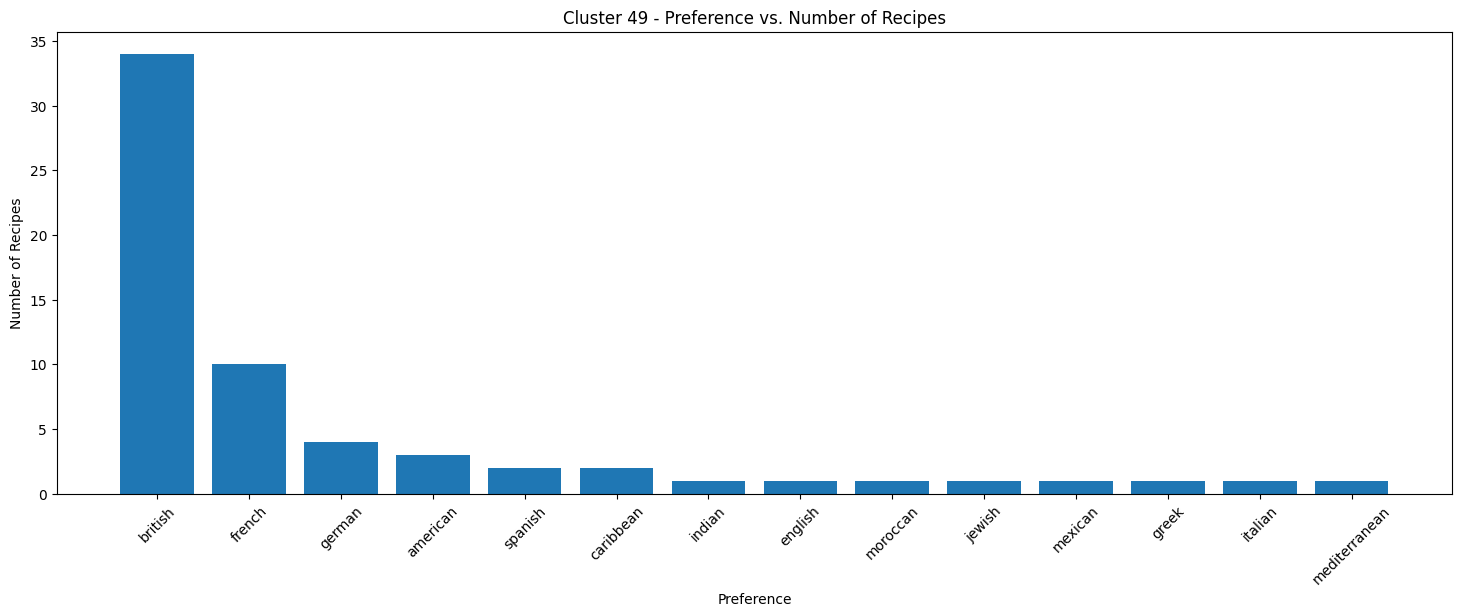

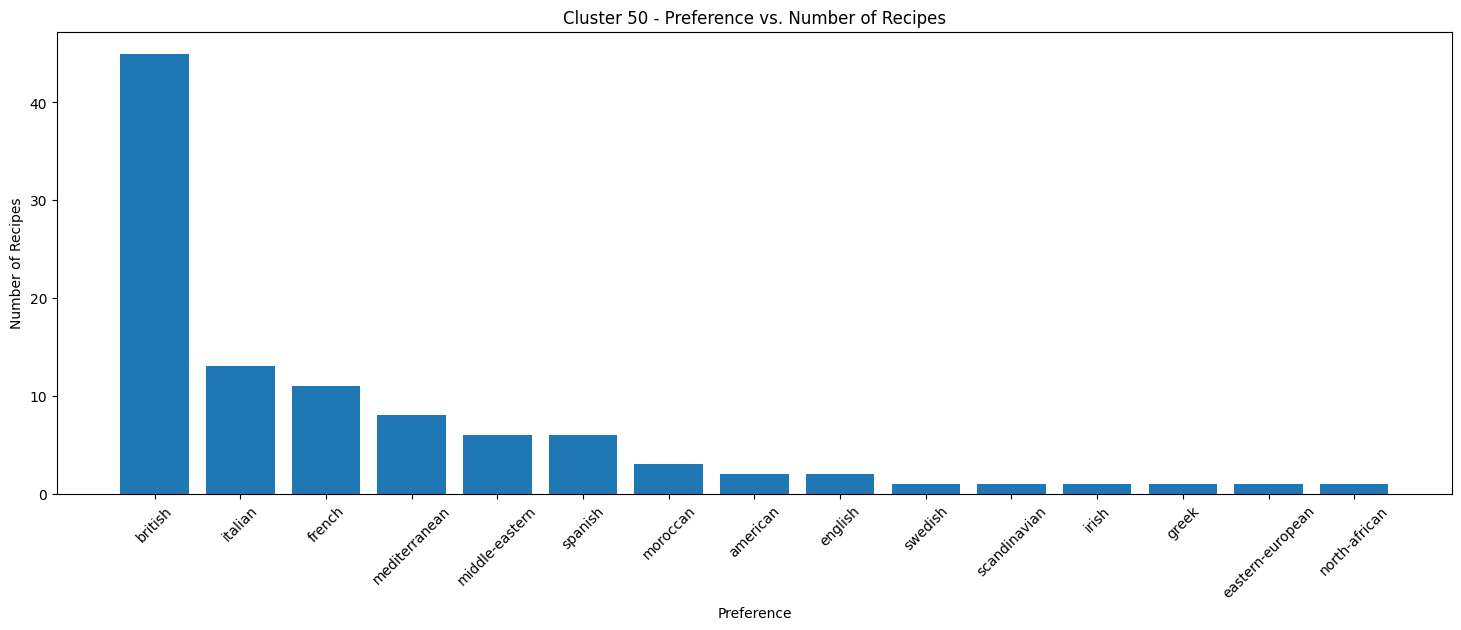

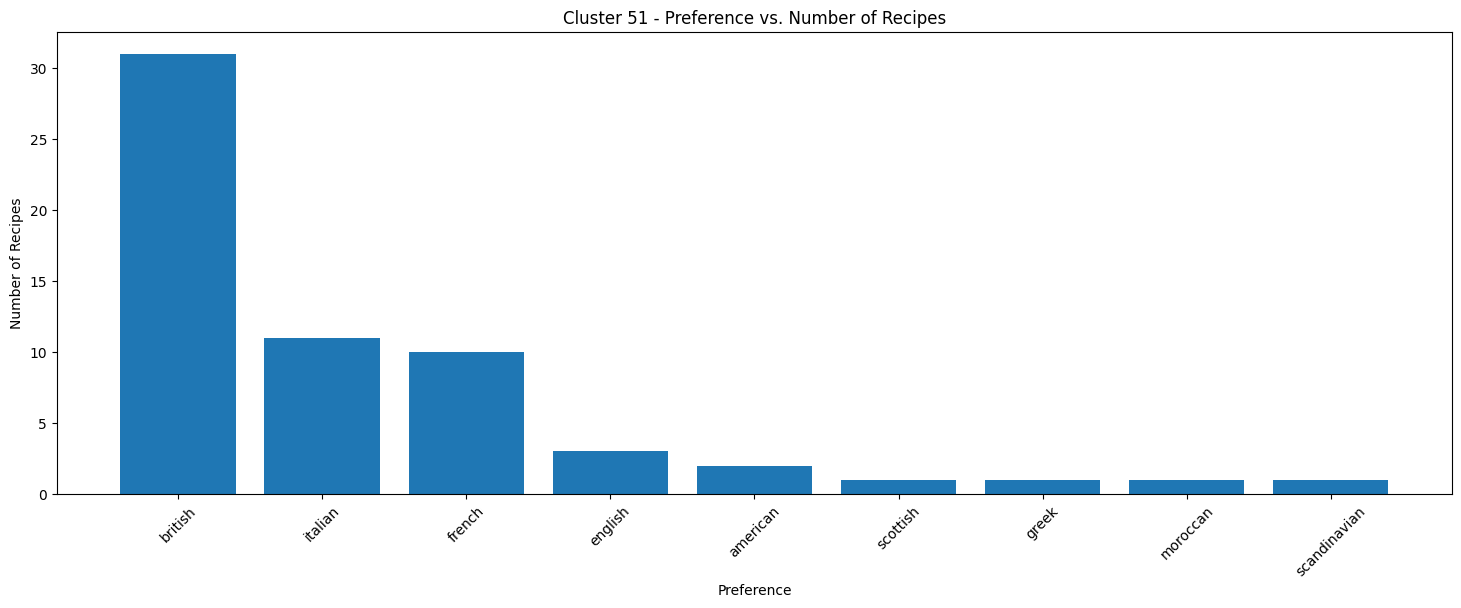

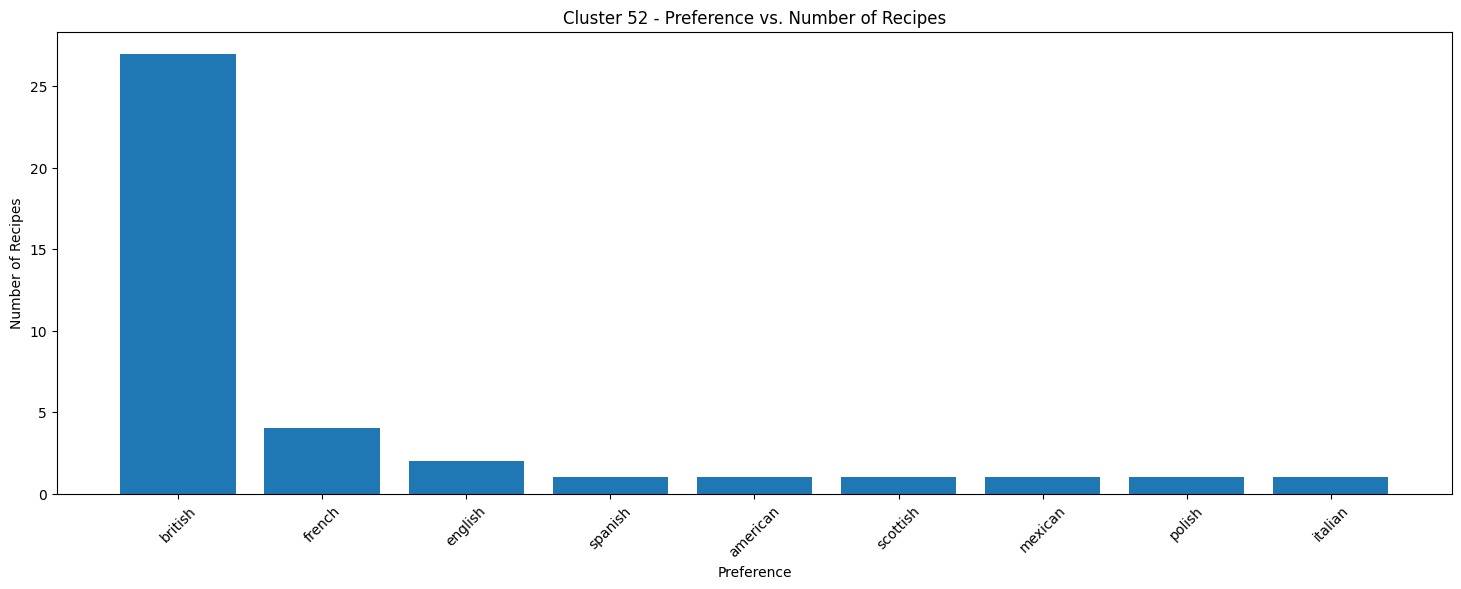

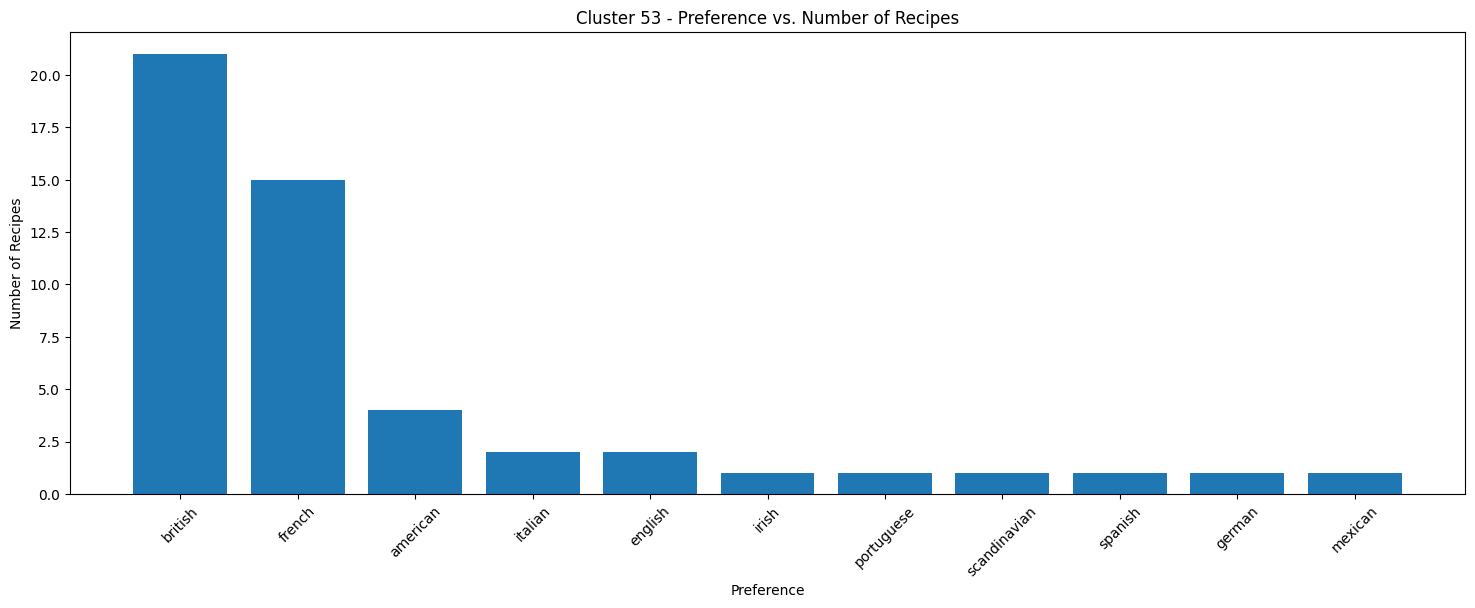

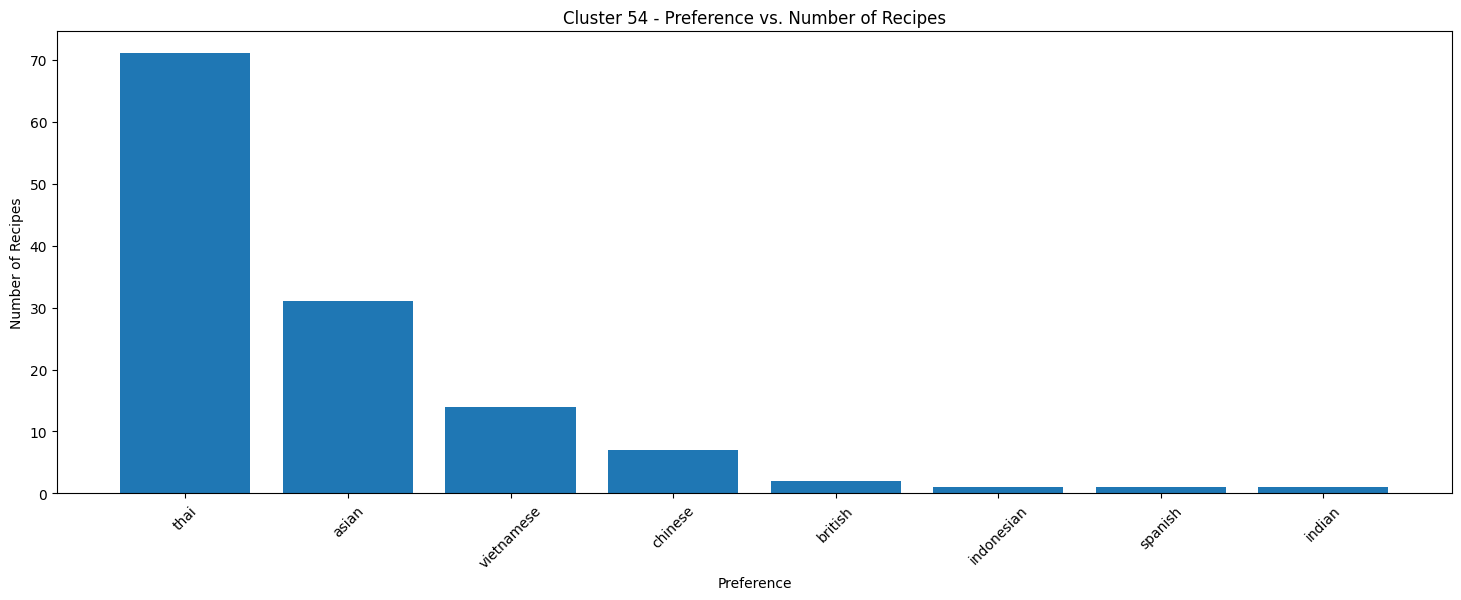

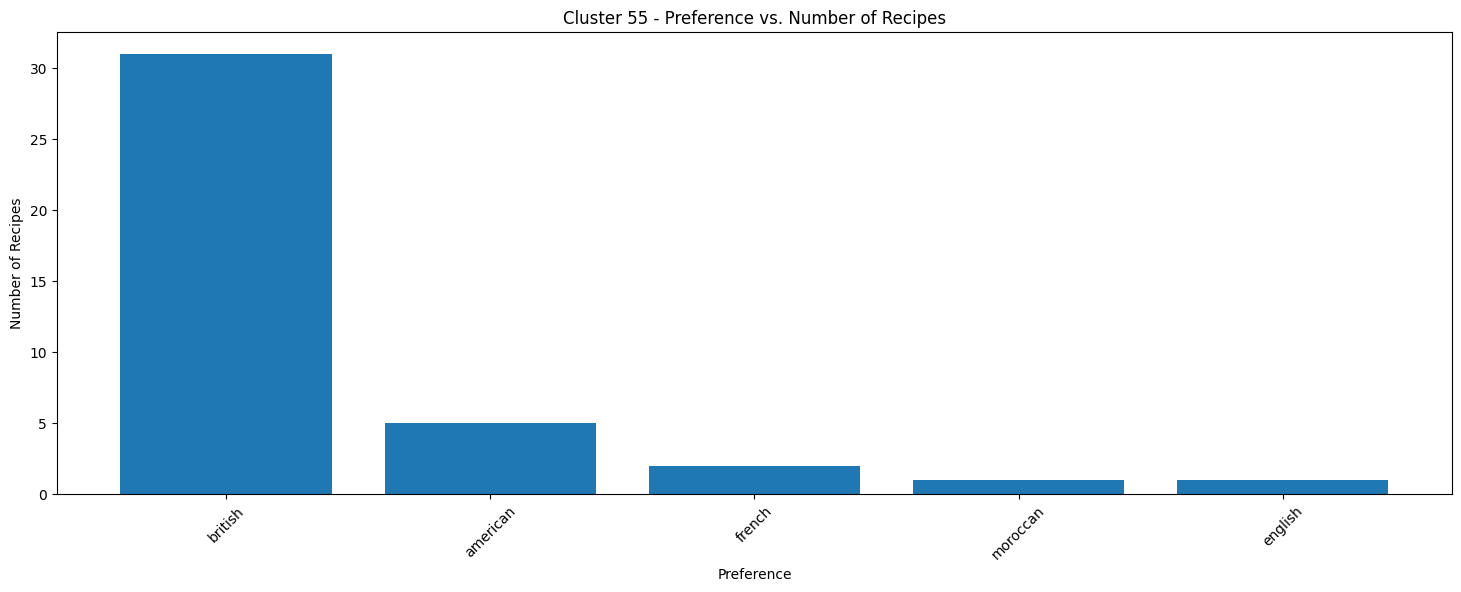

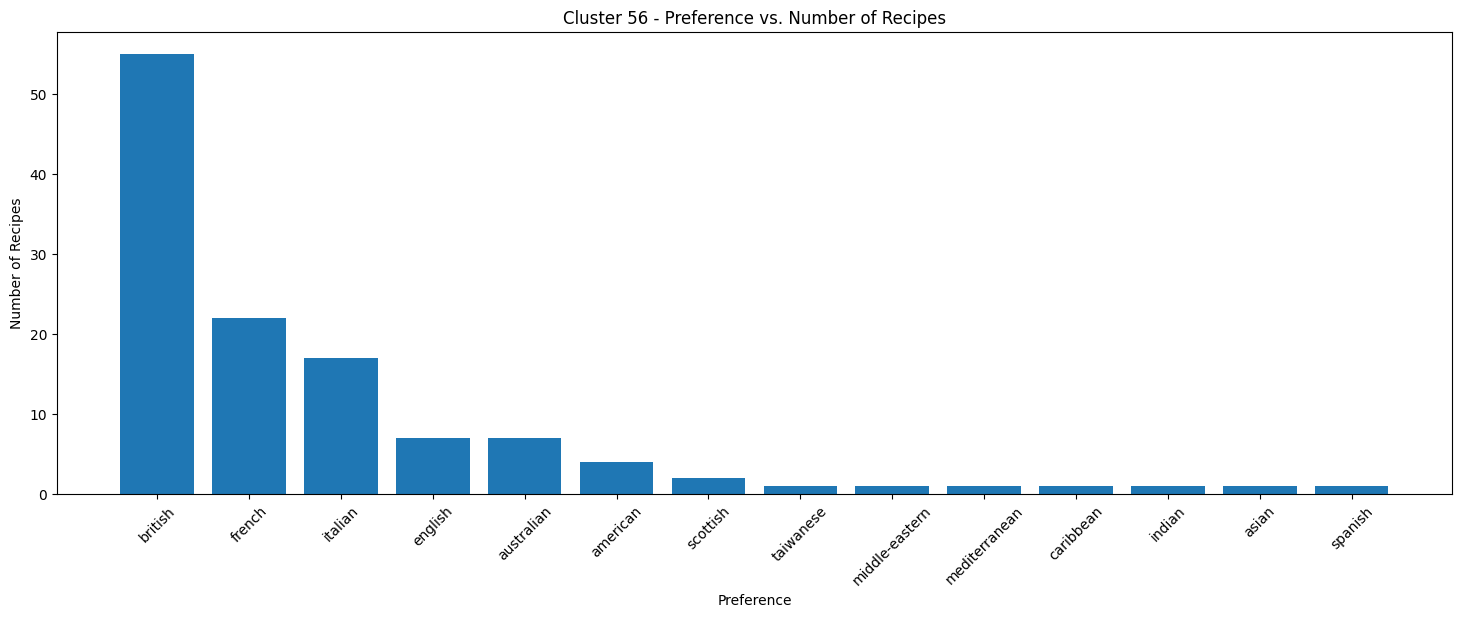

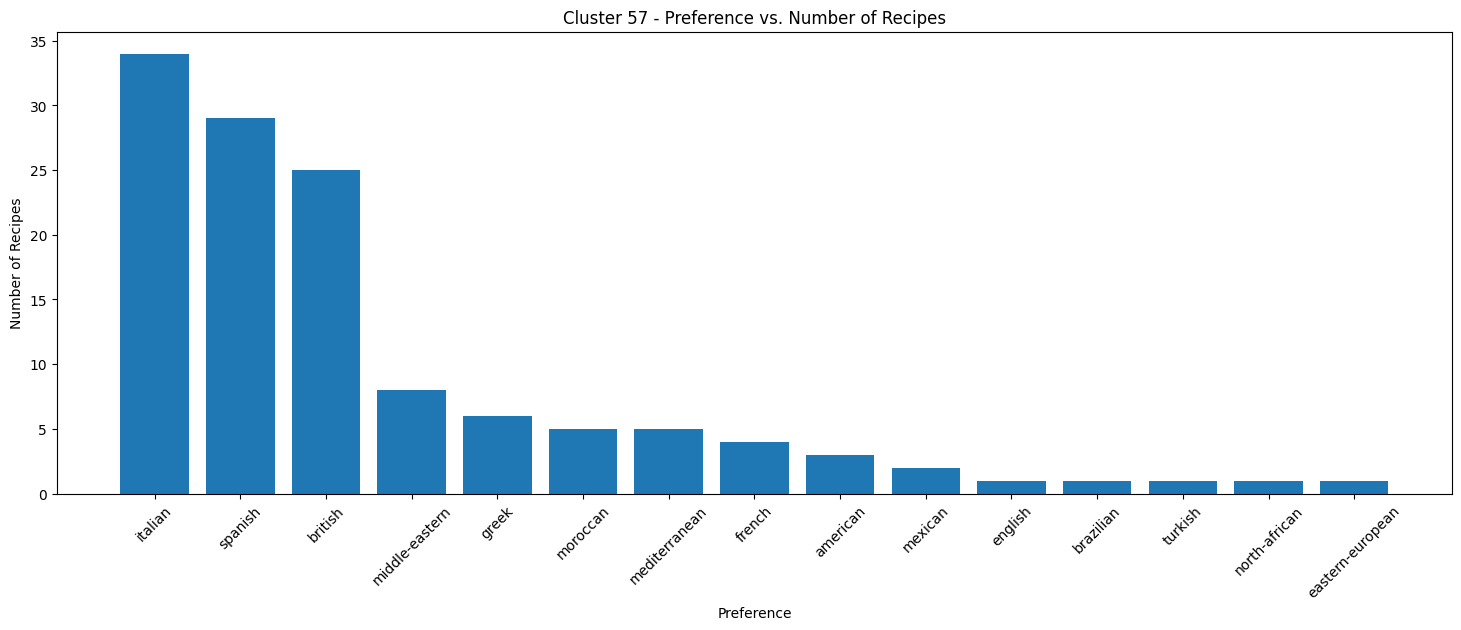

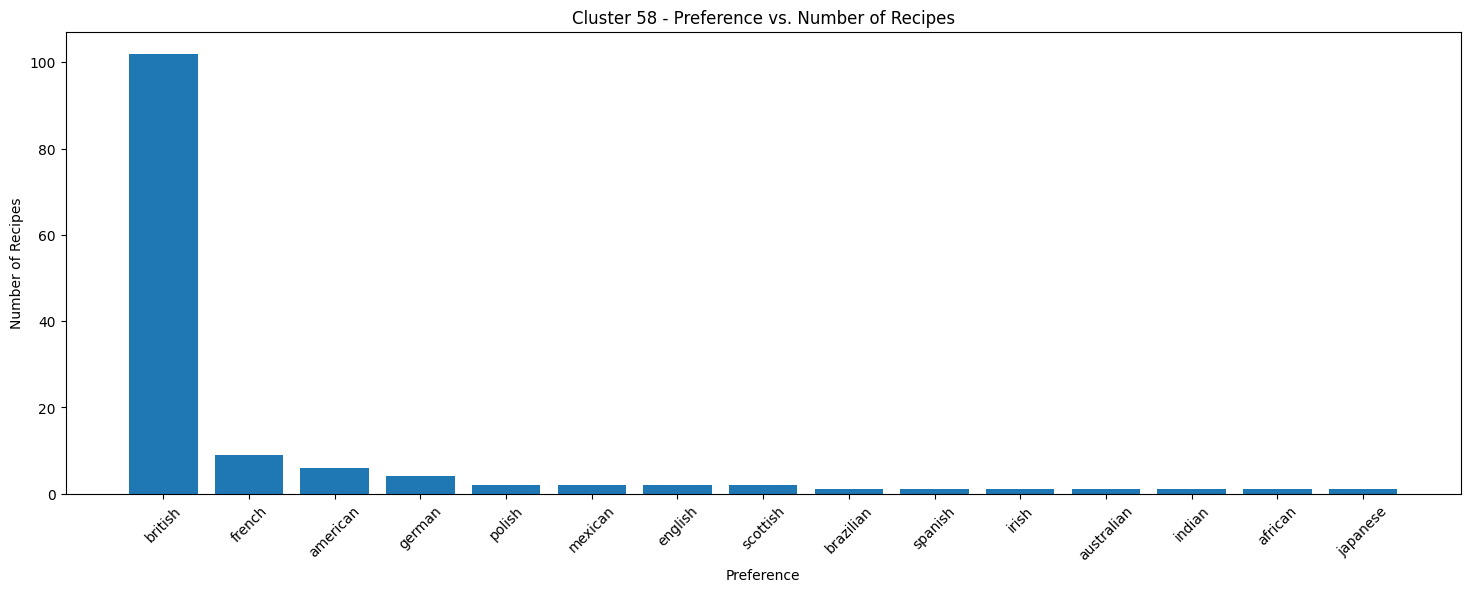

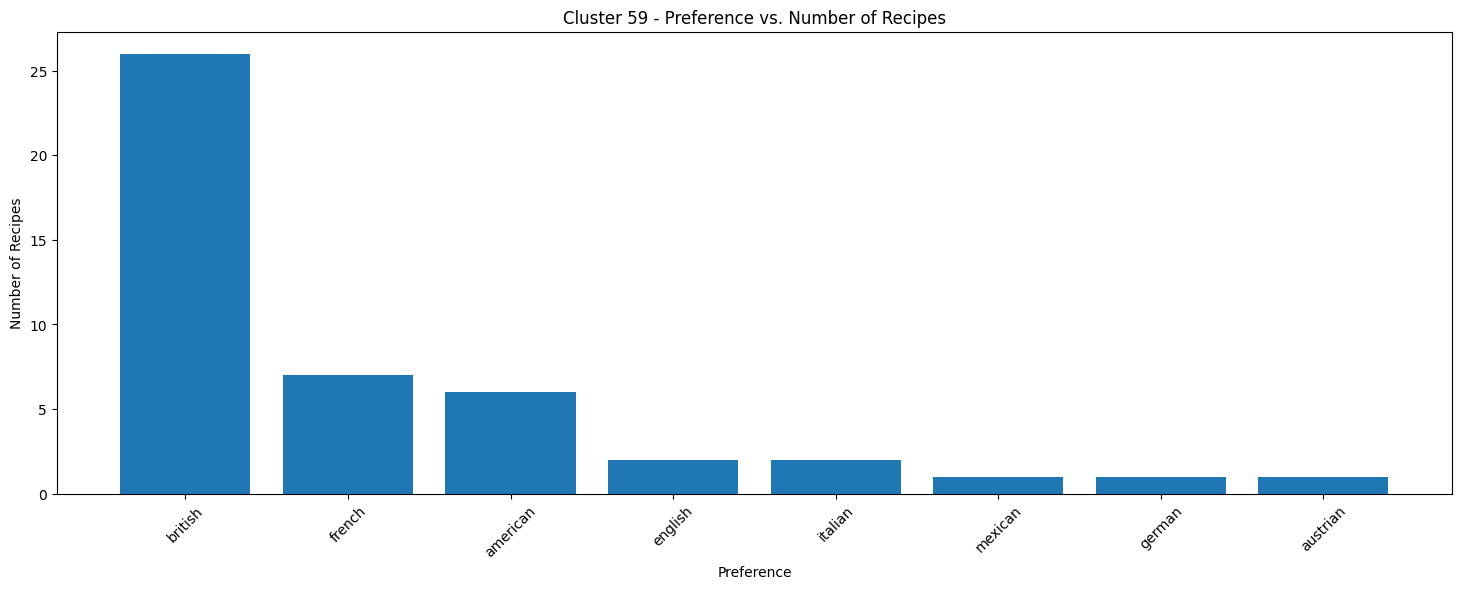

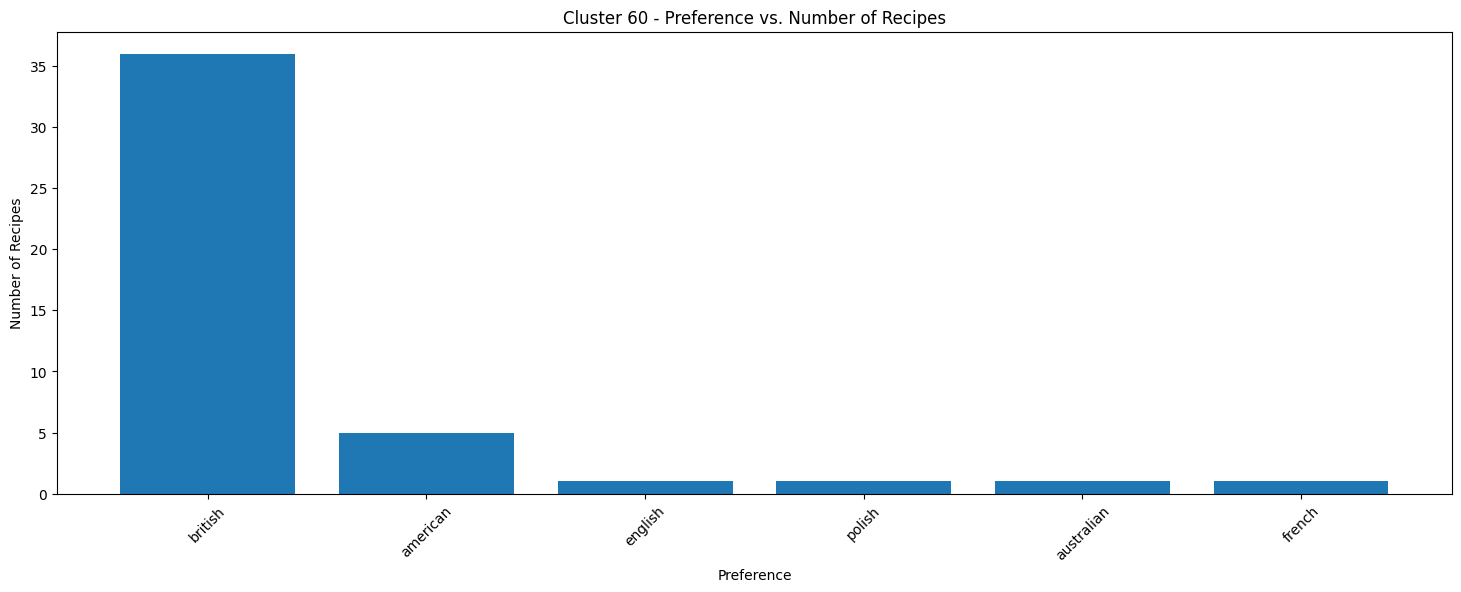

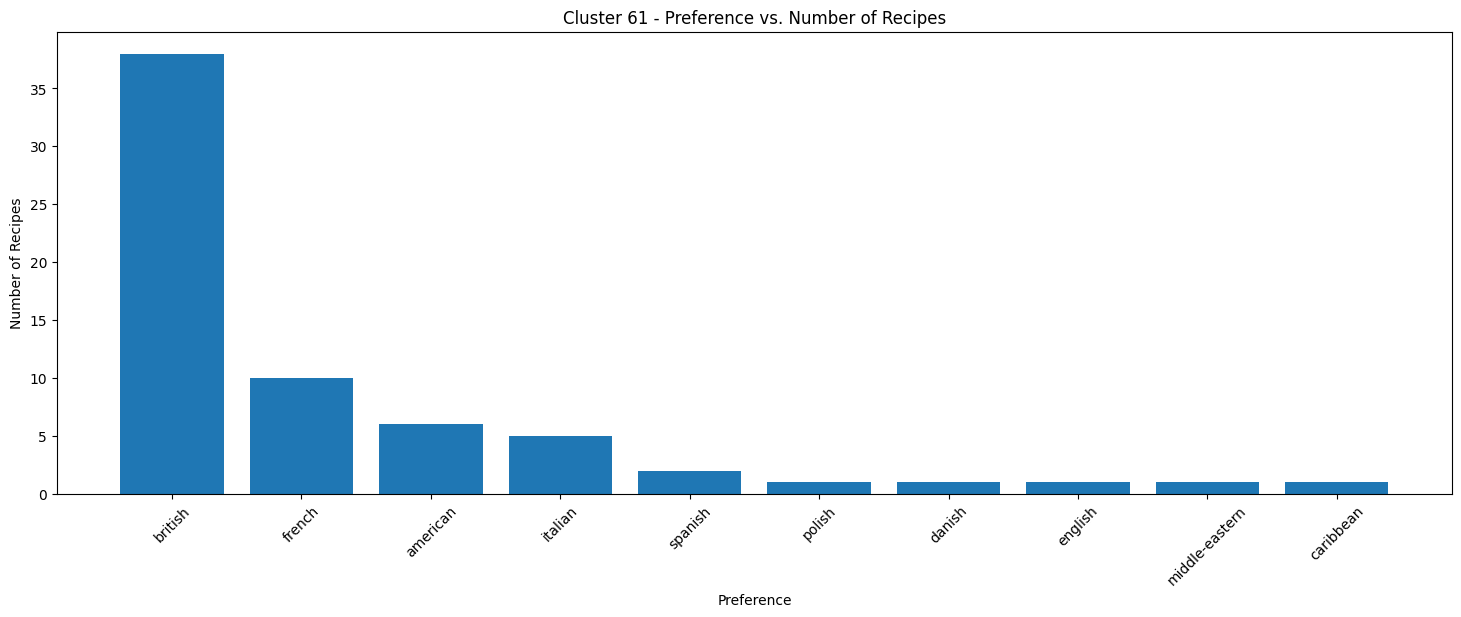

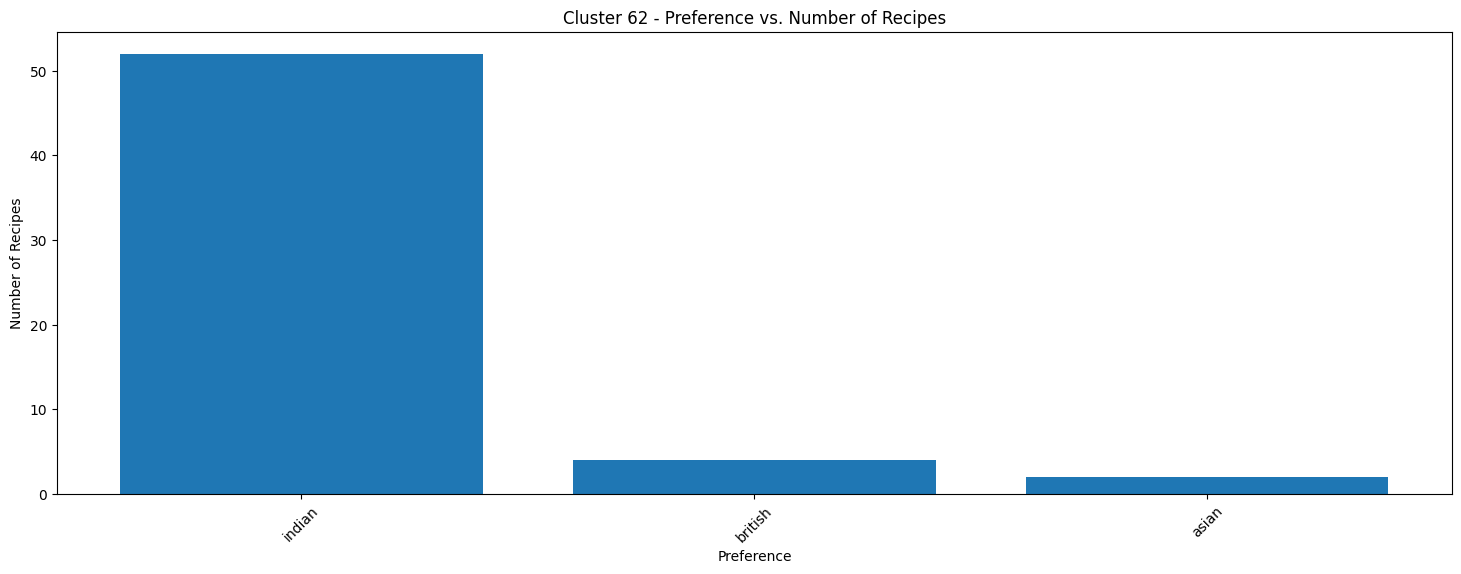

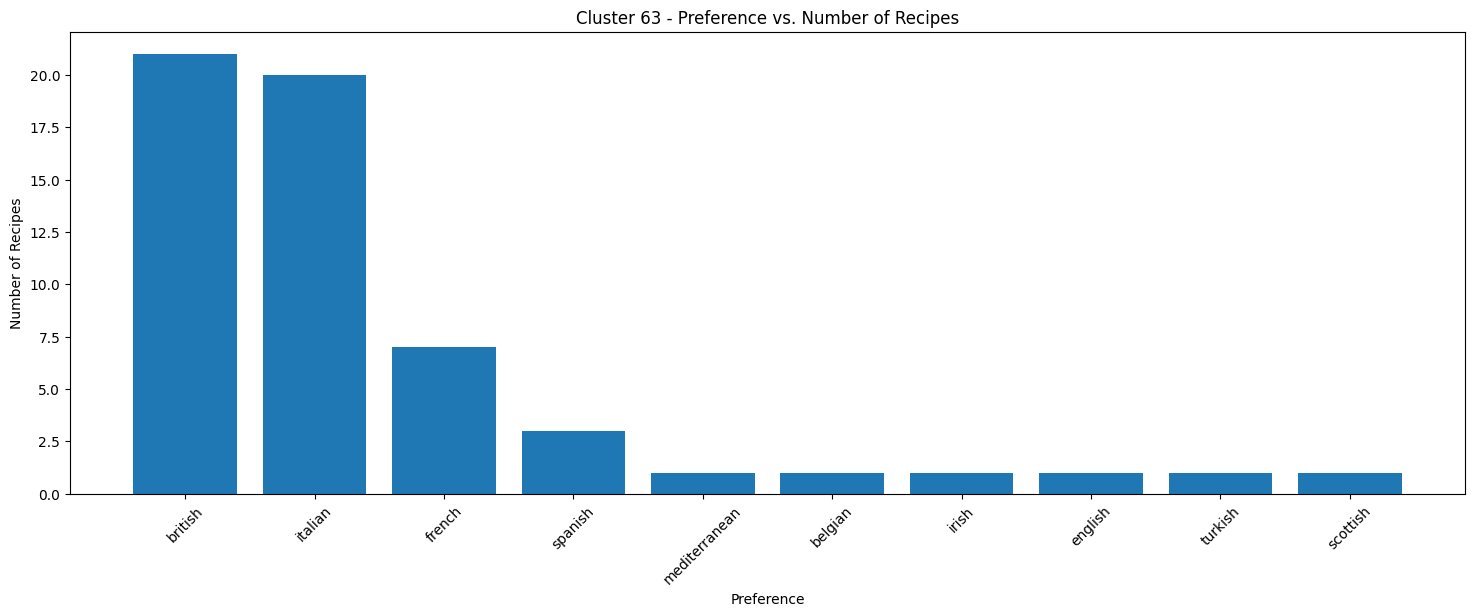

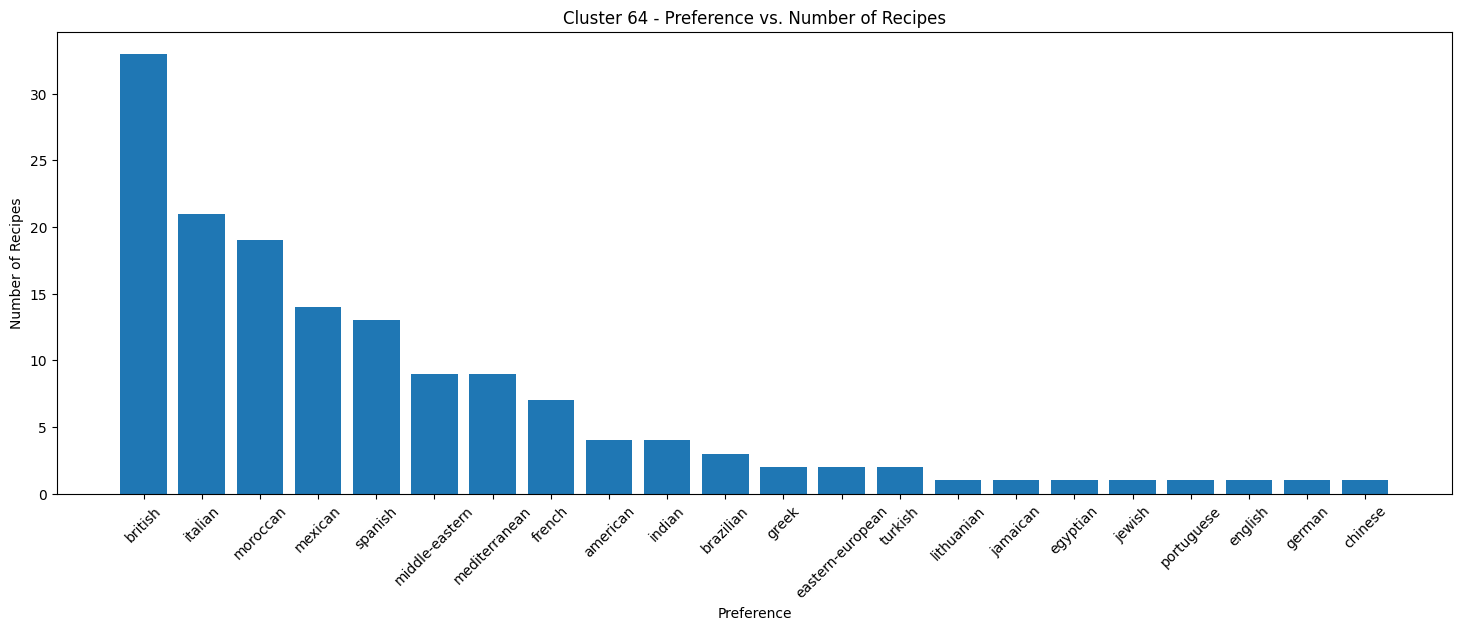

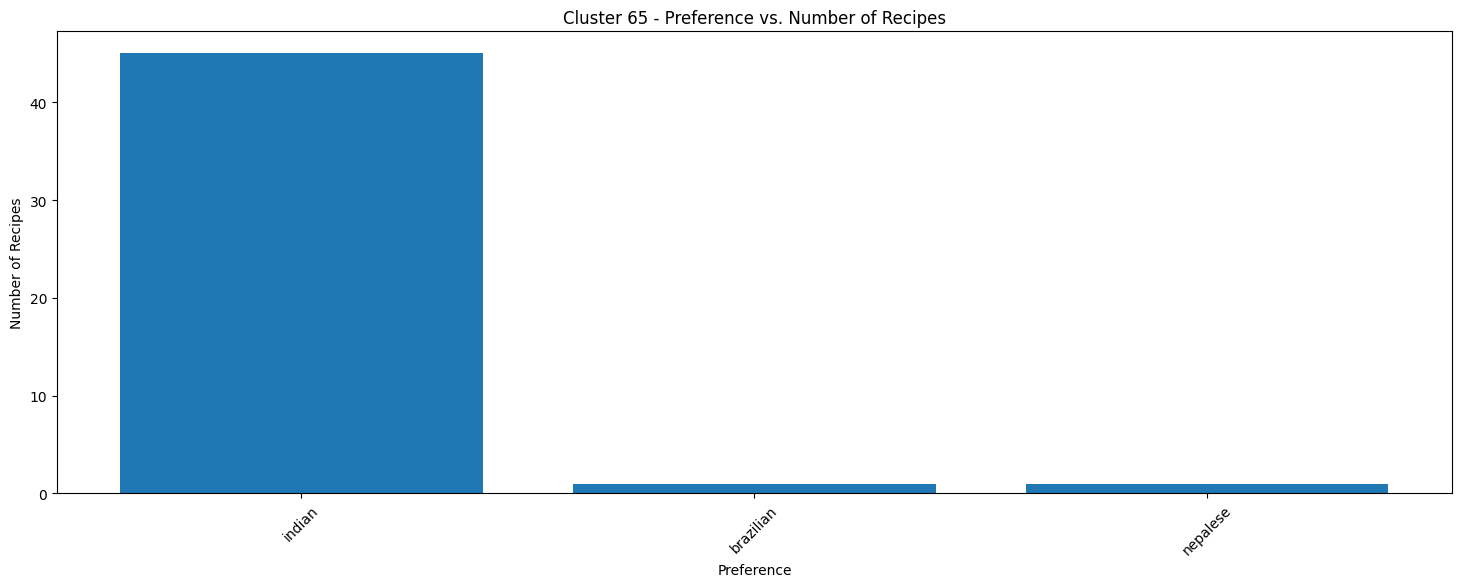

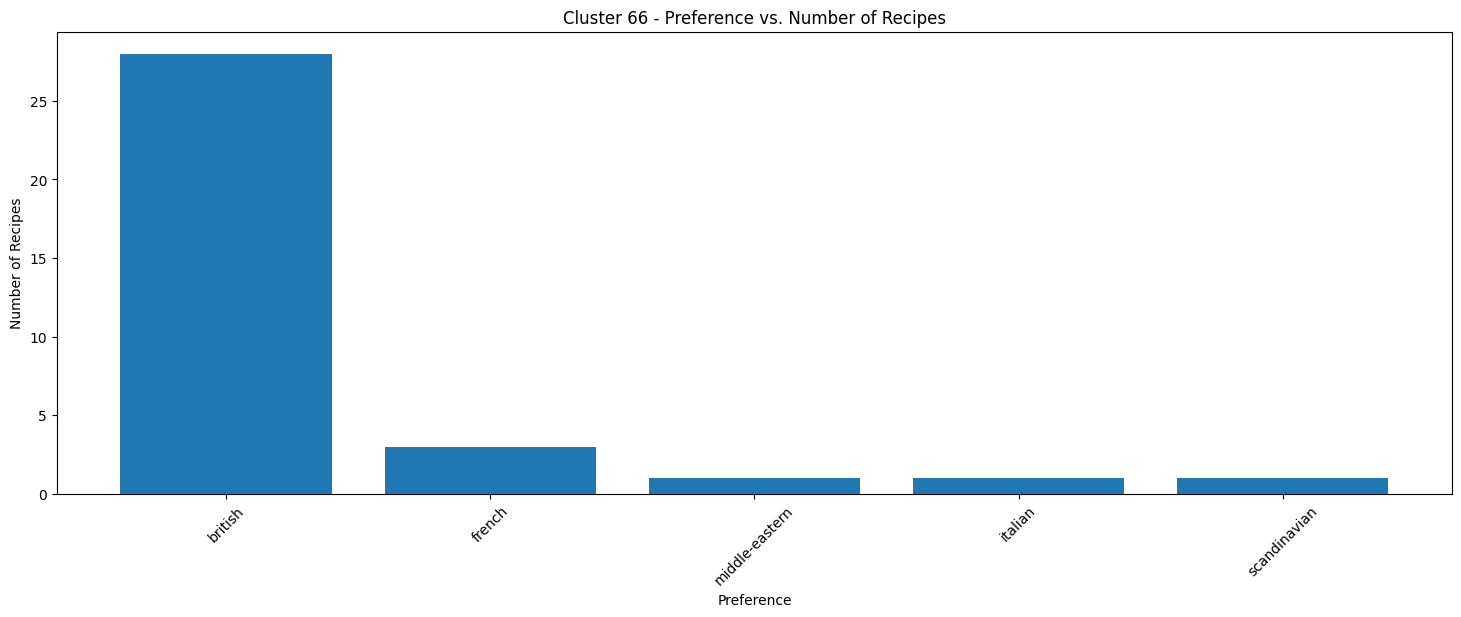

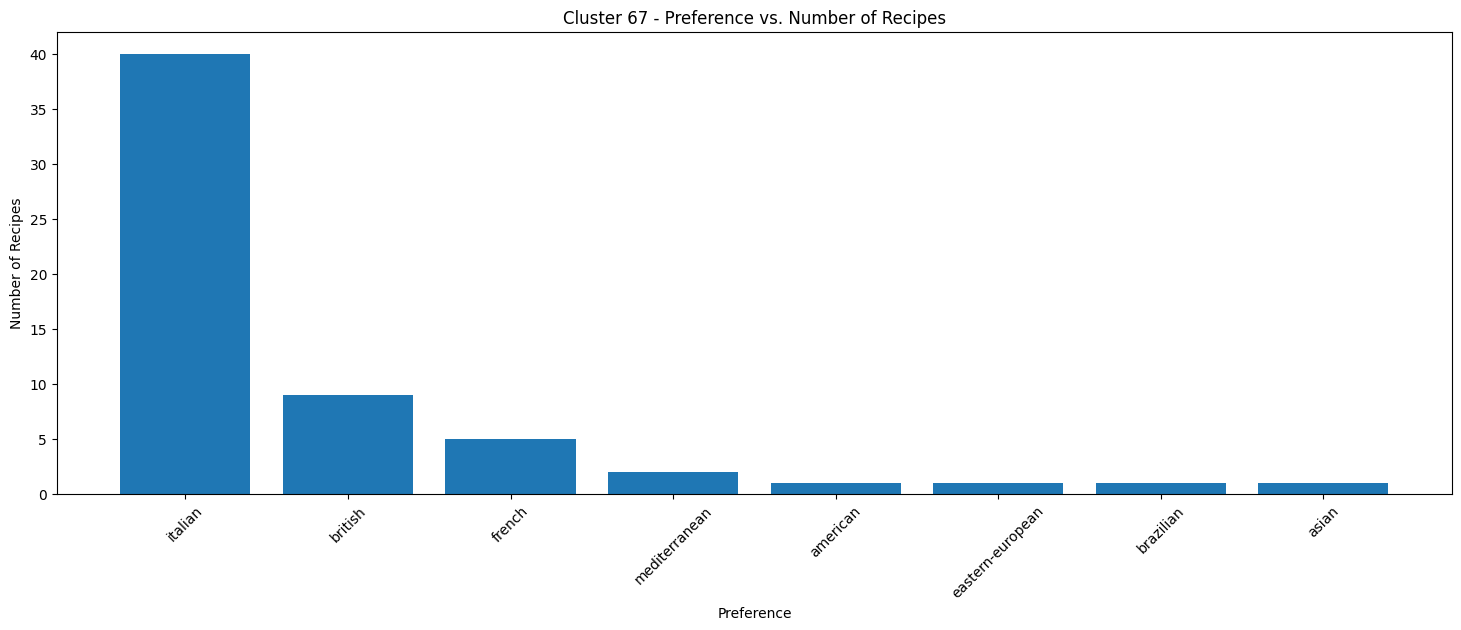

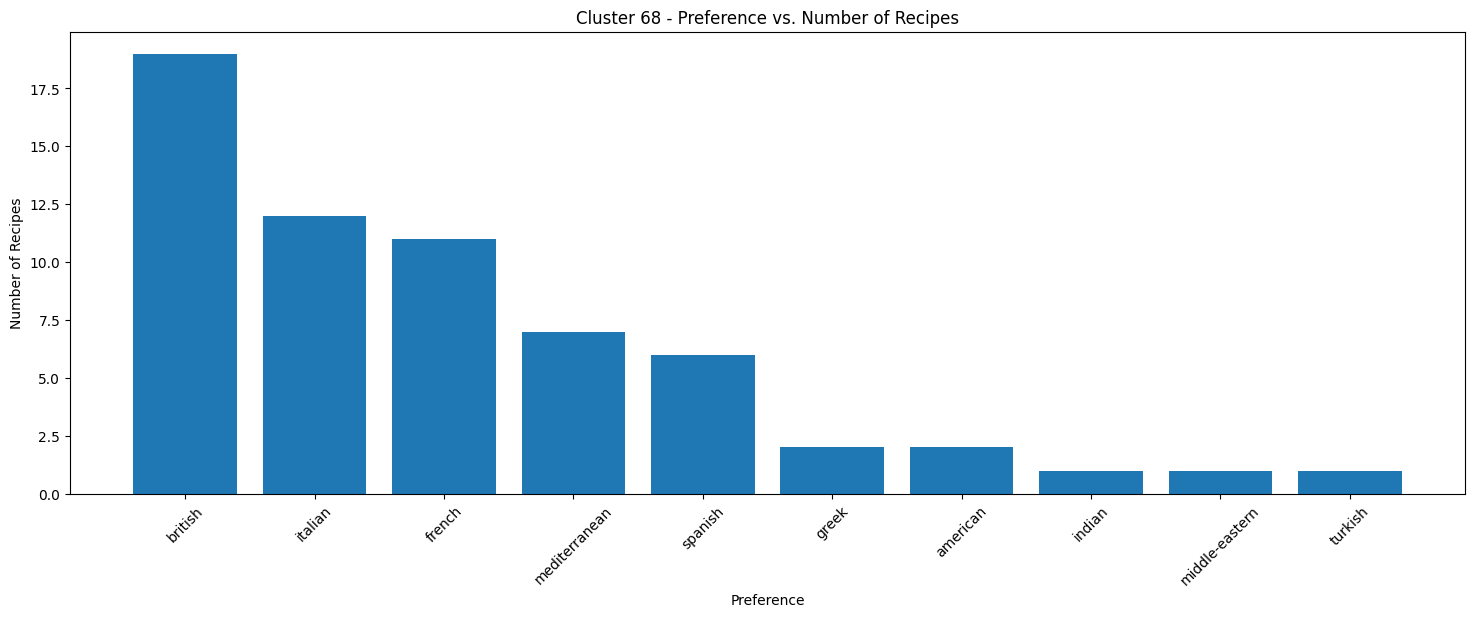

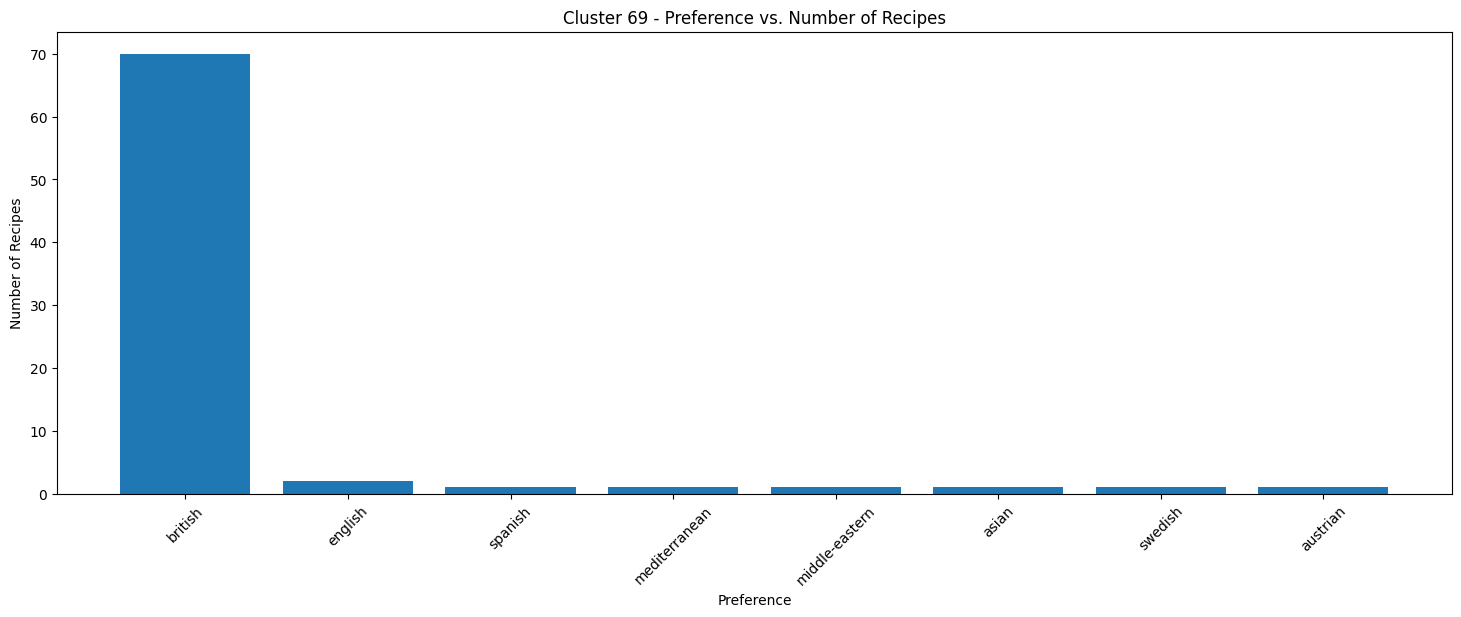

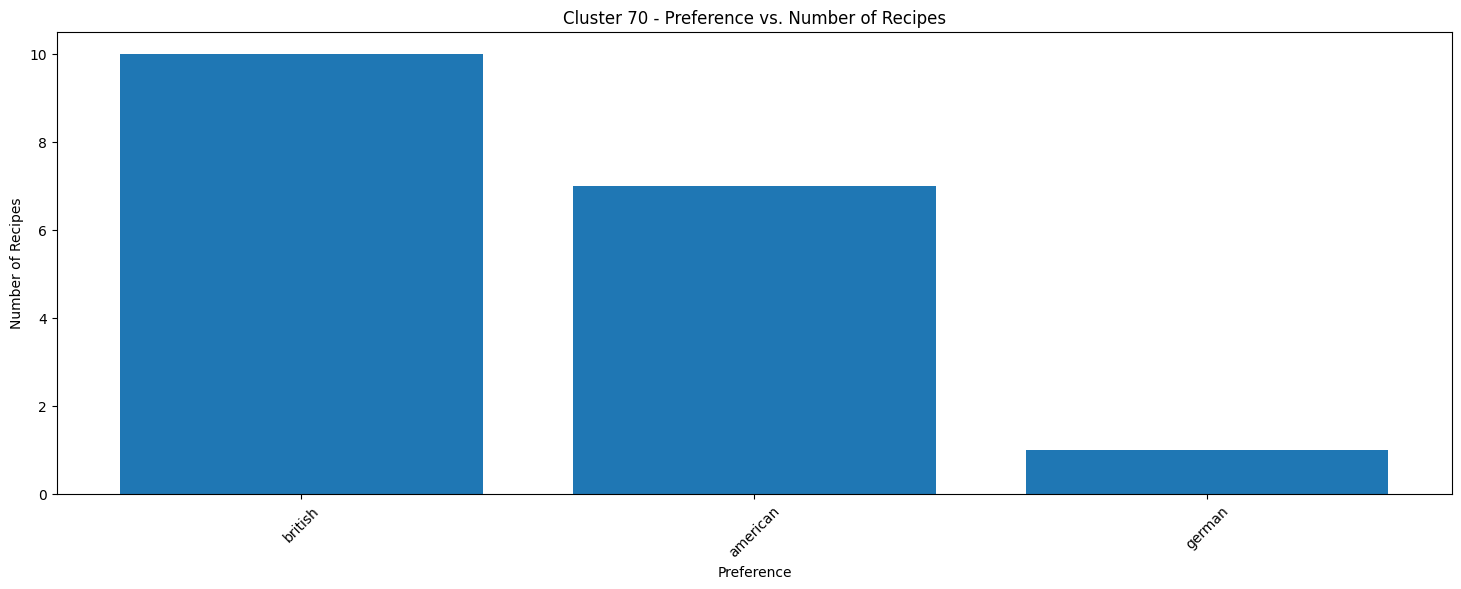

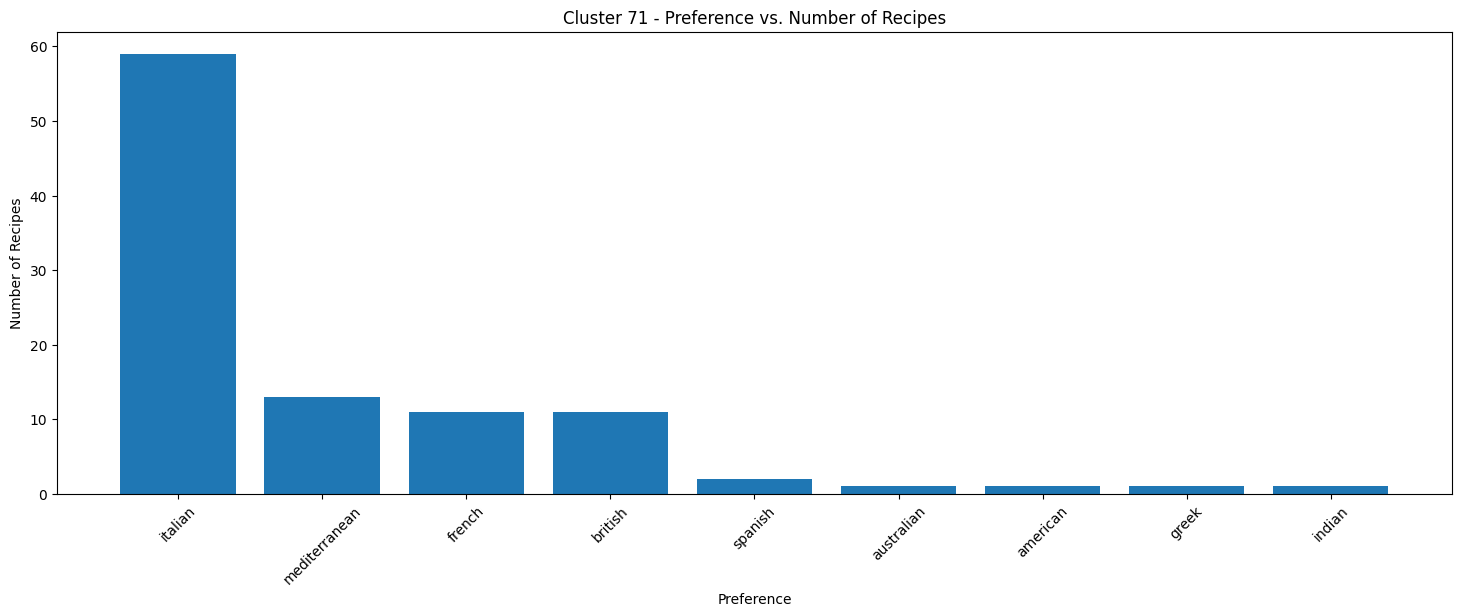

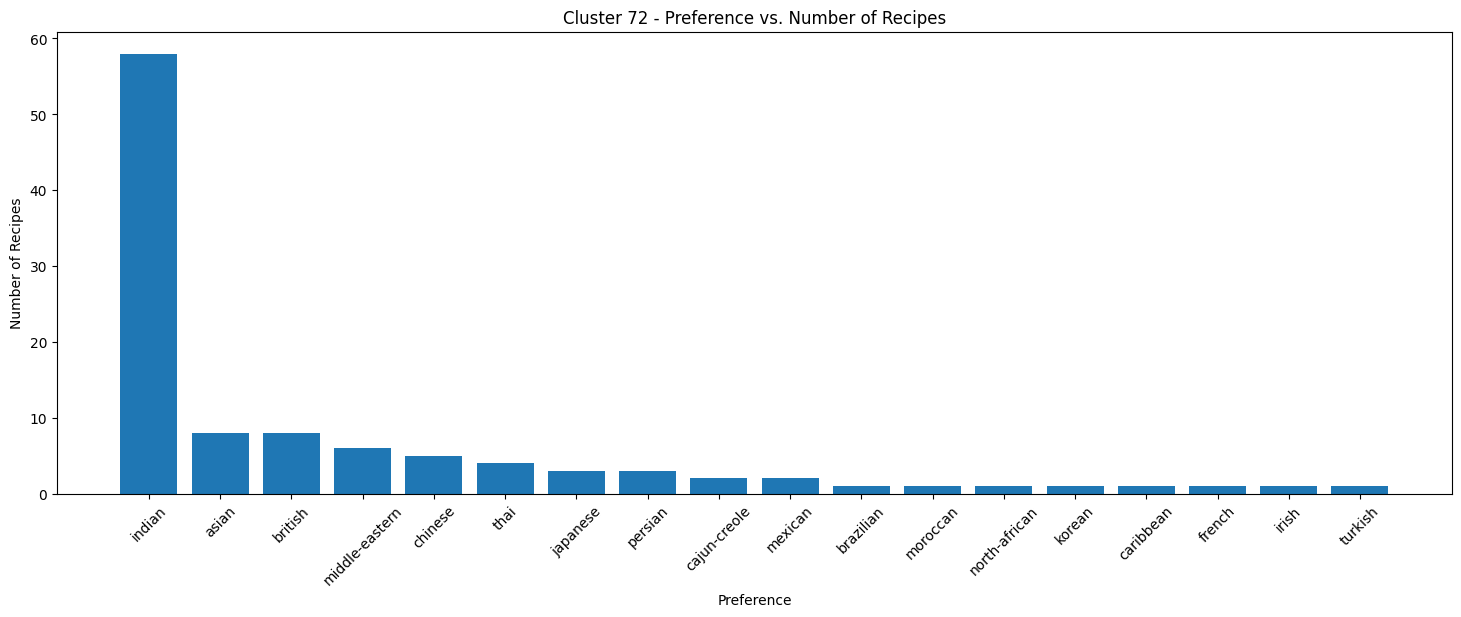

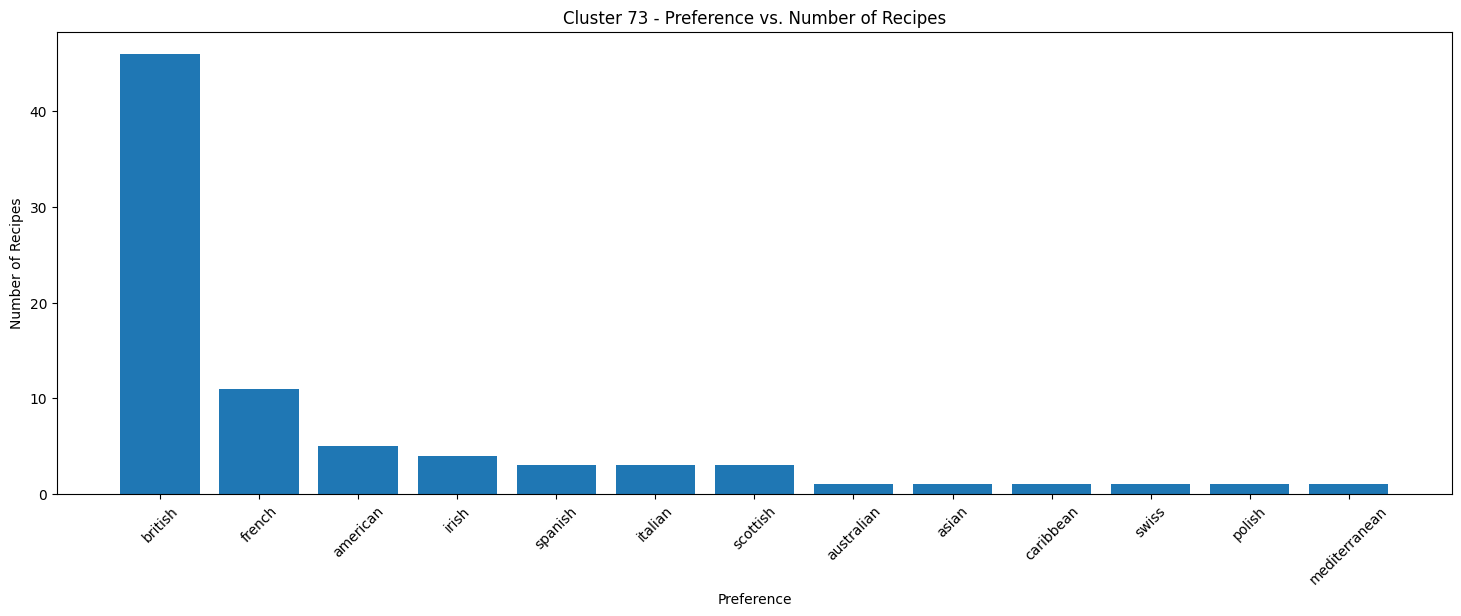

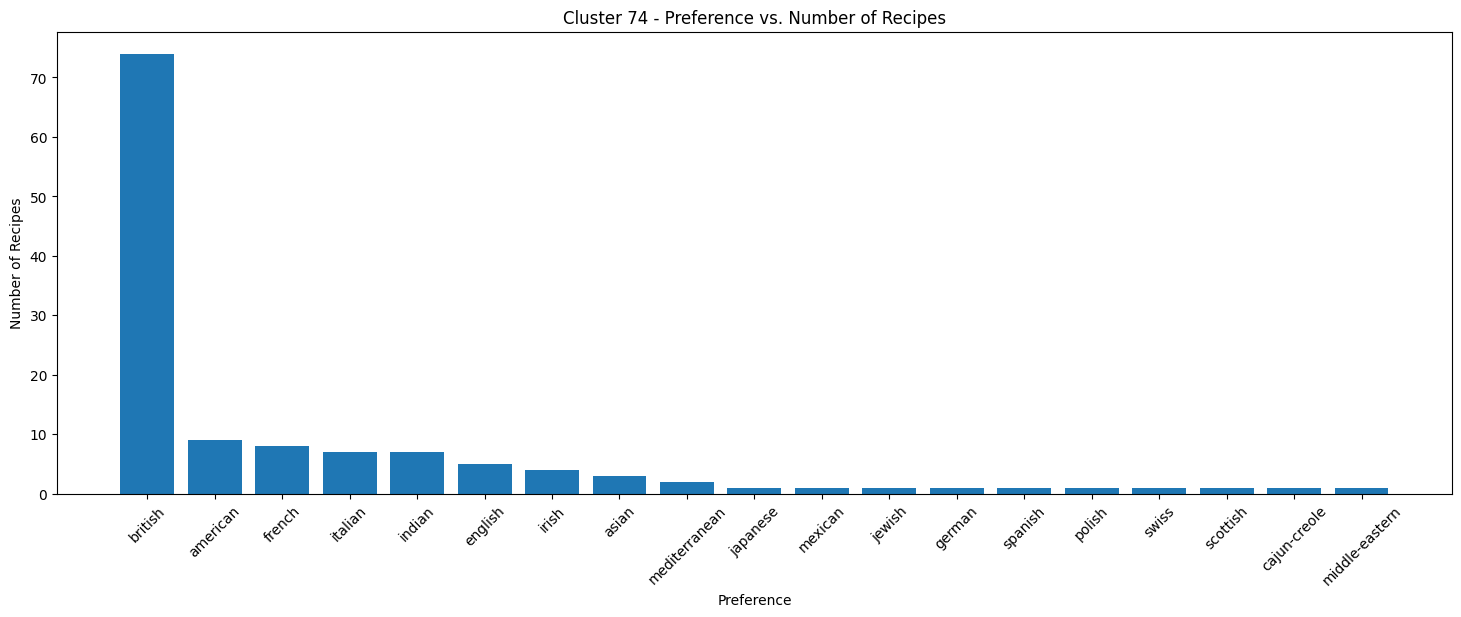

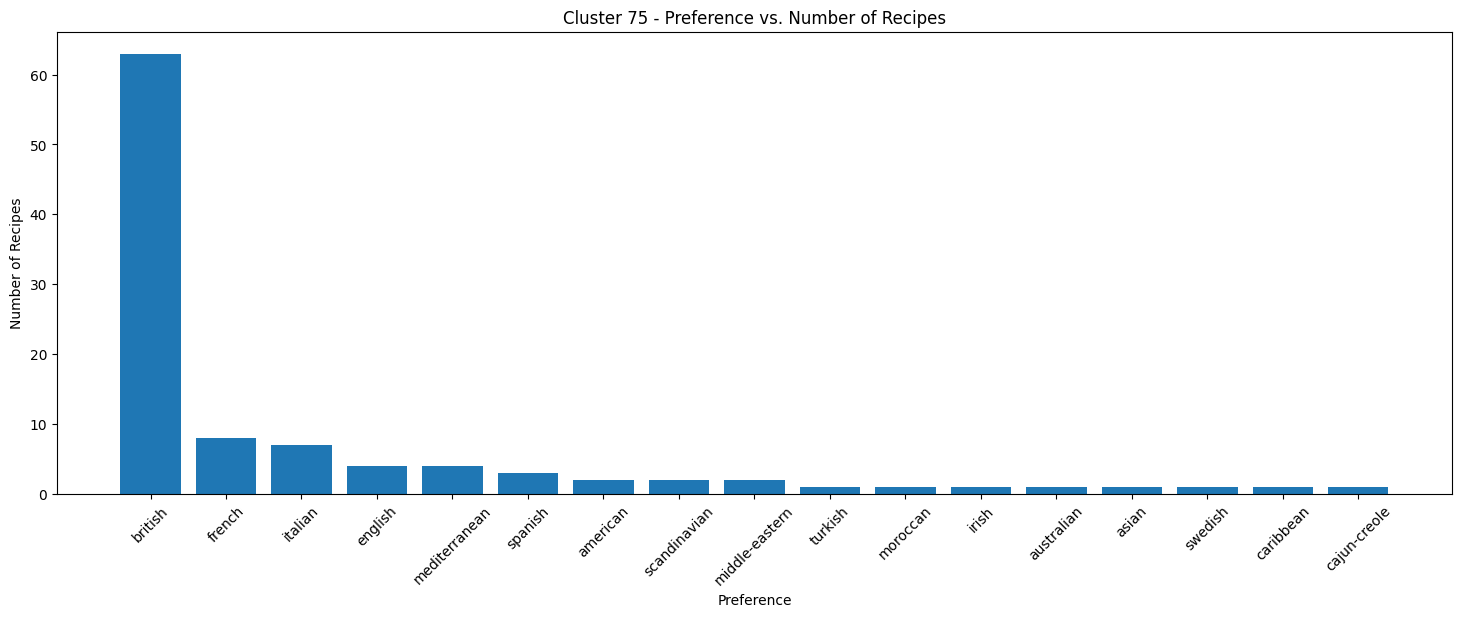

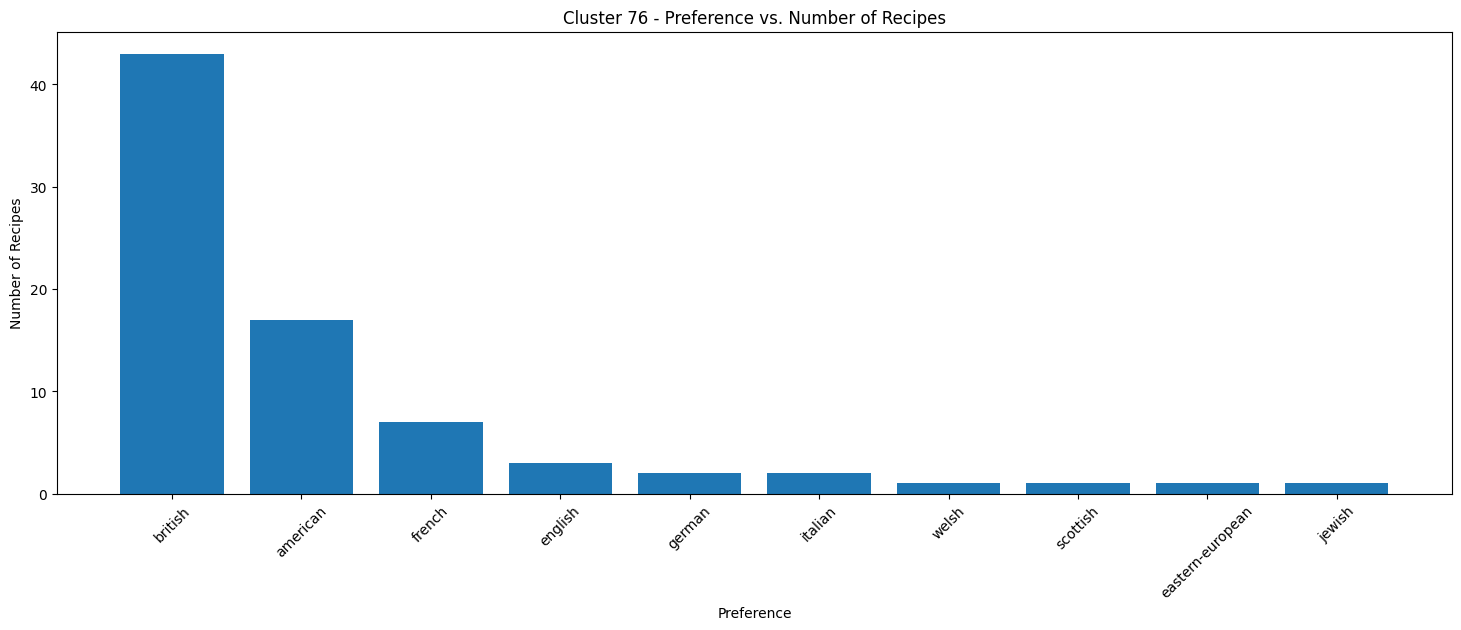

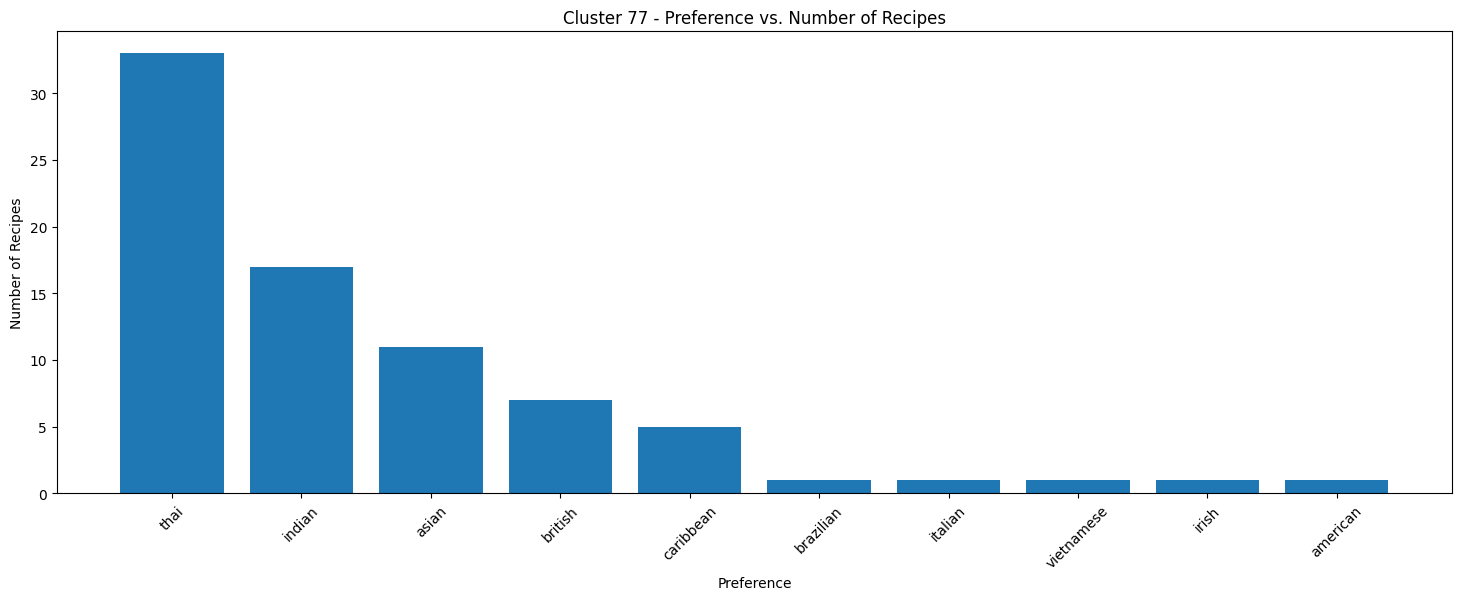

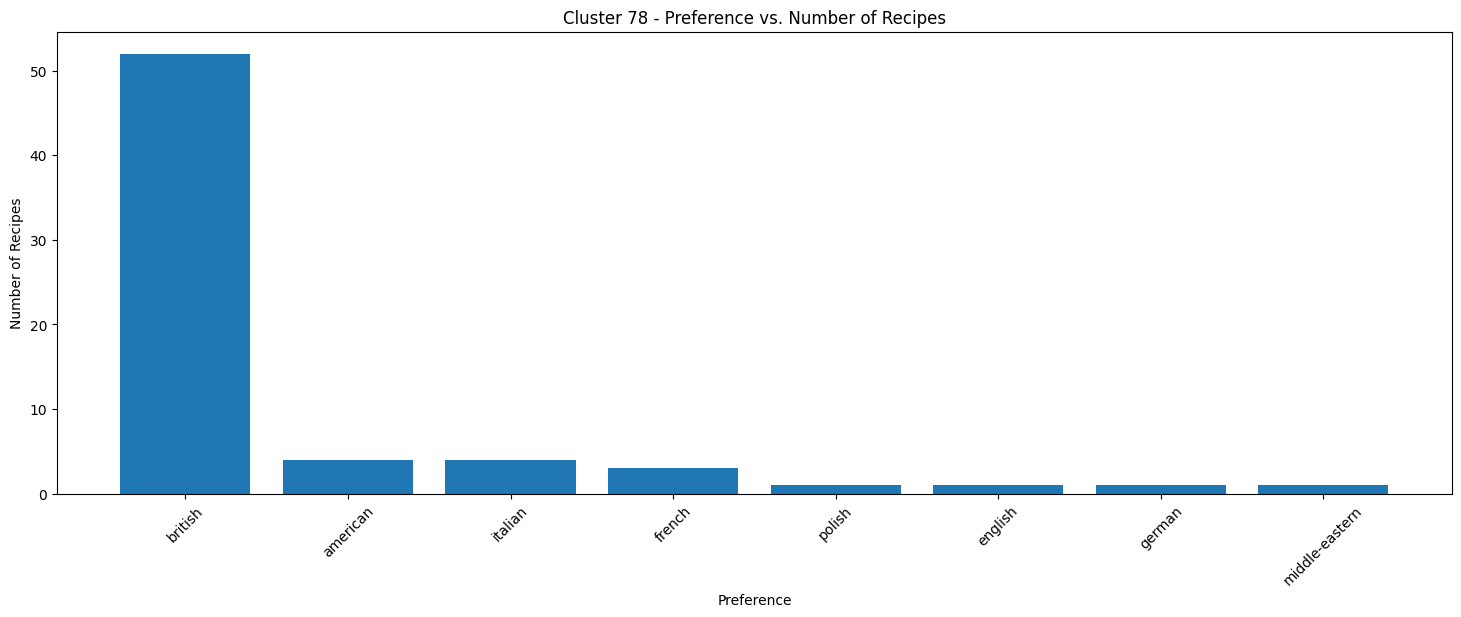

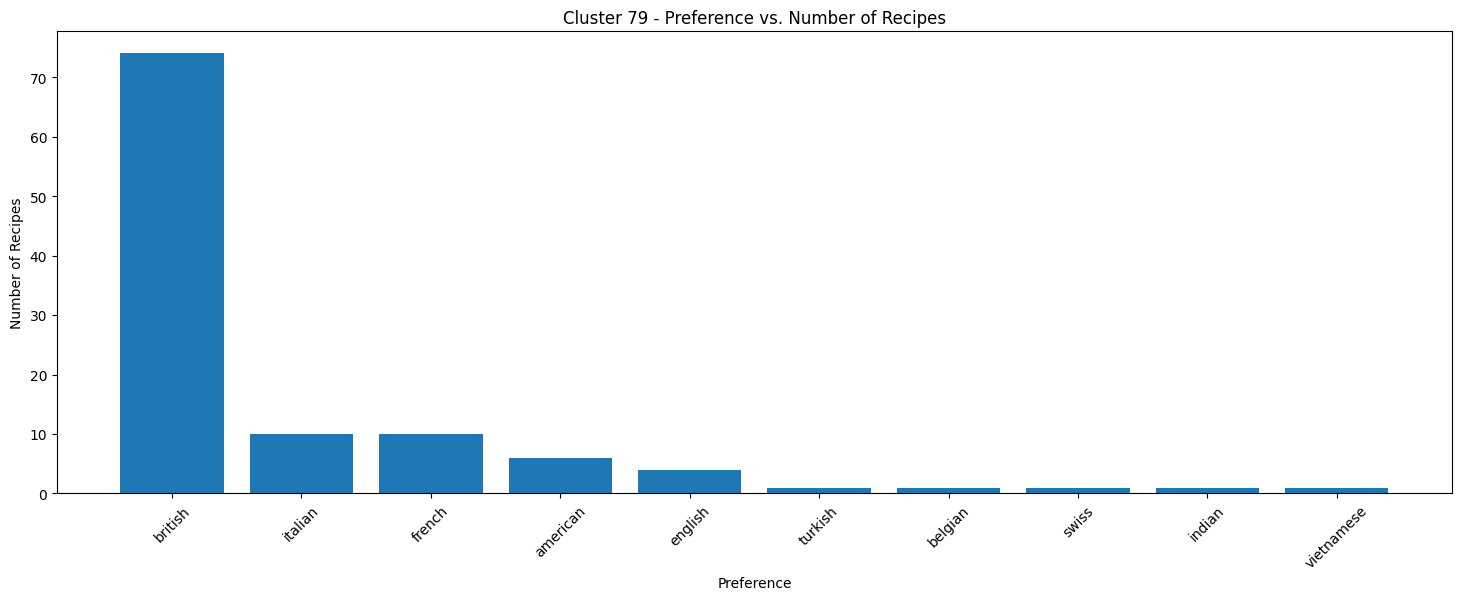

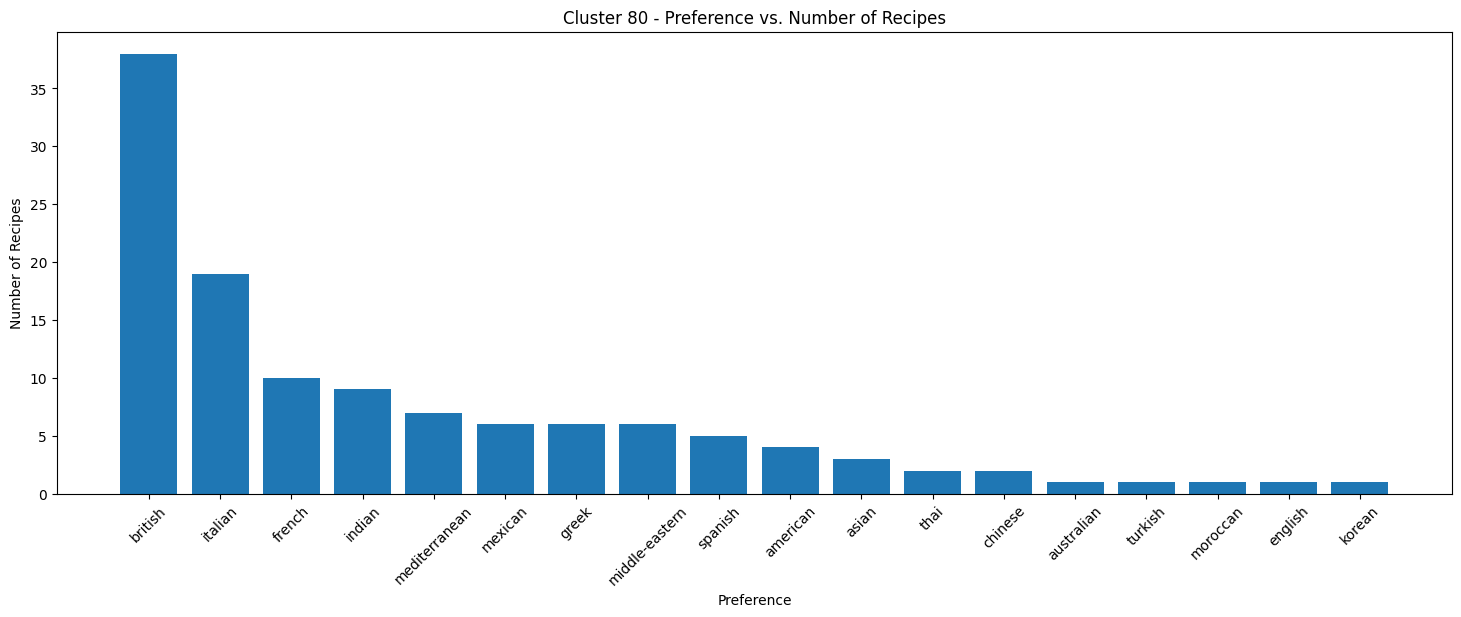

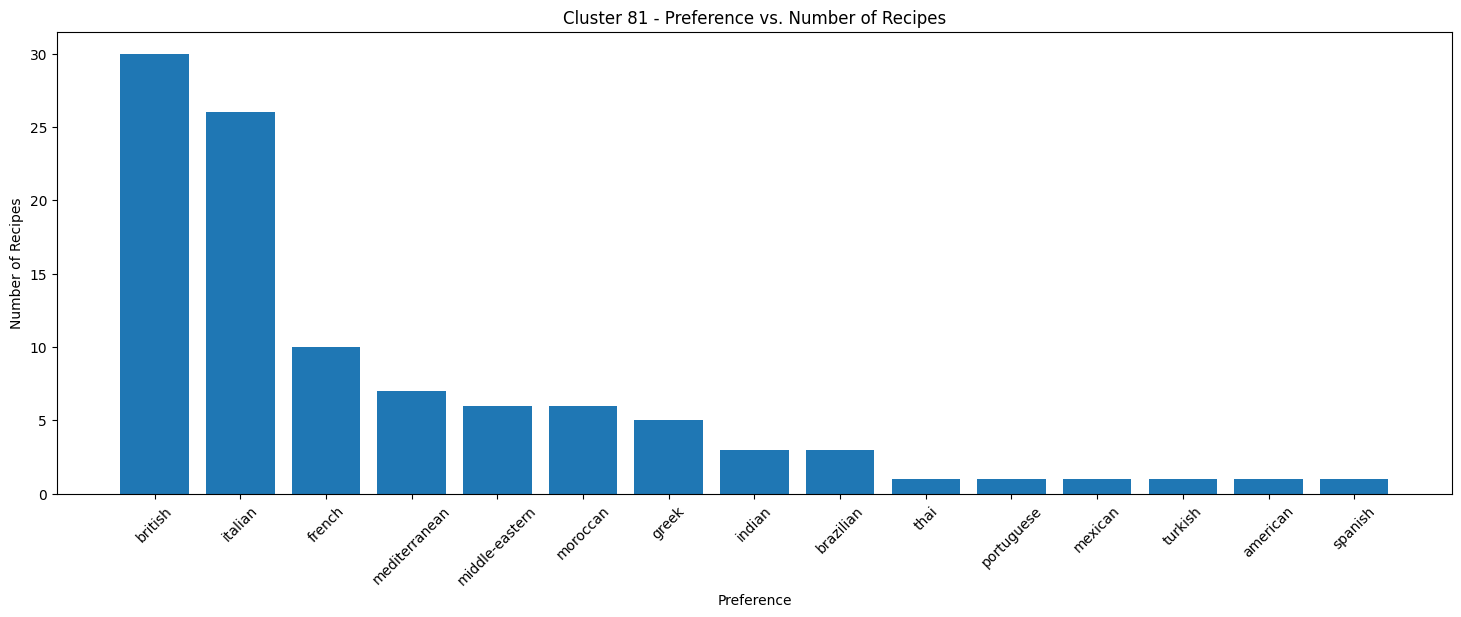

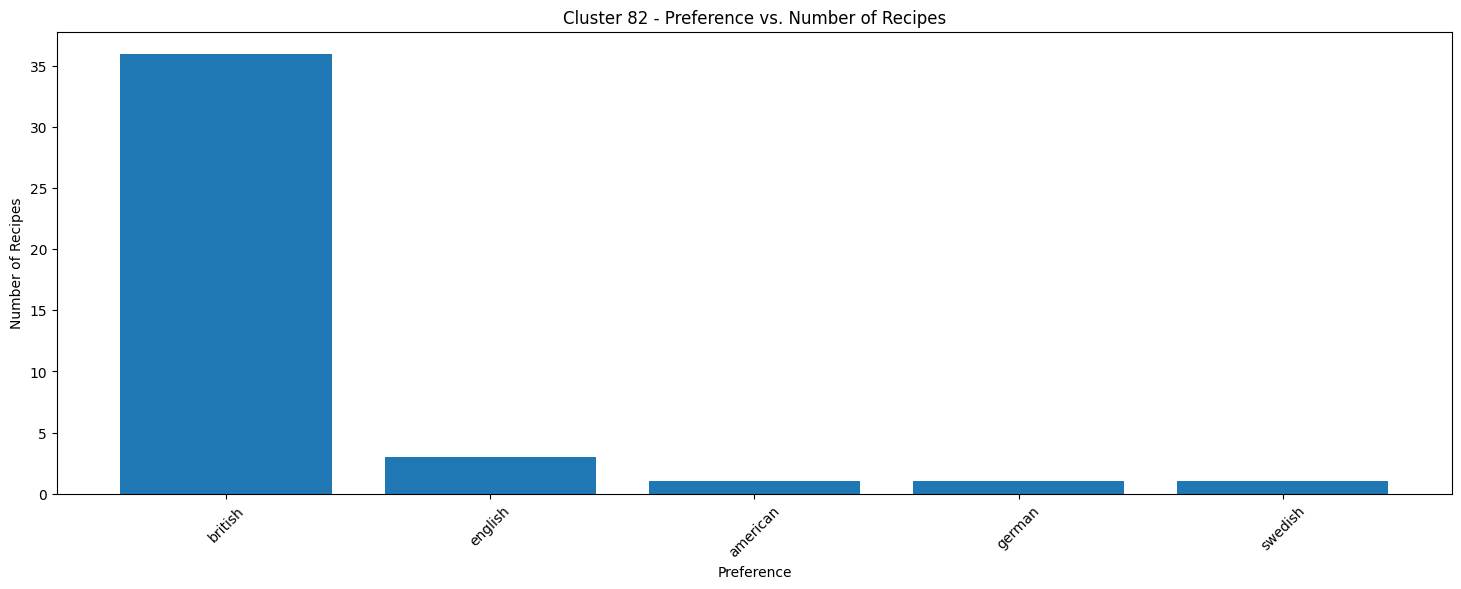

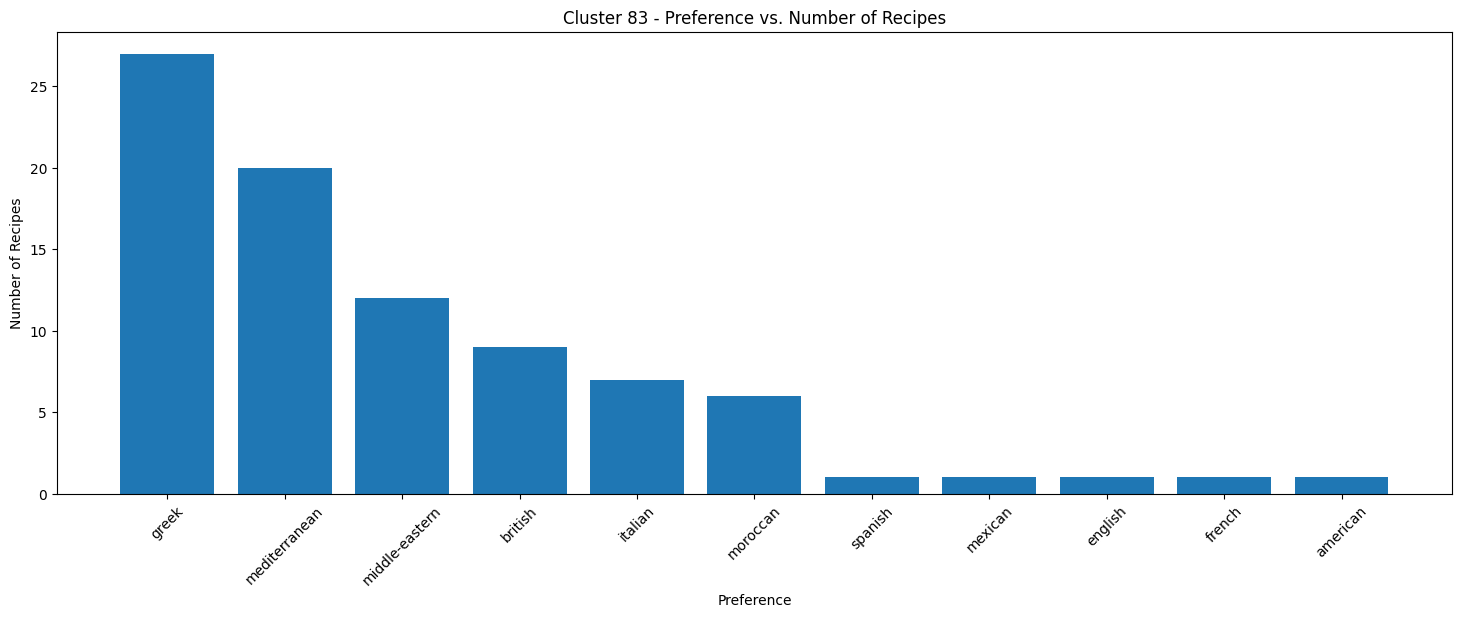

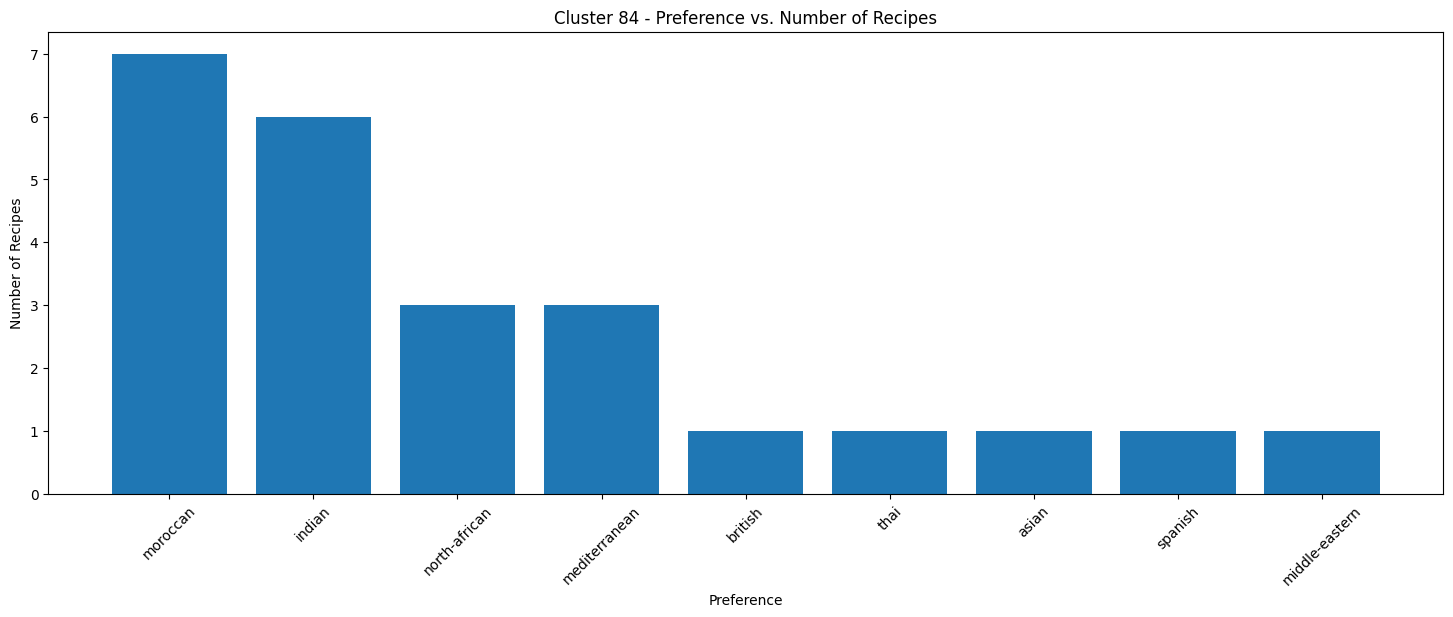

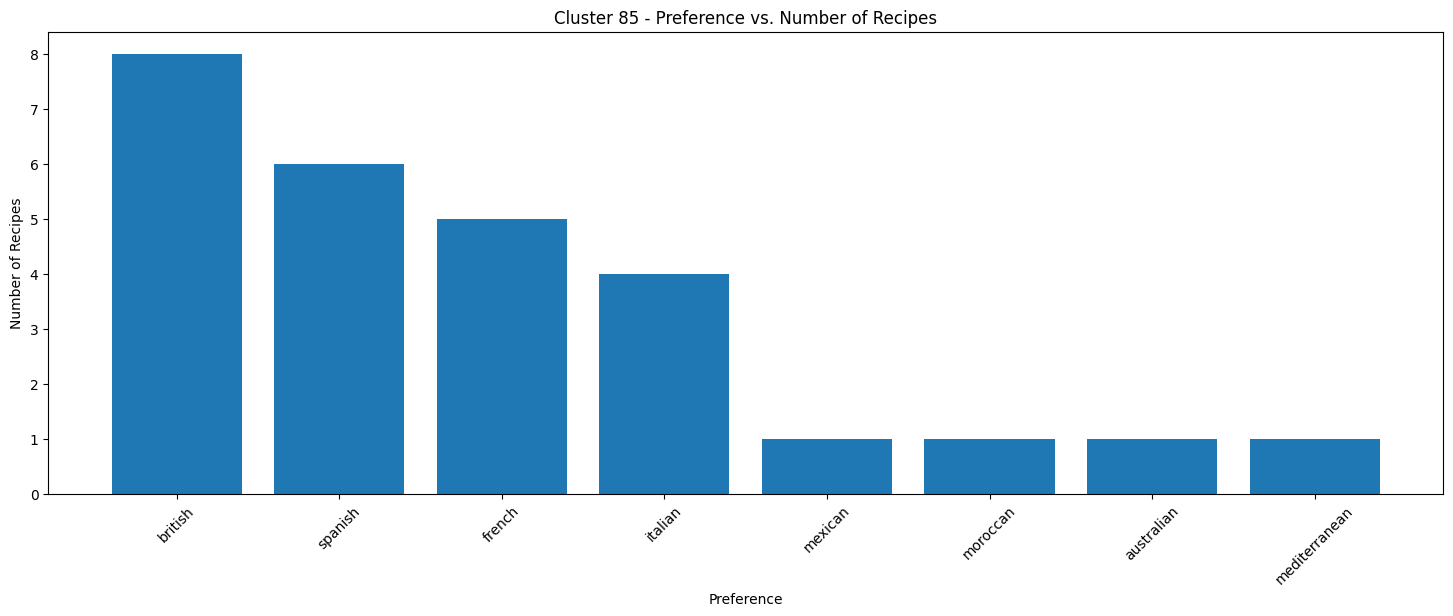

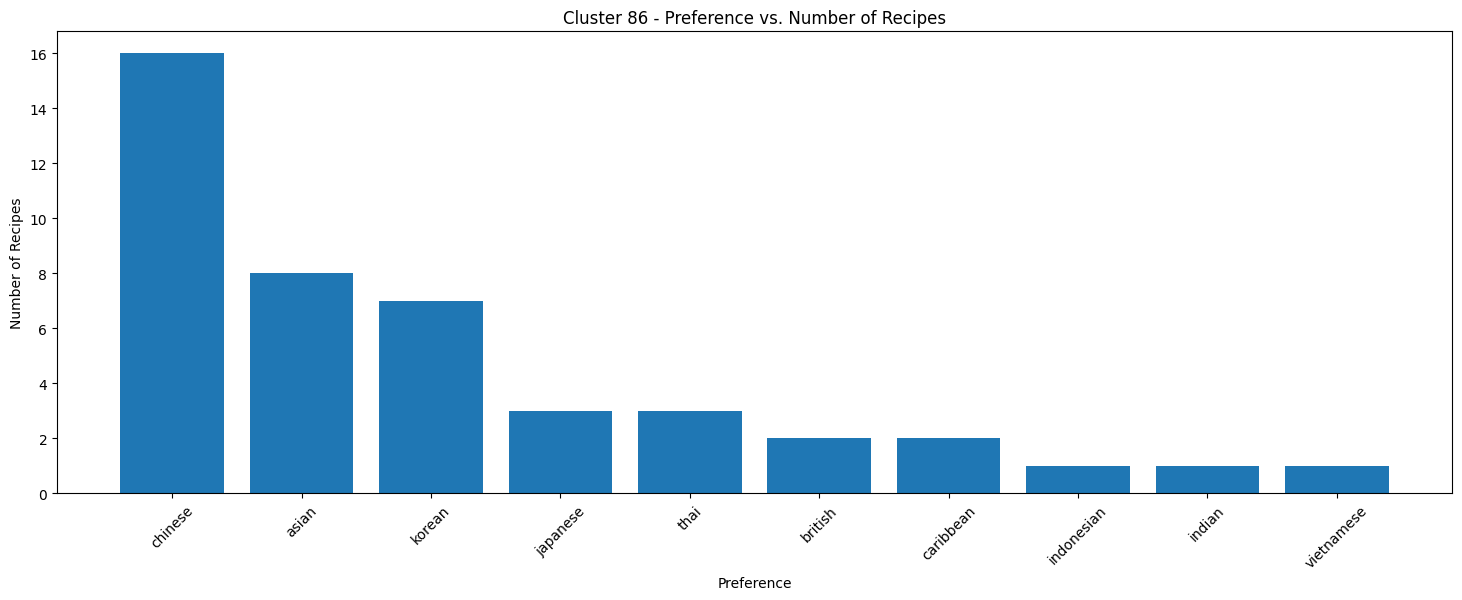

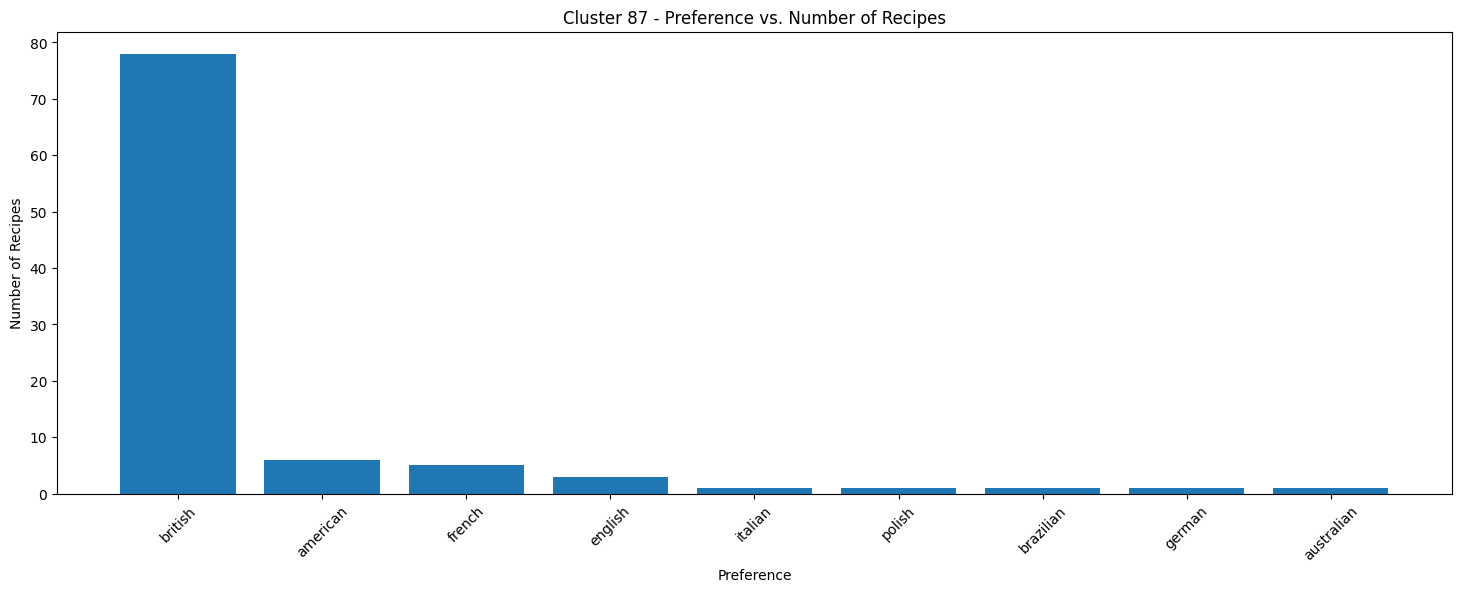

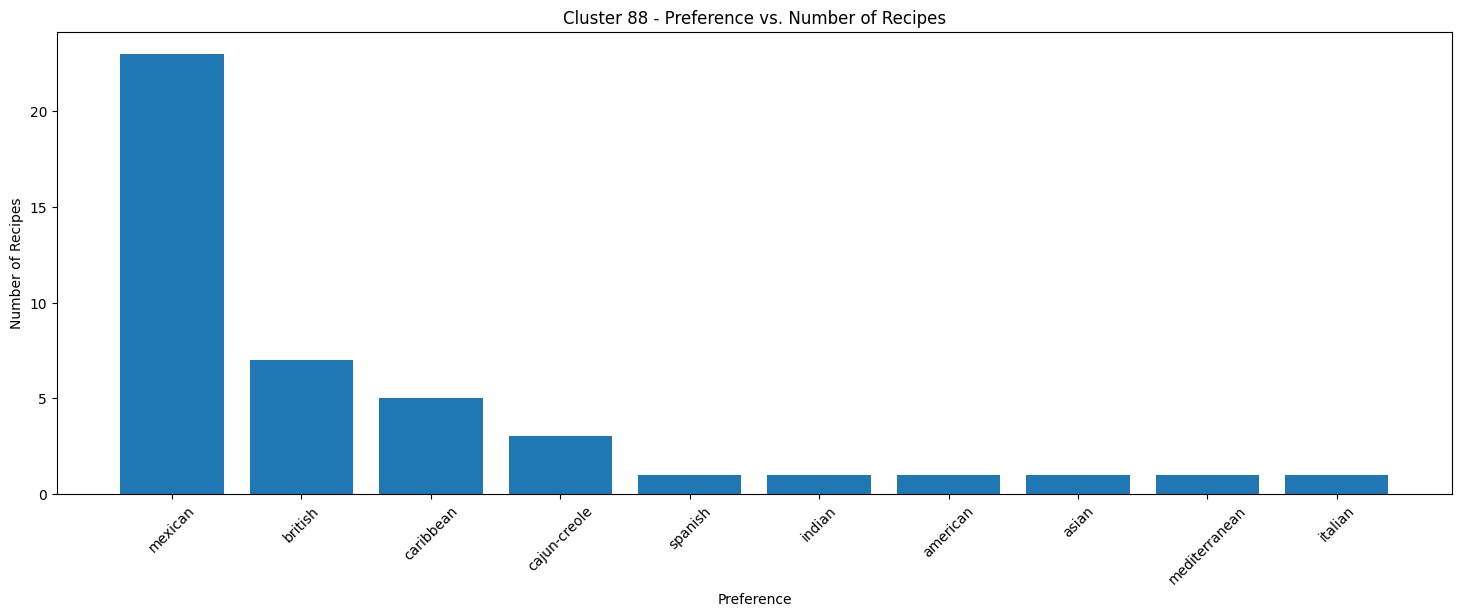

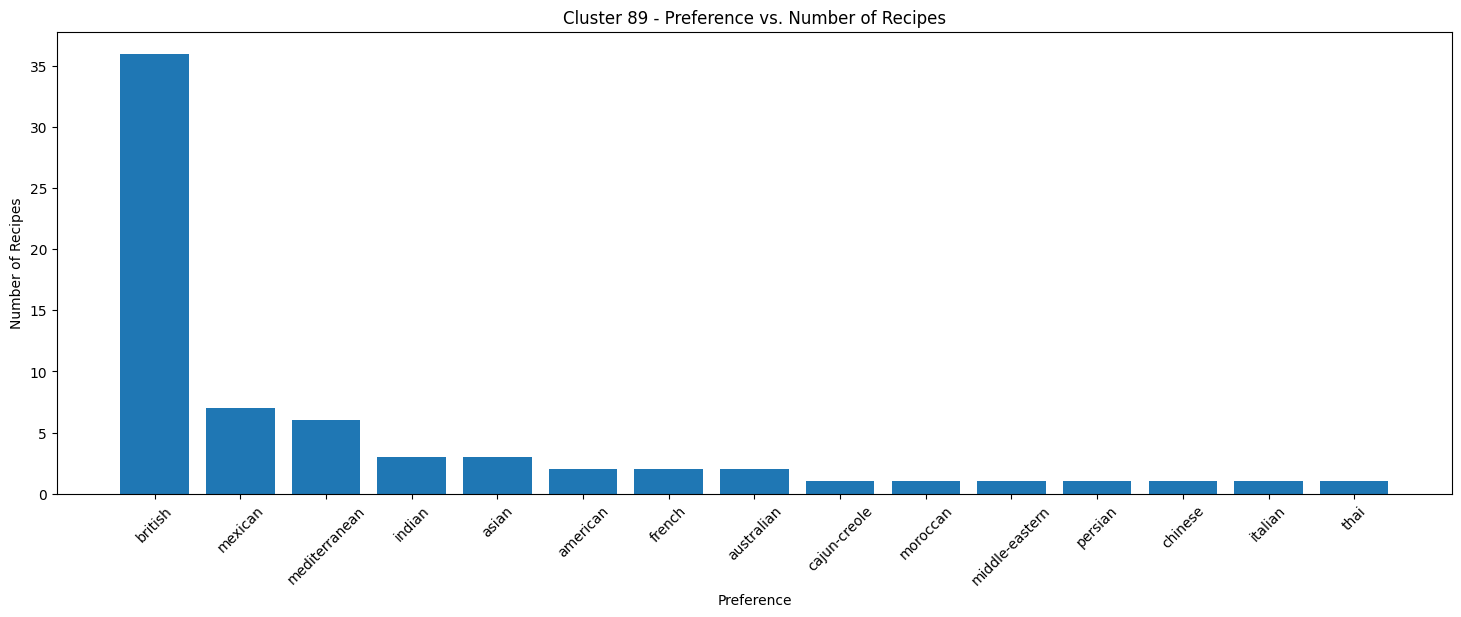

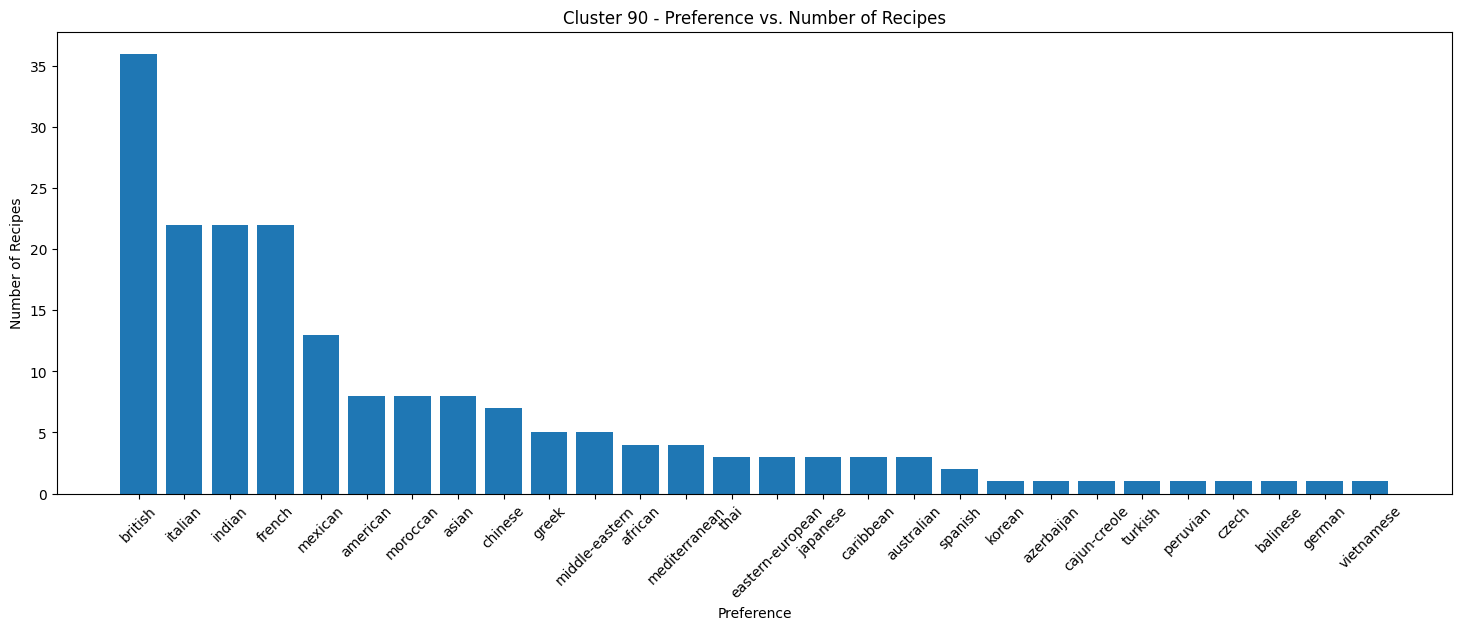

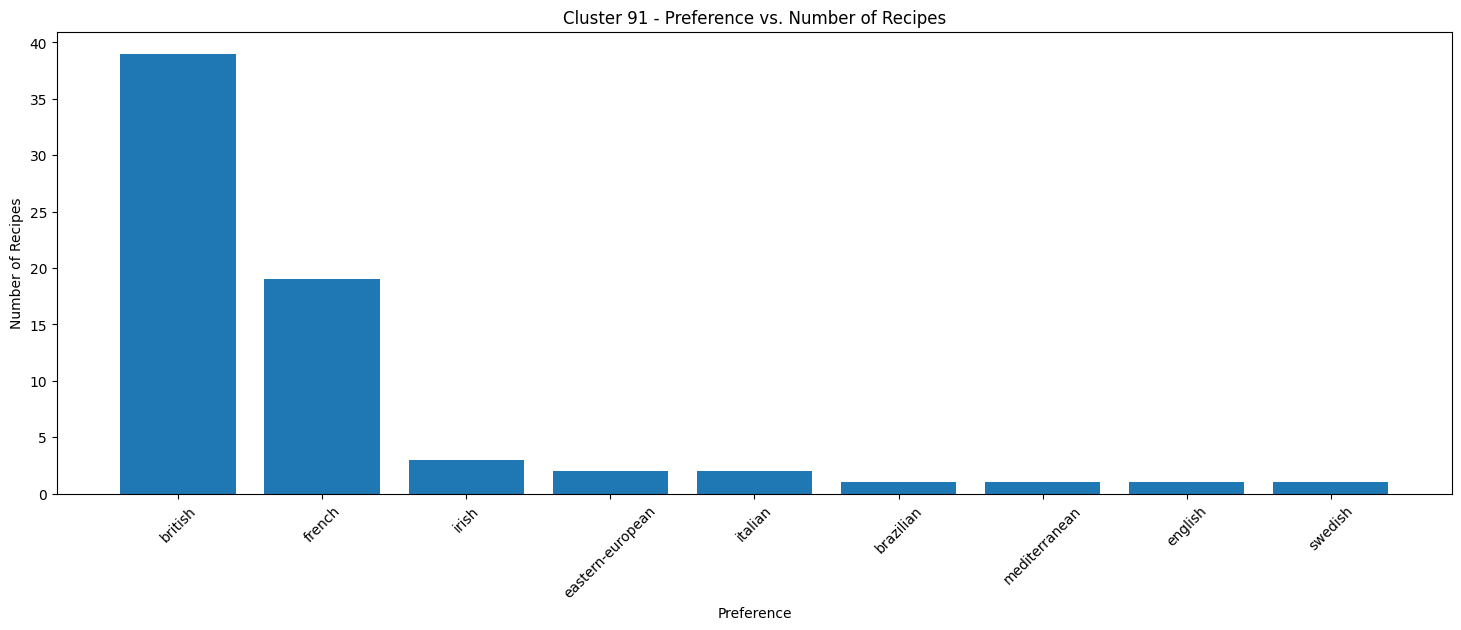

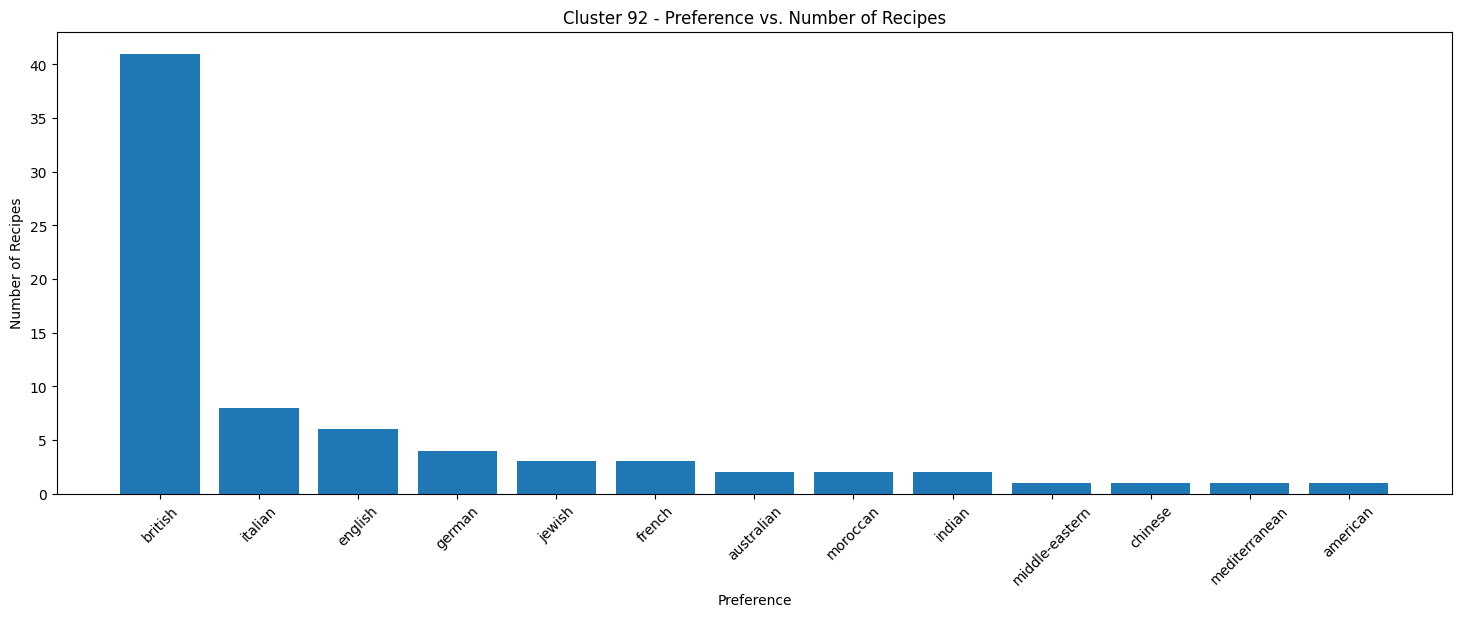

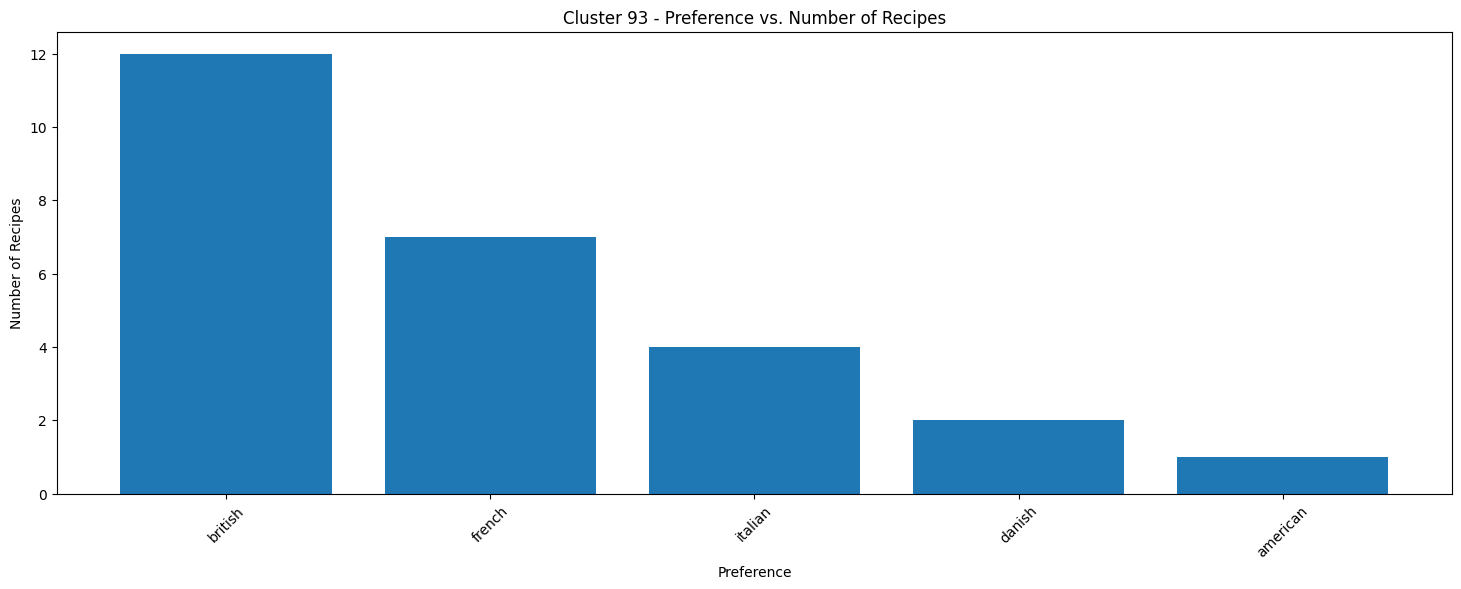

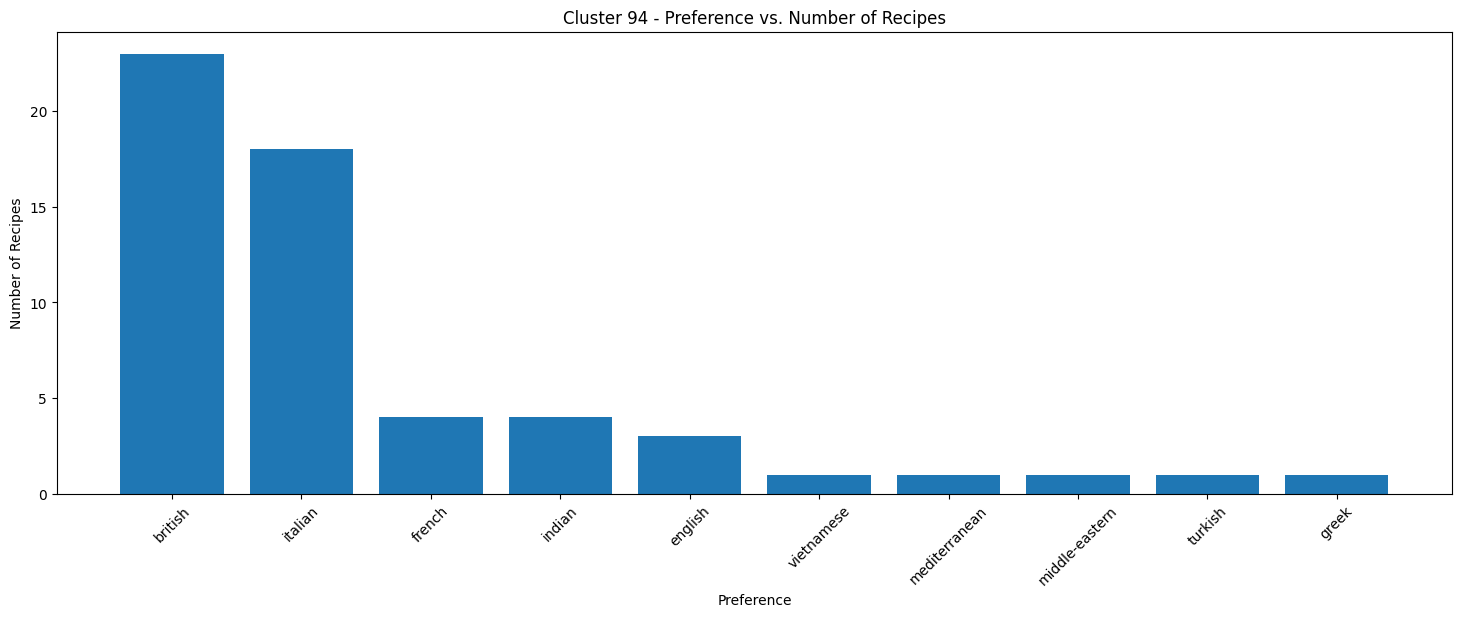

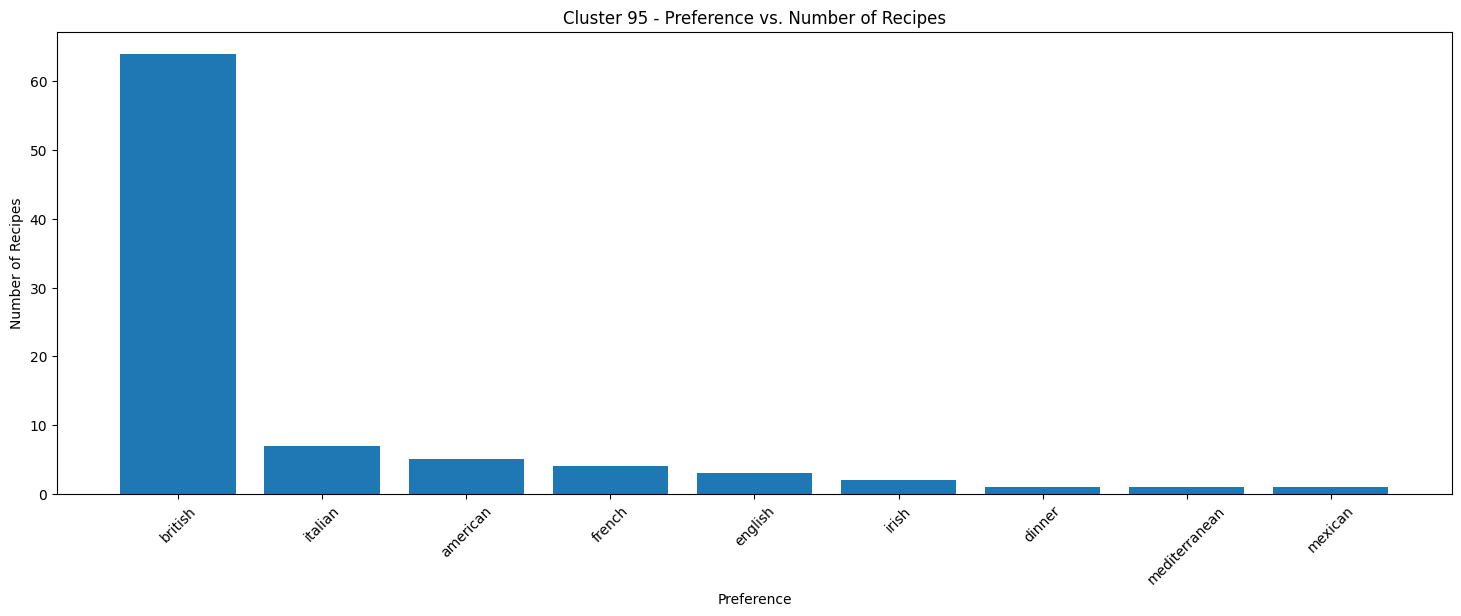

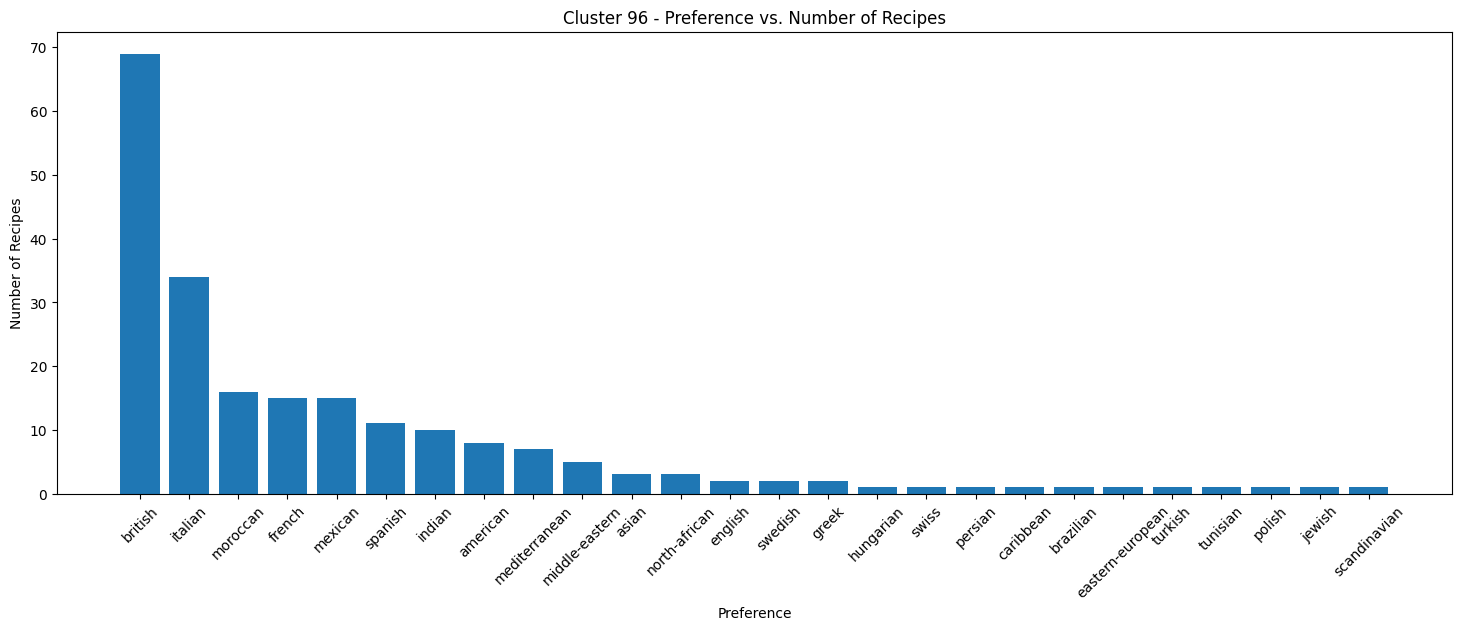

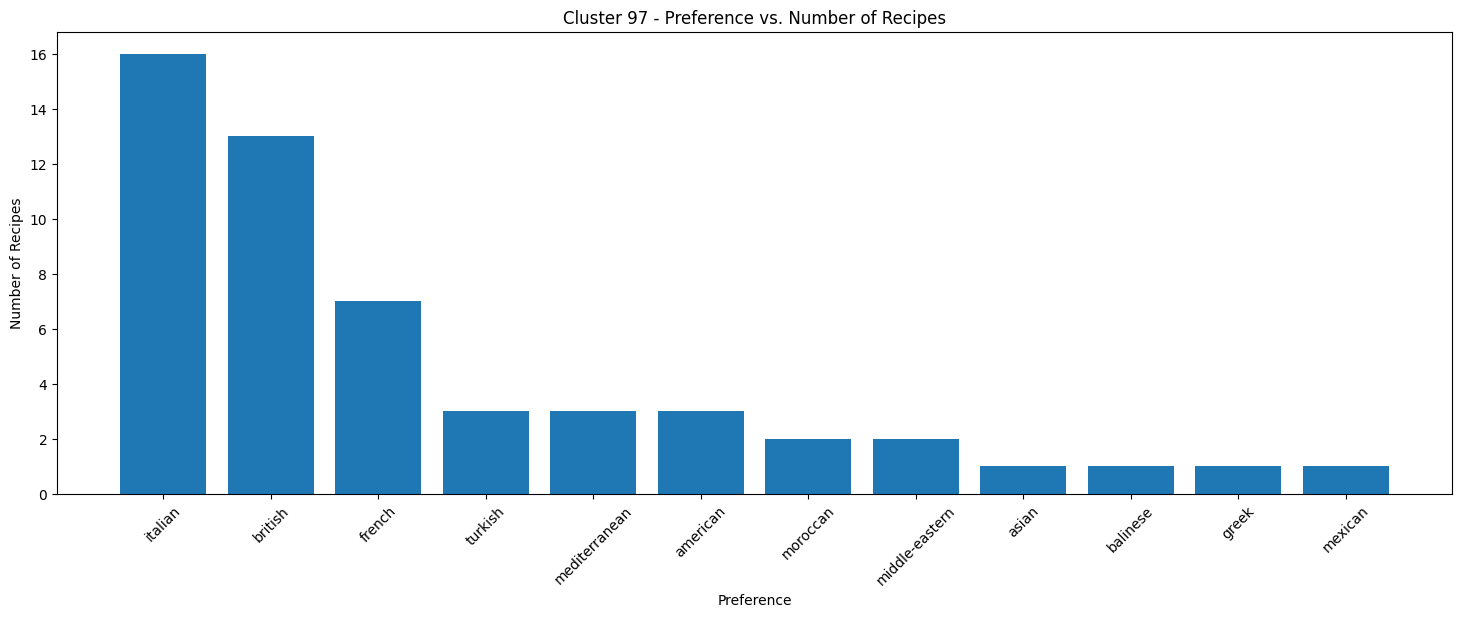

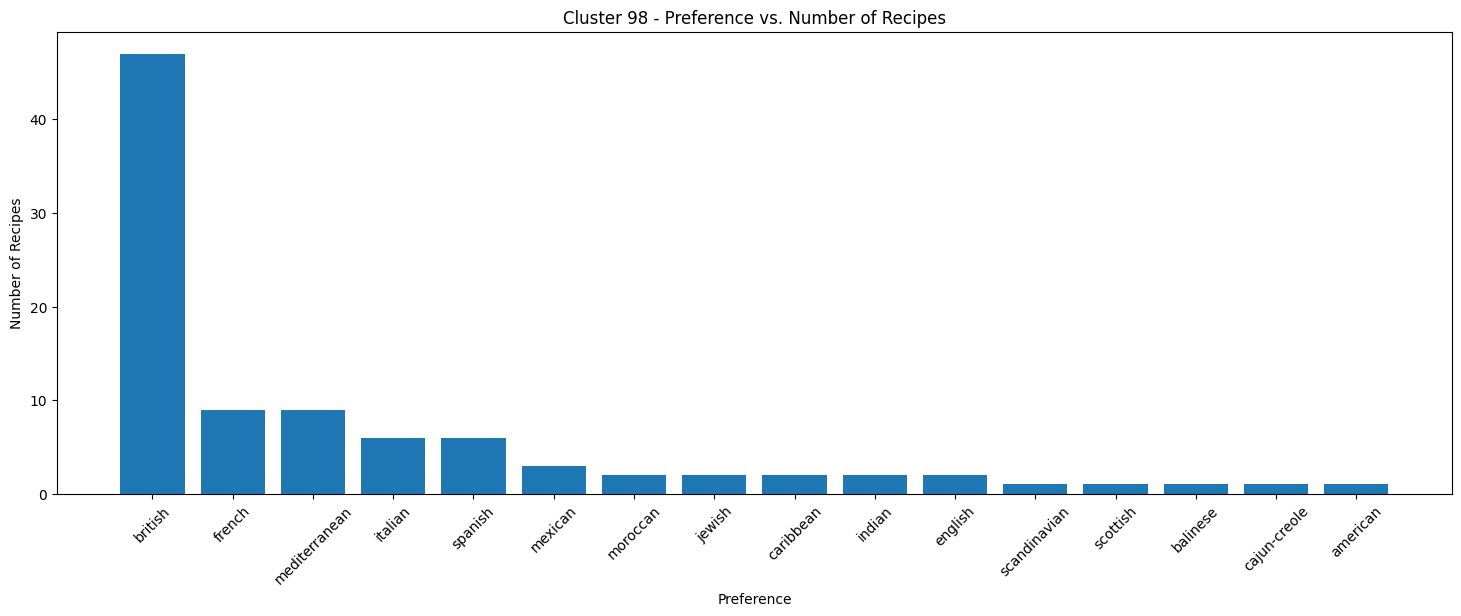

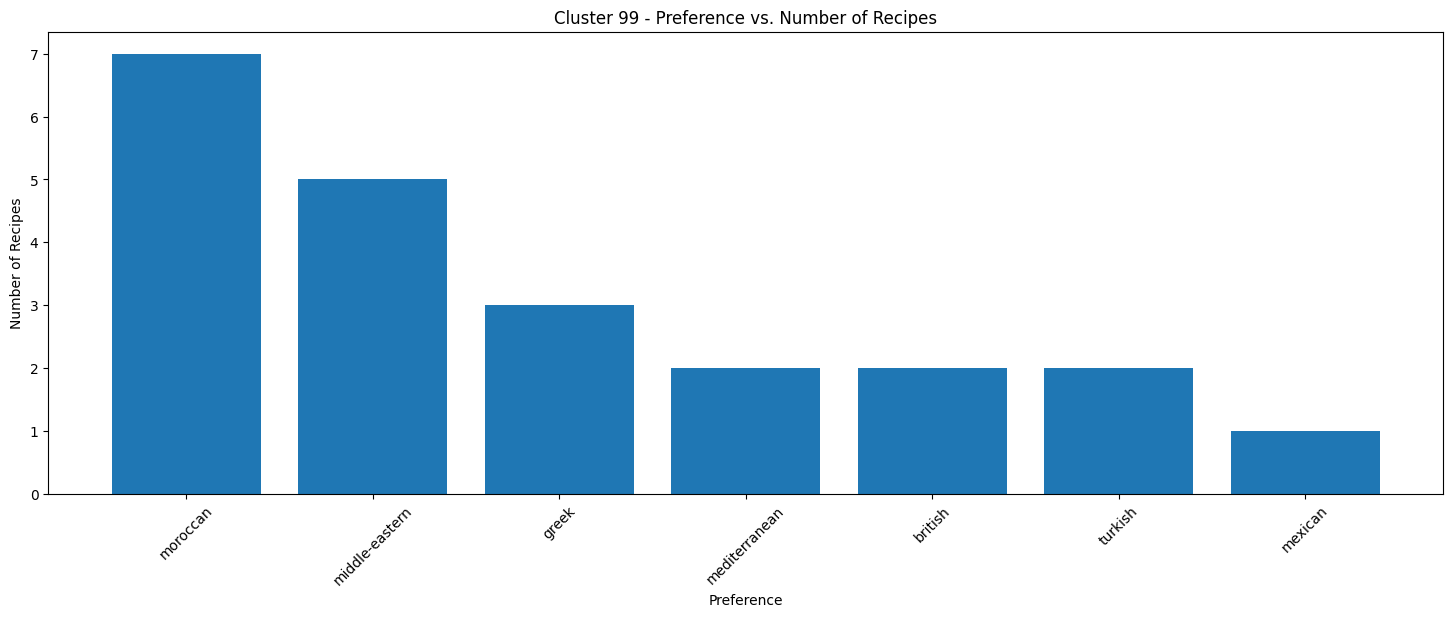

    cluster  Number of Recipes
0         0                 64
1         1                145
2         2                 30
3         3                 80
4         4                 89
..      ...                ...
95       95                 88
96       96                213
97       97                 53
98       98                 95
99       99                 22

[100 rows x 2 columns]


In [77]:
import matplotlib.pyplot as plt

cluster_counts = df1.groupby('cluster')['recipe_title'].count().reset_index()
cluster_counts.rename(columns={'recipe_title': 'Number of Recipes'}, inplace=True)

for cluster_num in range(df1['cluster'].nunique()):
    cluster_df = df1[df1['cluster'] == cluster_num]
    cuisine_counts = cluster_df['preference'].value_counts()
    
    plt.figure(figsize=(18, 6))
    plt.bar(cuisine_counts.index, cuisine_counts.values)
    plt.xlabel('Preference')
    plt.ylabel('Number of Recipes')
    plt.title(f'Cluster {cluster_num} - Preference vs. Number of Recipes')
    plt.xticks(rotation=45)
    plt.show()

print(cluster_counts)